In [1]:
! python --version
! pip list

Python 3.12.3
Package                   Version
------------------------- --------------
absl-py                   2.3.1
accelerate                1.12.0
adagio                    0.2.6
aiohappyeyeballs          2.6.1
aiohttp                   3.13.3
aiohttp-cors              0.8.1
aiosignal                 1.4.0
alembic                   1.16.5
annotated-types           0.7.0
antlr4-python3-runtime    4.9.3
anyio                     4.10.0
apsw                      3.51.2.0
apswutils                 0.1.2
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
autogluon                 1.5.0
autogluon.common          1.5.0
autogluon.core            1.5.0
autogluon.features        1.5.0
autogluon.multimodal      1.5.0
autogluon.tabular         1.5.0
autogluon.timeseries      1.5.0
babel                     2.17.0
backoff                   2.2.1
bear

In [2]:
%cd /home/ahol834/resmed202100066-Glaucoma_PRS/andrewholmes2024/summer2025/outcomes/
! pwd

/home/ahol834/resmed202100066-Glaucoma_PRS/andrewholmes2024/summer2025/outcomes
/home/ahol834/resmed202100066-Glaucoma_PRS/andrewholmes2024/summer2025/outcomes


In [434]:
import os
os.environ["PYARROW_NUM_THREADS"] = '16'
os.environ["OMP_NUM_THREADS"] = '16'
os.environ["POLARS_MAX_THREADS"] = '16' #8
os.environ["POLARS_NUM_THREADS"] = '16' #8

import numpy as np
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup
import hashlib
from datetime import datetime
from zoneinfo import ZoneInfo
import json
from matplotlib_venn import venn2, venn3
from matplotlib_venn.layout.venn3 import DefaultLayoutAlgorithm
from matplotlib_venn.layout.venn3 import cost_based
import matplotlib.pyplot as plt

# Load data

In [4]:
def add_cols_for_data_field(data_field, data_cols, cols_to_use_list):
    cols_for_code = data_cols[data_cols.str.startswith(data_field)]
    if len(cols_for_code) < 1:
            print('No columns found matching field ' + data_field)
    cols_to_use_list.extend(cols_for_code)
    return cols_for_code

In [5]:
def scrape_ukbb_datafield_description(field_id):
    """
        Fetch the UK Biobank Showcase “Data-Field” page for a given field ID and return the
        field's Description string from the “Identification” table.

        Fetch the UK Biobank Showcase “Data-Field” page for a given field ID and return the
        field's Description string from the “Identification” table.
        field_id = strip_field_id(field_id)
    """

    field_id = strip_field_id(field_id)
    url = f'https://biobank.ndph.ox.ac.uk/ukb/field.cgi?id={field_id}'
    try:
        response = requests.get(
            url,
            timeout=30,
            headers={"User-Agent": "Mozilla/5.0 (compatible; ukbb-scraper/1.0)"},
        )
        response.raise_for_status()
    except requests.RequestException as e:
        return f"Request failed: {e}"

    soup = BeautifulSoup(response.text, 'html.parser')

    ident = soup.find("table", attrs={"summary": "Identification"})
    if ident is None:
        return "Description not found (no Identification table)."

    label_td = ident.select_one('tr > td:-soup-contains("Description:")')
    if label_td is None or label_td.get_text(strip=True) != "Description:":
        return "Description not found (no Description row)."

    value_td = label_td.find_next_sibling("td")
    if value_td is None:
        return "Description not found (missing value cell)."

    desc = value_td.get_text(" ", strip=True)
    return desc if desc else "Description not found (empty value)."
    
def strip_field_id(field_id: str) -> str:
    # "f.25.0.0" -> "25"
    # "53.0.0"   -> "53"
    # "53"       -> "53"
    if field_id.startswith("f."):
        return field_id.split(".")[1]
    return field_id.split(".")[0]

### ukb49508

In [202]:
# ukb49508 = assesement centre (NOT ocular), inpatient data

ukb49508_csv_cols = pd.read_table('../../../UKBB_Data/ukb49508.tab', nrows=0).columns
ukb49508_cols_to_use = [
    # Demographic
    'f.eid', 
    'f.34.0.0', # Year of birth
    'f.52.0.0', # Month of brith
    'f.53.0.0', 'f.53.1.0', 'f.53.2.0', 'f.53.3.0', # date attending assesement centre
    'f.21003.0.0', # age at assesement centre
    'f.31.0.0', # sex
    'f.22001.0.0', # genetic sex

    'f.21000.0.0', # Ethnicity
    
] 

# pregnant
add_cols_for_data_field('f.3140', ukb49508_csv_cols, ukb49508_cols_to_use) # pregnant

# Self-reported conditions
f20002_cols = add_cols_for_data_field('f.20002', ukb49508_csv_cols, ukb49508_cols_to_use) # self-report conditions
f20009_cols = add_cols_for_data_field('f.20009', ukb49508_csv_cols, ukb49508_cols_to_use) # interpolated age self-reported medical conditions diagnosed
f6148_cols = add_cols_for_data_field('f.6148', ukb49508_csv_cols, ukb49508_cols_to_use) # eye conditions
f2277_cols = add_cols_for_data_field('f.2277', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported eye problems yes/no
add_cols_for_data_field('f.4689', ukb49508_csv_cols, ukb49508_cols_to_use) # age glaucoma dx
add_cols_for_data_field('f.5923', ukb49508_csv_cols, ukb49508_cols_to_use) # age AMD dx
add_cols_for_data_field('f.4700', ukb49508_csv_cols, ukb49508_cols_to_use) # age cat dx
add_cols_for_data_field('f.5901', ukb49508_csv_cols, ukb49508_cols_to_use) # age DR dx
add_cols_for_data_field('f.5430', ukb49508_csv_cols, ukb49508_cols_to_use) # age eye trauma dx

# Surgeries
f5181_cols = add_cols_for_data_field('f.5181', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported any eye surgery
f5326_cols = add_cols_for_data_field('f.5326', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported glaucoma surgery
f5327_cols = add_cols_for_data_field('f.5327', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported laser tx
f5419_cols = add_cols_for_data_field('f.5419', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported eye trauma
f5325_cols = add_cols_for_data_field('f.5325', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported refractive laser eye surgery
f5328_cols = add_cols_for_data_field('f.5328', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported corneal graft surgery
f5324_cols = add_cols_for_data_field('f.5324', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported cataract surgery
f20004_cols = add_cols_for_data_field('f.20004', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported surgery
f20010_cols = add_cols_for_data_field('f.20010', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported surgery interpolayed year
f20011_cols = add_cols_for_data_field('f.20011', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported surgery interpolayed age
f20003_cols = add_cols_for_data_field('f.20003', ukb49508_csv_cols, ukb49508_cols_to_use) # self-reported medication


# Inpatient
ICD10_inpatient_dx_cols  = add_cols_for_data_field('f.41270.0', ukb49508_csv_cols, ukb49508_cols_to_use) # ICD10 inpatient diagnosis 
ICD10_inpatient_date_cols = add_cols_for_data_field('f.41280.0', ukb49508_csv_cols, ukb49508_cols_to_use) # ICD10 inpatient date

ICD9_inpatient_dx_cols = add_cols_for_data_field('f.41271.0', ukb49508_csv_cols, ukb49508_cols_to_use) # ICD9 inpatient diagnosis 
ICD9_inpatient_date_cols = add_cols_for_data_field('f.41281.0', ukb49508_csv_cols, ukb49508_cols_to_use) # ICD9 inpatient date

OPCS4_inpatient_operation_cols = add_cols_for_data_field('f.41272.0', ukb49508_csv_cols, ukb49508_cols_to_use) # OPCS4 inpatient operation code
OPCS4_inpatient_operation_date_cols = add_cols_for_data_field('f.41282.0', ukb49508_csv_cols, ukb49508_cols_to_use) # OPCS4 inpatient operation code

OPCS3_inpatient_operation_cols = add_cols_for_data_field('f.41273.0', ukb49508_csv_cols, ukb49508_cols_to_use) # OPCS3 inpatient operation code
OPCS3_inpatient_operation_date_cols = add_cols_for_data_field('f.41283.0', ukb49508_csv_cols, ukb49508_cols_to_use) # OPCS3 inpatient operation code

ukb49508_cols_to_use = np.unique(ukb49508_cols_to_use)
print(f'Found {len(ukb49508_cols_to_use)} columns')

Found 1749 columns


In [203]:
date_cols = (
    ['f.53.0.0']
    + list(ICD10_inpatient_date_cols)
    + list(ICD9_inpatient_date_cols)
    + list(OPCS4_inpatient_operation_date_cols)
    + list(OPCS3_inpatient_operation_date_cols)
)

# Build dtype mapping for str diagnosis columns
dtype_dict = {col: 'string' for col in (
    list(f20003_cols)
    + list(ICD10_inpatient_dx_cols) + list(ICD9_inpatient_dx_cols)
    + list(OPCS4_inpatient_operation_cols) + list(OPCS3_inpatient_operation_cols)
)}


In [204]:
%%time

# UNCOMMENT desired method of loading data below:
# ##################################

# ## (A) LOAD FROM PARAQUET FILE (FASTER)
# #################################
# ukb49508_df = pd.read_parquet('./data/extracted_raw_ukb49508.parquet')


# ------------
# OR
# ------------


### (B) LOAD FROM RAW FILE - if .pkl not already made
##################################
dtype_dict_dates = {c: "string" for c in date_cols}
dtype_dict_all = {**dtype_dict, **dtype_dict_dates}
ukb49508_df = pd.read_table(
    '../../../UKBB_Data/ukb49508.tab',
    usecols=ukb49508_cols_to_use,
    engine='c', # DO NOT use pyarrow
    date_format='%Y-%m-%d',
    dtype=dtype_dict_all,
    low_memory=False,
    memory_map=True,
)
ukb49508_df.to_parquet('./data/extracted_raw_ukb49508.parquet', compression='zstd') # Save a raw copy .pkl - if loading from raw file

CPU times: user 6min, sys: 3min 27s, total: 9min 28s
Wall time: 9min 34s


In [205]:
## Ensure date columns fixed - MUST RUN
ukb49508_df[date_cols] = ukb49508_df[date_cols].apply(
    pd.to_datetime,
    errors="coerce",
    format="%Y-%m-%d",
)


## ukb51745

In [11]:
%%time 

# Ocular data

ukb51745_df = pd.read_table(
    '../../../UKBB_Data_Basket3/ukb51745.tab', 
    usecols=[
        'f.eid', 'f.5262.0.0', 'f.5254.0.0', 'f.5325.0.0', 'f.5328.0.0', 'f.5181.0.0',
        # Average RNFL thickness
        'f.28500.0.0', # OS
        'f.28501.0.0', # OD

        # Average GC-IPL thickness
        'f.28504.0.0', # OS
        'f.28505.0.0', # OD
    ],
    engine='c',
    low_memory=False,
    memory_map=True,
)

# Align indices
ukb51745_df = ukb49508_df[['f.eid']].merge(ukb51745_df, on='f.eid', how='left')

CPU times: user 20.4 s, sys: 17.4 s, total: 37.7 s
Wall time: 38.1 s


## ukb675501 (includes first occurrences)

In [12]:
occurence_date_cols = np.concatenate((
    np.arange(130000, 130344+1, 2), # infectious
    np.arange(130622, 130688+1, 2), # haem
    np.arange(130692, 130834+1, 2), # endocrine
    np.arange(130836, 130990+1, 2), # mental
    np.arange(130992, 131126+1, 2), # NS
    np.arange(131128, 131220+1, 2),# eye
    np.arange(131222, 131268+1, 2), # ear and mastoid
    np.arange(131270, 131422+1, 2), # circ
    np.arange(131424, 131550+1, 2), # resp
    np.arange(131552, 131694+1, 2), # DS
    np.arange(131696, 131838+1, 2), # skin
    np.arange(131840, 131996+1, 2), # msk
    np.arange(131998, 132160+1, 2), # GU ---> includes sex-specific codes
    np.arange(132314, 132430+1, 2), # perinatal
    np.arange(132432, 132604+1, 2), # congenital

    # excluding pregnancy, childbirth
))

occurence_date_cols = 'f.' + occurence_date_cols.astype(str) + '.0.0'

In [13]:
ukb675501_csv_cols = pd.read_table('../../../UKBB_Data_healthrelatedoutcomes/ukb675501.tab', nrows=0).columns
ukb675501_cols_to_use = ['f.eid', 'f.22189.0.0']

for c in occurence_date_cols:
    if c not in ukb675501_csv_cols:
        print(f'Warning: column {c} not found in ukb675501: {scrape_ukbb_datafield_description(c)}')
        time.sleep(1)
        continue
    else:
        ukb675501_cols_to_use.append(str(c))

occurence_date_cols_used = [str(c) for c in occurence_date_cols if c in ukb675501_csv_cols]

In [14]:
%%time

ukb675501_df = pd.read_table(
    '../../../UKBB_Data_healthrelatedoutcomes/ukb675501.tab', 
    usecols=ukb675501_cols_to_use,
    engine='c',
    low_memory=False,
    memory_map=True,
)

# Align indices
ukb675501_df = ukb49508_df[['f.eid']].merge(ukb675501_df, on='f.eid', how='left')

CPU times: user 1min 36s, sys: 4min 58s, total: 6min 35s
Wall time: 6min 34s


In [15]:
## Ensure date columns fixed - MUST RUN
ukb675501_df[occurence_date_cols_used] = ukb675501_df[occurence_date_cols_used].apply(
    pd.to_datetime,
    errors="coerce",
    format="%Y-%m-%d",
)


## GP

In [16]:
# Load GP clinical events

gp_events_raw_table = pd.read_table(
    '../../../UKBB_Data_healthrelatedoutcomes/gp_clinical.txt', 
    usecols=['eid', 'event_dt', 'read_2', 'read_3'],
    parse_dates = ['event_dt'],
    date_format='%d/%m/%Y',
    low_memory=False,
    memory_map=True,
)

# Merge
merged_gp_events_df = gp_events_raw_table.merge(ukb49508_df[['f.eid', 'f.53.0.0']], left_on='eid', right_on='f.eid', suffixes=('_gp', '_inpatient'))[['f.eid', 'f.53.0.0', 'event_dt', 'read_2', 'read_3']]

# Coerce dtypes
merged_gp_events_df['event_dt'] = pd.to_datetime(merged_gp_events_df['event_dt'], format='%d/%m/%Y')
merged_gp_events_df['f.53.0.0'] = pd.to_datetime(merged_gp_events_df['f.53.0.0'], format='%Y-%m-%d')
merged_gp_events_df['read_2'] = merged_gp_events_df['read_2'].astype("string")
merged_gp_events_df['read_3'] = merged_gp_events_df['read_3'].astype("string")

In [17]:
# Load GP prescription records

gp_prescriptions_raw_table = pd.read_table(
    '../../../UKBB_Data_healthrelatedoutcomes/gp_scripts.txt', 
    usecols = ['eid', 'issue_date', 'bnf_code'],
    parse_dates = ['issue_date'],
    date_format='%d/%m/%Y',
    low_memory=False,
    memory_map=True,
)

In [18]:
# Merge
merged_gp_prescriptions_df = gp_prescriptions_raw_table.merge(ukb49508_df[['f.eid', 'f.53.0.0']], left_on='eid', right_on='f.eid', suffixes=('_gp', '_inpatient'))[['f.eid', 'f.53.0.0', 'issue_date', 'bnf_code']]

# Coerce dtypes
merged_gp_prescriptions_df['issue_date'] = pd.to_datetime(merged_gp_prescriptions_df['issue_date'], format='%d/%m/%Y')
merged_gp_prescriptions_df['f.53.0.0'] = pd.to_datetime(merged_gp_prescriptions_df['f.53.0.0'], format='%d/%m/%Y')

In [19]:
# Save copies
merged_gp_events_df.to_parquet('./data/extracted_raw_gp_events.parquet', compression='zstd')
merged_gp_prescriptions_df.to_parquet('./data/extracted_raw_gp_prescriptions.parquet', compression='zstd')

## Init

In [20]:
diagnosis_df = pd.DataFrame()
diagnosis_df['f.eid'] = ukb49508_df['f.eid']

In [21]:
est_dob = pd.to_datetime(dict(year=ukb49508_df['f.34.0.0'], month=ukb49508_df['f.52.0.0'], day=15))
diagnosis_df['DOB_est'] = est_dob

In [22]:
# Est age of assessment visit (not rounded, unlike f21003)
diagnosis_df['age_assessment_est'] = (ukb49508_df['f.53.0.0'] - diagnosis_df['DOB_est']).dt.days / 365.25 #np.floor((ukb49508_df['f.53.0.0'] - diagnosis_df['DOB_est']).dt.days / 365.25)

In [23]:
#### Minor exclusions

cols_3140 = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.3140')]
diagnosis_df['Ever pregnant'] = ukb49508_df[cols_3140].eq(1).any(axis=1)

diagnosis_df['Sex_nondisc'] = np.select(
    [
        ukb49508_df['f.22001.0.0'].isna() & ukb49508_df['f.31.0.0'].isna(),
        ukb49508_df['f.22001.0.0'].isna() & ukb49508_df['f.31.0.0'].notna(),
        ukb49508_df['f.22001.0.0'].notna() & ukb49508_df['f.31.0.0'].isna(),
        ukb49508_df['f.22001.0.0'] == ukb49508_df['f.31.0.0'],
        ukb49508_df['f.22001.0.0'] != ukb49508_df['f.31.0.0'],
    ],
    [
        np.nan,
        ukb49508_df['f.31.0.0'],
        ukb49508_df['f.22001.0.0'],
        ukb49508_df['f.31.0.0'],
        np.nan,
    ],
    default=np.nan
)

In [24]:
invalid_gp_dates = [
    pd.to_datetime('01/01/1901', format='%d/%m/%Y'), # precedes DOB
    pd.to_datetime('02/02/1902', format='%d/%m/%Y'), # matches DOB
    pd.to_datetime('03/03/1903', format='%d/%m/%Y'), # follows DOB, but is in year of birth
    pd.to_datetime('07/07/2037', format='%d/%m/%Y') # dated in the future meaning system default / placeholder
]

# Functions

In [25]:
def extract_gp_events(
    events_df, 
    read_v2_codes, 
    read_v3_codes, 
    baseline_feid_set, 
    incident_feid_set, 
    invalid_feid_set,
    invalid_gp_dates=None,
):
    if invalid_gp_dates is None:
        invalid_gp_dates = [
            pd.to_datetime('01/01/1901', format='%d/%m/%Y'), # precedes DOB
            pd.to_datetime('02/02/1902', format='%d/%m/%Y'), # matches DOB
            pd.to_datetime('03/03/1903', format='%d/%m/%Y'), # follows DOB, but is in year of birth
            pd.to_datetime('07/07/2037', format='%d/%m/%Y') # dated in the future meaning system default / placeholder
        ]
            
    # All cases
    any_dx = (events_df['read_2'].isin(read_v2_codes)) | (events_df['read_3'].isin(read_v3_codes))
    any_dx_invalid = any_dx & (events_df['event_dt'].isnull() | events_df['event_dt'].isin(invalid_gp_dates))

    # Baseline cases
    any_baseline_dx = any_dx & (events_df['event_dt'] <= events_df['f.53.0.0'])
    baseline_dx_valid = any_baseline_dx & ~any_dx_invalid
    baseline_feid_set.update(events_df[baseline_dx_valid]['f.eid'])

    # Incident cases
    any_incident_dx = any_dx & (events_df['event_dt'] > events_df['f.53.0.0'])
    incident_dx_valid = any_incident_dx & ~any_dx_invalid
    incident_feid_set.update(events_df[incident_dx_valid]['f.eid'])

    # Earliest date of GP diagnosis
    earliest_date_gp = events_df[baseline_dx_valid | incident_dx_valid].groupby('f.eid')['event_dt'].min()

    # Invalid date counts
    n_invalid = any_dx_invalid.sum()
    invalid_feid_set.update(events_df[any_dx_invalid]['f.eid'])

    print(f'Participants with invalid age for Dx in GP records: {n_invalid}')

    return earliest_date_gp, n_invalid

In [26]:
def extract_gp_prescriptions(
    rx_df, 
    bnf_codes, 
    baseline_feid_set, 
    incident_feid_set,
    invalid_gp_dates=None,
):
    if invalid_gp_dates is None:
        invalid_gp_dates = [
            pd.to_datetime('01/01/1901', format='%d/%m/%Y'), # precedes DOB
            pd.to_datetime('02/02/1902', format='%d/%m/%Y'), # matches DOB
            pd.to_datetime('03/03/1903', format='%d/%m/%Y'), # follows DOB, but is in year of birth
            pd.to_datetime('07/07/2037', format='%d/%m/%Y') # dated in the future meaning system default / placeholder
        ]
    
    # All cases
    any_med = rx_df['bnf_code'].isin(bnf_codes)
    any_med_valid = any_med & ~(rx_df['issue_date'].isin(invalid_gp_dates))

    # Baseline 
    baseline_glaucoma_med = any_med_valid & (rx_df['issue_date'] <= rx_df['f.53.0.0'])
    baseline_valid = baseline_glaucoma_med & ~(rx_df['issue_date'].isin(invalid_gp_dates))
    baseline_feid_set.update(rx_df[baseline_valid]['f.eid'])
    
    # Incident 
    incident_glaucoma_med = any_med_valid & (rx_df['issue_date'] > rx_df['f.53.0.0'])
    incident_valid = incident_glaucoma_med & ~(rx_df['issue_date'].isin(invalid_gp_dates))
    incident_feid_set.update(rx_df[incident_valid]['f.eid'])

    # Earliest date of GP presc
    earliest_date_gp = rx_df[baseline_valid | incident_valid].groupby('f.eid')['issue_date'].min()

    # Invalid date counts
    n_baseline_invalid = baseline_glaucoma_med.sum() - baseline_valid.sum()
    n_incident_invalid = incident_glaucoma_med.sum() - incident_valid.sum()

      
    print(f'Participants with invalid age for Dx in GP records: {n_baseline_invalid + n_incident_invalid}')

    return earliest_date_gp, n_baseline_invalid, n_incident_invalid

In [27]:
# Process inpatient matrix (operations or diagnoses)
# (no invalid dates)
def process_inpatient_matrix(df, diagnosis_col_list, date_col_list, positive_values_list, baseline_feid_set, incident_feid_set, feid_dates_df=None):
    for col_idx in range(len(diagnosis_col_list)):
        dx_col = diagnosis_col_list[col_idx]
        date_col = date_col_list[col_idx]
        
        any_dx = df[dx_col].isin(positive_values_list) 
        baseline_dx = any_dx & (df[date_col] <= df['f.53.0.0'])
        incident_dx = any_dx & (df[date_col] > df['f.53.0.0'])

        baseline_feid_set.update(df[baseline_dx]['f.eid'])
        incident_feid_set.update(df[incident_dx]['f.eid'])

        # Add to first inpatient dict for keeping track of earliest diagnoses
        # NOTE: may have multiple instances: to find earliest instance, group by f.eid and get min()
        if feid_dates_df is not None:
            for index, row in df[['f.eid', date_col]][any_dx].iterrows():
                feid_dates_df.loc[len(feid_dates_df)] = [row['f.eid'], row[date_col]]

In [28]:
def extract_inpatient_diagnoses(df, icd10_codes, icd9_codes, baseline_feid_set, incident_feid_set):
    ICD10_inpatient_dx_cols = df.columns[df.columns.str.startswith('f.41270.0')]
    ICD10_inpatient_date_cols = df.columns[df.columns.str.startswith('f.41280.0')]
    
    ICD9_inpatient_dx_cols = df.columns[df.columns.str.startswith('f.41271.0')]
    ICD9_inpatient_date_cols = df.columns[df.columns.str.startswith('f.41281.0')]

    feid_dates_df = pd.DataFrame(columns=['f.eid', 'earliest_inpatient_diagnosis_date'])
    
    # Extract ICD10
    if len(icd10_codes) > 0:
        process_inpatient_matrix(
            df,
            ICD10_inpatient_dx_cols,
            ICD10_inpatient_date_cols,
            icd10_codes,
            baseline_feid_set,
            incident_feid_set,
            feid_dates_df
        )

    # Extract ICD9
    if len(icd9_codes) > 0:
        process_inpatient_matrix(
            df,
            ICD9_inpatient_dx_cols,
            ICD9_inpatient_date_cols,
            icd9_codes,
            baseline_feid_set,
            incident_feid_set,
            feid_dates_df
        )

    # Return earliest date of inpatient diagnosis
    return feid_dates_df.groupby('f.eid')['earliest_inpatient_diagnosis_date'].min()


In [29]:
def process_self_reported_eye_disease(input_df, positive_vals_f6148, age_diagnosed_field, positive_vals_f20002, output_df, outcome_col, outcome_age_col):
    invalid_ages = [-3, -1]
    
    # Init
    output_df[outcome_col] = np.nan
    output_df[outcome_age_col] = np.nan

    baseline_diagnosis_from_6148 = np.zeros(len(input_df), dtype=bool)
    incident_diagnosis_from_6148 = np.zeros(len(input_df), dtype=bool)
    dx_any_0 = np.zeros(len(input_df), dtype=bool)
    dx_any_inc = np.zeros(len(input_df), dtype=bool)

    ###### Field 6148
    if positive_vals_f6148 is not None:
        # 6148 baseline
        cols_for_6148_0 = input_df.columns[input_df.columns.str.startswith('f.6148.0')]
        baseline_diagnosis_from_6148 = input_df[cols_for_6148_0].isin(positive_vals_f6148).any(axis=1)
        
        # 6148 incident (instances 1–3)
        cols_for_6148_inc = np.concatenate([
            input_df.columns[input_df.columns.str.startswith('f.6148.1')],
            input_df.columns[input_df.columns.str.startswith('f.6148.2')],
            input_df.columns[input_df.columns.str.startswith('f.6148.3')],
        ])
        incident_diagnosis_from_6148 = input_df[cols_for_6148_inc].isin(positive_vals_f6148).any(axis=1)
        

    ###### Baseline, f20002 & 20009
    if positive_vals_f20002 is not None:
        cols_20002_0 = input_df.columns[input_df.columns.str.startswith('f.20002.0')]
        age_cols_20009_0 = input_df.columns[input_df.columns.str.startswith('f.20009.0')]
        dx_mat_0 = input_df[cols_20002_0].isin(positive_vals_f20002)
        dx_any_0 = dx_mat_0.any(axis=1)
        age_mat_0 = input_df[age_cols_20009_0].astype(float)
        invalid_mask_0 = age_mat_0.isin(invalid_ages)
        age_mat_0 = age_mat_0.mask(invalid_mask_0)
        dx_for_age_0 = dx_mat_0.copy()
        dx_for_age_0.columns = age_mat_0.columns
        ages_where_dx_0 = age_mat_0.where(dx_for_age_0)
        baseline_age_20002 = ages_where_dx_0.min(axis=1, skipna=True) 
        row_has_valid_0 = baseline_age_20002.notna()
    
        n_invalid_age_baseline = (invalid_mask_0 & dx_for_age_0).sum().sum()
        print(f'Baseline, participants with invalid age in f20009.0: {n_invalid_age_baseline}')
    
        ###### Incident, f20002 & 20009
        cols_20002_inc = np.concatenate([
            input_df.columns[input_df.columns.str.startswith('f.20002.1')],
            input_df.columns[input_df.columns.str.startswith('f.20002.2')],
            input_df.columns[input_df.columns.str.startswith('f.20002.3')],
        ])
        age_cols_20009_inc = np.concatenate([
            input_df.columns[input_df.columns.str.startswith('f.20009.1')],
            input_df.columns[input_df.columns.str.startswith('f.20009.2')],
            input_df.columns[input_df.columns.str.startswith('f.20009.3')],
        ])
        dx_mat_inc = input_df[cols_20002_inc].isin(positive_vals_f20002)
        dx_any_inc = dx_mat_inc.any(axis=1)
        age_mat_inc = input_df[age_cols_20009_inc].astype(float)
        invalid_mask_inc = age_mat_inc.isin(invalid_ages)
        age_mat_inc = age_mat_inc.mask(invalid_mask_inc)
        dx_for_age_inc = dx_mat_inc.copy()
        dx_for_age_inc.columns = age_mat_inc.columns
        ages_where_dx_inc = age_mat_inc.where(dx_for_age_inc)
        incident_age_20002 = ages_where_dx_inc.min(axis=1, skipna=True) 
        row_has_valid_inc = incident_age_20002.notna()
    
        n_invalid_age_incident = (invalid_mask_inc & dx_for_age_inc).sum().sum()
        print(f'Incident, participants with invalid age in f20009.0: {n_invalid_age_incident}')

    ###### Set values
    baseline_mask = baseline_diagnosis_from_6148 | dx_any_0
    incident_mask = (incident_diagnosis_from_6148 | dx_any_inc) & ~baseline_mask
    labels = np.full(len(output_df), 'Undiagnosed', dtype=object)
    labels[incident_mask] = 'Incident'
    labels[baseline_mask] = 'Baseline'
    output_df[outcome_col] = labels

    ###### Set ages
    # Separate handling for baseline and incident (else issues if baseline case but NA baseline age -> incident age leaks through)
    baseline_age_candidates = []
    incident_age_candidates = []

    if positive_vals_f20002 is not None:
        # need check not NA in baseline_age_2002
        baseline_age_candidates.append(baseline_age_20002)
        incident_age_candidates.append(incident_age_20002)

    if positive_vals_f6148 is not None and age_diagnosed_field is not None:
        baseline_age_candidates.append(pd.to_numeric(input_df[f"f.{age_diagnosed_field}.0.0"], errors="coerce"))
        inc_cols = [f"f.{age_diagnosed_field}.1.0", f"f.{age_diagnosed_field}.2.0", f"f.{age_diagnosed_field}.3.0"]
        inc_cols = [c for c in inc_cols if c in input_df.columns]
        if inc_cols:
            incident_age_candidates.append(
                input_df[inc_cols].apply(pd.to_numeric, errors="coerce").min(axis=1, skipna=True)
            )

    baseline_age_final = pd.concat(baseline_age_candidates, axis=1).min(axis=1, skipna=True) if baseline_age_candidates else pd.Series(np.nan, index=input_df.index)
    incident_age_final = pd.concat(incident_age_candidates, axis=1).min(axis=1, skipna=True) if incident_age_candidates else pd.Series(np.nan, index=input_df.index)

    # clean invalid ages
    baseline_age_final = baseline_age_final.mask(baseline_age_final.isin(invalid_ages))
    incident_age_final = incident_age_final.mask(incident_age_final.isin(invalid_ages))

    # force consistency
    # If baseline has no baseline age, leave NaN (rather than relabelling to incident)
    output_df.loc[baseline_mask, outcome_age_col] = baseline_age_final.loc[baseline_mask]
    output_df.loc[incident_mask, outcome_age_col] = incident_age_final.loc[incident_mask]

    # Enforce incident age > baseline assessment age
    bad_mask = incident_mask & (incident_age_final <= input_df['f.21003.0.0'])
    print(f'Participants with incident age <= assessment age: {bad_mask.sum()}')
    output_df.loc[bad_mask, outcome_age_col] = np.nan

In [30]:
def extract_disease_outcomes(input_df, output_df, col_name, self_report_data, gp_data, inpatient_data, skip_final_definitions=False):
    feid_col = output_df['f.eid']

    # Column names
    sr_dx_col = f'{col_name}_self_reported'
    sr_age_col = f'{col_name}_earliest_age_diagnosed_self_report'
    
    gp_dx_col = f'{col_name}_GP_diagnosis'
    gp_date_col = f'{col_name}_earliest_GP_date'
    gp_age_col = f'{col_name}_earliest_age_diagnosed_GP'
    
    ip_dx_col = f'{col_name}_inpatient_diagnosis'
    ip_date_col =  f'{col_name}_earliest_inpatient_date'
    ip_age_col =  f'{col_name}_earliest_age_diagnosed_inpatient'
    
    # Clear previous (avoid bugs)
    output_df.drop(columns=[
        sr_dx_col, sr_age_col,
        gp_dx_col, gp_date_col, gp_age_col,
        ip_dx_col, ip_date_col, ip_age_col
    ], inplace=True, errors='ignore')
    
    #### Self-reported
    print('\nSelf-report')

    process_self_reported_eye_disease(
        input_df = input_df,
        output_df = output_df,
        outcome_col = sr_dx_col,
        outcome_age_col = sr_age_col,
        **self_report_data
    )
    print(output_df[sr_dx_col].value_counts())
    print(output_df[sr_age_col].describe())

    #### GP
    ###################################
    baseline_gp_feids = set()
    incident_gp_feids = set()
    invalid_gp_feids = set()

    print('\nGP')
    earliest_date_gp, n_invalid = extract_gp_events(
        events_df = merged_gp_events_df,
        baseline_feid_set = baseline_gp_feids,
        incident_feid_set = incident_gp_feids,
        invalid_feid_set = invalid_gp_feids,
        **gp_data
    )
    
    # Generate masks
    baseline_dx = feid_col.isin(baseline_gp_feids)
    incident_dx = feid_col.isin(incident_gp_feids)
    invalid_dx = feid_col.isin(invalid_gp_feids)
    
    # Set columns
    output_df[gp_dx_col] = 'Undiagnosed'
    output_df.loc[invalid_dx, gp_dx_col] = 'Invalid'
    output_df.loc[incident_dx, gp_dx_col] = 'Incident'
    output_df.loc[baseline_dx, gp_dx_col] = 'Baseline'

    #output_df.loc[feid_col.isin(earliest_date_gp.index), gp_date_col] = earliest_date_gp.values
    output_df[gp_date_col] = pd.to_datetime(output_df["f.eid"].map(earliest_date_gp), errors="coerce")

    # Add earliest age of GP diagnosis
    # Only month and year of birth available: so DOB estimated with day as 1
    valid_mask = output_df[gp_date_col].notna() & output_df['DOB_est'].notna()
    delta_days = (output_df.loc[valid_mask, gp_date_col] - output_df.loc[valid_mask, 'DOB_est']).dt.days
    output_df.loc[valid_mask, gp_age_col] = np.floor(delta_days / 365.25)

    print(output_df[gp_dx_col].value_counts())
    print(output_df[gp_date_col].describe())
    print(output_df[gp_age_col].describe())

    #### Inpatient
    ###################################
    baseline_inpatient_feids = set()
    incident_inpatient_feids = set()

    print('\nInpatient')
    earliest_date_inpatient = extract_inpatient_diagnoses(
        df = input_df,
        baseline_feid_set = baseline_inpatient_feids,
        incident_feid_set = incident_inpatient_feids,
        **inpatient_data
    )

    # Generate masks
    baseline_dx = feid_col.isin(baseline_inpatient_feids)
    incident_dx = feid_col.isin(incident_inpatient_feids)
    
    # Set columns
    # Set "baseline" second as this has higher priority (cannot be incident if also was baseline)
    output_df[ip_dx_col] = 'Undiagnosed'
    output_df.loc[incident_dx, ip_dx_col] = 'Incident'
    output_df.loc[baseline_dx, ip_dx_col] = 'Baseline'

    #output_df.loc[feid_col.isin(earliest_date_inpatient.index), ip_date_col] = earliest_date_inpatient.values
    output_df[ip_date_col] = pd.to_datetime(output_df["f.eid"].map(earliest_date_inpatient), errors="coerce")

    # Add earliest age of inpatient diagnosis
    # Only month and year of birth available: so DOB estimated with day as 1
    valid_mask = output_df[ip_date_col].notna() & output_df['DOB_est'].notna()
    delta_days = (output_df.loc[valid_mask, ip_date_col] - output_df.loc[valid_mask, 'DOB_est']).dt.days
    output_df.loc[valid_mask, ip_age_col] = np.floor(delta_days / 365.25)

    print(output_df[ip_dx_col].value_counts())
    print(output_df[ip_date_col].describe())
    print(output_df[ip_age_col].describe())

    #### Pool columns
    ###################################
    print('\nPooled')

    # Diagnosis
    
    incident_self_report = output_df[sr_dx_col].eq('Incident')
    incident_GP          = output_df[gp_dx_col].eq('Incident')
    incident_inpatient   = output_df[ip_dx_col].eq('Incident')
    any_incident_dx      = incident_self_report | incident_GP | incident_inpatient
    
    baseline_self_report = output_df[sr_dx_col].eq('Baseline')
    baseline_GP          = output_df[gp_dx_col].eq('Baseline')
    baseline_inpatient   = output_df[ip_dx_col].eq('Baseline')
    any_baseline_dx      = baseline_self_report | baseline_GP | baseline_inpatient
    
    # Baseline overrides incident if both
    any_dx = any_baseline_dx | any_incident_dx
    baseline_mask = any_baseline_dx
    incident_mask = any_incident_dx & ~baseline_mask
    
    labels = np.full(len(output_df), 'Control', dtype=object)
    labels[incident_mask] = 'Incident'
    labels[baseline_mask] = 'Baseline'

    pooled_dx_col = f'{col_name}_diagnosis_type'
    output_df[pooled_dx_col] = labels

    #### Earliest age column
    #################################### 
    ## (Does not include surgically defined individuals, if any)
    ## Must ensure age comes from correct source (if baseline case but NA baseline age [eg self reported baseline but no baseline date --> later incident report], do not pull incident age from another source)

    pooled_age_col = f'{col_name}_earliest_age_diagnosed'

    sr_age_baseline = output_df[sr_age_col].where(output_df[sr_dx_col].eq('Baseline'))
    gp_age_baseline = output_df[gp_age_col].where(output_df[gp_dx_col].eq('Baseline'))
    ip_age_baseline = output_df[ip_age_col].where(output_df[ip_dx_col].eq('Baseline'))

    sr_age_incident = output_df[sr_age_col].where(output_df[sr_dx_col].eq('Incident'))
    gp_age_incident = output_df[gp_age_col].where(output_df[gp_dx_col].eq('Incident'))
    ip_age_incident = output_df[ip_age_col].where(output_df[ip_dx_col].eq('Incident'))

    baseline_age_pooled = pd.concat([sr_age_baseline, gp_age_baseline, ip_age_baseline], axis=1).min(axis=1, skipna=True)
    incident_age_pooled = pd.concat([sr_age_incident, gp_age_incident, ip_age_incident], axis=1).min(axis=1, skipna=True)

    output_df[pooled_age_col] = np.nan
    output_df.loc[output_df[pooled_dx_col].eq('Baseline'), pooled_age_col] = baseline_age_pooled
    output_df.loc[output_df[pooled_dx_col].eq('Incident'), pooled_age_col] = incident_age_pooled

    #### Definitions with exclusions
    ###################################

    if skip_final_definitions:
        print('\nSkipping final definitions')
        return pooled_dx_col, pooled_age_col, sr_dx_col, sr_age_col, gp_dx_col, gp_date_col, gp_age_col, ip_dx_col, ip_date_col, ip_age_col

    print('\nFinal definitions')
    # Exclusions for all
    ever_pregnant = output_df['Ever pregnant'] == 1
    discord_sex = output_df['Sex_nondisc'].isna()

    # invalid GP date with no other dx source
    # Include as prevalent case, but exclude from study baseline/incident
    invalid_gp_mask = output_df[gp_dx_col] == 'Invalid'
    invalid_gp_no_other_dx = invalid_gp_mask & (output_df[pooled_dx_col] == 'Control')

    #### Prevalence
    prevalence_col = f'Prevalent {col_name} minor exclusions'
    output_df[prevalence_col] = output_df[pooled_dx_col].isin(['Baseline', 'Incident']).astype(int)
    output_df.loc[invalid_gp_no_other_dx, prevalence_col] = 1 # GP invalid date issue
    output_df.loc[ever_pregnant | discord_sex, prevalence_col] = np.nan # minor exclusions
    print(f'\n{prevalence_col}')
    print(f'{output_df[prevalence_col].value_counts()}')
    print(f'NA: {output_df[prevalence_col].isna().sum()}')

    ### Incident
    incident_col = f'Incident {col_name} minor exclusions'
    output_df[incident_col] = output_df[pooled_dx_col].eq('Incident').astype(int)
    output_df.loc[invalid_gp_no_other_dx, incident_col] = np.nan # GP invalid date issue
    output_df.loc[ever_pregnant | discord_sex, incident_col] = np.nan # minor exclusions
    output_df.loc[output_df[pooled_dx_col] == 'Baseline', incident_col] = np.nan # exclude baseline dx
    print(f'\n{incident_col}')
    print(f'{output_df[incident_col].value_counts()}')
    print(f'NA: {output_df[incident_col].isna().sum()}')

    ### Baseline
    baseline_col = f'Baseline {col_name} minor exclusions'
    output_df[baseline_col] = output_df[pooled_dx_col].eq('Baseline').astype(int)
    output_df.loc[invalid_gp_no_other_dx, baseline_col] = np.nan # GP invalid date issue
    output_df.loc[ever_pregnant | discord_sex, baseline_col] = np.nan # minor exclusions
    output_df.loc[output_df[pooled_dx_col] == 'Incident', baseline_col] = np.nan # exclude incident dx
    print(f'\n{baseline_col}')
    print(f'{output_df[baseline_col].value_counts()}')
    print(f'NA: {output_df[baseline_col].isna().sum()}')

    return pooled_dx_col, pooled_age_col, sr_dx_col, sr_age_col, gp_dx_col, gp_date_col, gp_age_col, ip_dx_col, ip_date_col, ip_age_col

# Glaucoma surgeries and medications (for glaucoma definition control exclusions)
- for glaucoma definition control exclusions (not surgery outcomes); includes laser, etc

In [31]:
# Init column

diagnosis_df['prevalent_glaucoma_surgery'] = 0
diagnosis_df['prevalent_glaucoma_med'] = 0
diagnosis_df['prevalent_glaucoma_surgery_or_med'] = 0

diagnosis_df['baseline_glaucoma_surgery'] = 0
diagnosis_df['baseline_glaucoma_med'] = 0
diagnosis_df['baseline_glaucoma_surgery_or_med'] = 0

diagnosis_df['incident_glaucoma_surgery'] = 0
diagnosis_df['incident_glaucoma_med'] = 0
diagnosis_df['incident_glaucoma_surgery_or_med'] = 0

### Self-reported

In [32]:
self_report_meds_codes = ["1141190854","1141150754","1140875934","1140921818","1141150750","1140875816","1140869452","1140883574","1140883566","1140883550","1140875508","1140875828","1140878080","1140878092","1140927928","1140853558","1140875868","1140875870","1140856568","1140922714","1141176284","1141176288","1140922718","1140879866","1140879758","1140879826","1140875808","1140879822","1140878098","1141169516","1140875840","1141169520","1141184726","1140881882","1140877988","1140881890","1141179734","1140877994","1141146188","1141179914","1141185316","1141146198","1141179920","1141185326","1141184722","1140853574","1140853596","1140864342","1140877992","1140878020","1140878212","1140879828","1140888536","1141145646"]

In [33]:
### Baseline

# Self-reported surgeries

# 5326 ever had surgery for glaucoma or OHT
positive_vals_5326 = [2, 3, 4]
baseline_surgery_from_5326 = ukb49508_df['f.5326.0.0'].isin(positive_vals_5326)

# 5327 ever had laser tx for glaucoma or OHT
positive_vals_5327 = [2, 3, 4]
baseline_surgery_from_5327 = ukb49508_df['f.5327.0.0'].isin(positive_vals_5327)

# 1436 (glaucoma surgery / trabeculectomy) in 20004
baseline_surgery_20004_feids = set()
cols_20004 = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.0')]
for col_idx in range(len(cols_20004)): 
    col = cols_20004[col_idx]
    surgery = ukb49508_df[col].eq(1436)
    baseline_surgery_20004_feids.update(ukb49508_df[surgery]['f.eid'])

baseline_surgery_from_20004 = ukb49508_df['f.eid'].isin(baseline_surgery_20004_feids)

# Meds in 20003
cols_20003 = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20003.0')]
baseline_meds_from_20003 = ukb49508_df[cols_20003].isin(self_report_meds_codes).any(axis=1)

# Set column values

diagnosis_df.loc[baseline_surgery_from_5326 | baseline_surgery_from_5327 | baseline_surgery_from_20004, 'baseline_glaucoma_surgery'] = 1
diagnosis_df.loc[baseline_meds_from_20003, 'baseline_glaucoma_med'] = 1

In [34]:
### Incident

# Self-reported surgeries

# 5326 ever had surgery for glaucoma or OHT
cols_5326_inc = np.concatenate([
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5326.1')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5326.2')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5326.3')],
])
positive_vals_5326 = [2, 3, 4]
incident_surgery_from_5326 = ukb49508_df[cols_5326_inc].isin(positive_vals_5326).any(axis=1)

# 5327 ever had laser tx for glaucoma or OHT
cols_5327_inc = np.concatenate([
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5327.1')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5327.2')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5327.3')],
])
positive_vals_5327 = [2, 3, 4]
incident_surgery_from_5327 = ukb49508_df[cols_5327_inc].isin(positive_vals_5327).any(axis=1)

# 1436 (glaucoma surgery / trabeculectomy) in 20004
incident_surgery_20004_feids = set()
cols_20004_inc = np.concatenate([
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.1')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.2')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.3')],
])
for col_idx in range(len(cols_20004_inc)): 
    col = cols_20004_inc[col_idx]
    surgery = ukb49508_df[col].eq(1436)
    incident_surgery_20004_feids.update(ukb49508_df[surgery]['f.eid'])

incident_surgery_from_20004 = ukb49508_df['f.eid'].isin(incident_surgery_20004_feids)

# Meds in 20003
cols_20003_inc = np.concatenate([
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20003.1')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20003.2')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20003.3')],
])
incident_meds_from_20003 = ukb49508_df[cols_20003_inc].isin(self_report_meds_codes).any(axis=1)

# Set column values

diagnosis_df.loc[incident_surgery_from_5326 | incident_surgery_from_5327 | incident_surgery_from_20004, 'incident_glaucoma_surgery'] = 1
diagnosis_df.loc[incident_meds_from_20003, 'incident_glaucoma_med'] = 1

### GP

In [35]:
# Research group GP operation codes
surgery_read_v2codes = ["72550","72554","72554","72560","72561","72562","72562","72563","72563","72564","72603","72605"]
surgery_read_v3codes = ["72550","72550","72550","72554","72554","72554","72560","72560","72560","72561","72562","72562","72562","72563","72563","72563","72603","X00Wr","X00Ws","X00XI","XE0BN","XE0BO","XE0BP","XaEXv","XaJdX","XaJhf","XaKPD","XaKaz","XaKb1","XaKb3","XaXCJ"]

In [36]:
baseline_gp_feids = set()
incident_gp_feids = set()
invalid_gp_feids = set()

earliest_date_gp, n_invalid = extract_gp_events(merged_gp_events_df, surgery_read_v2codes, surgery_read_v3codes, baseline_gp_feids, incident_gp_feids, invalid_gp_feids)
print(f'Earliest GP diagnosis dates: \n{earliest_date_gp.describe()}')

Participants with invalid age for Dx in GP records: 7
Earliest GP diagnosis dates: 
count                              616
mean     2007-08-21 13:59:13.246753024
min                1971-07-05 00:00:00
25%                2003-08-29 12:00:00
50%                2010-12-07 00:00:00
75%                2014-03-11 18:00:00
max                2017-04-12 00:00:00
Name: event_dt, dtype: object


In [37]:
# Set column values

baseline_surgery_from_gp = diagnosis_df['f.eid'].isin(baseline_gp_feids)
diagnosis_df.loc[baseline_surgery_from_gp, 'baseline_glaucoma_surgery'] = 1

incident_surgery_from_gp = diagnosis_df['f.eid'].isin(incident_gp_feids)
diagnosis_df.loc[incident_surgery_from_gp, 'incident_glaucoma_surgery'] = 1

In [38]:
#### for testing invalid

# Generate masks
baseline_dx = diagnosis_df['f.eid'].isin(baseline_gp_feids)
incident_dx = diagnosis_df['f.eid'].isin(incident_gp_feids)
invalid_dx = diagnosis_df['f.eid'].isin(invalid_gp_feids)

# Set columns
diagnosis_df['GP_glaucoma_surgery'] = 'Undiagnosed'
diagnosis_df.loc[invalid_dx, 'GP_glaucoma_surgery'] = 'Invalid'  # set first. ihas another date valid then is not invalid
diagnosis_df.loc[incident_dx, 'GP_glaucoma_surgery'] = 'Incident'
diagnosis_df.loc[baseline_dx, 'GP_glaucoma_surgery'] = 'Baseline'

diagnosis_df['GP_glaucoma_surgery'].value_counts()

GP_glaucoma_surgery
Undiagnosed    501800
Incident          349
Baseline          267
Invalid             3
Name: count, dtype: int64

In [39]:
# Prescriptions

# Research group GP medication codes
gp_bnf_med_codes = pd.read_table('./codes/gp_scripts_bnfglaucoma.txt')['bnf_code'].astype('string').values 

baseline_gp_feids = set()
incident_gp_feids = set()

earliest_date_gp, n_baseline_invalid, n_incident_invalid = extract_gp_prescriptions(merged_gp_prescriptions_df, gp_bnf_med_codes, baseline_gp_feids, incident_gp_feids)
print(f'Invalid N for GP: baseline: {n_baseline_invalid} incident: {n_incident_invalid}')
print(f'Earliest GP diagnosis dates: \n{earliest_date_gp.describe()}')

# Set column values

baseline_med_from_gp = diagnosis_df['f.eid'].isin(baseline_gp_feids)
diagnosis_df.loc[baseline_med_from_gp, 'baseline_glaucoma_med'] = 1

incident_med_from_gp = diagnosis_df['f.eid'].isin(incident_gp_feids)
diagnosis_df.loc[incident_med_from_gp, 'incident_glaucoma_med'] = 1

Participants with invalid age for Dx in GP records: 0
Invalid N for GP: baseline: 0 incident: 0
Earliest GP diagnosis dates: 
count                              353
mean     2008-02-29 18:21:24.985835776
min                1989-04-21 00:00:00
25%                2003-11-21 00:00:00
50%                2009-02-23 00:00:00
75%                2013-05-07 00:00:00
max                2017-04-10 00:00:00
Name: issue_date, dtype: object


### Inpatient

In [40]:
# Research group inpatient operation codes
OPCS3_codes = ["1512","1574"] #41273 OPCS3 surgical records
OPCS4_codes = ["C601","C602","C603","C604","C605","C606","C608","C609","C611","C612","C613","C614","C615","C618","C619","C651","C652","C653","C654","C655","C658","C659"] #41272 OPCS4 surgical records

In [41]:
### Operations

# f.eid lists for operations
baseline_inpatient_operation_feids = set()
incident_inpatient_operation_feids = set()

inpatient_operation_dates = pd.DataFrame(columns=['f.eid', 'earliest_inpatient_operation_date'])

# Cols
OPCS4_inpatient_operation_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41272.0')]
OPCS4_inpatient_operation_date_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41282.0')]

OPCS3_inpatient_operation_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41273.0')]
OPCS3_inpatient_operation_date_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41283.0')]


# OPCS4
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS4_inpatient_operation_cols,
    date_col_list = OPCS4_inpatient_operation_date_cols,
    positive_values_list = OPCS4_codes,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# OPCS3
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS3_inpatient_operation_cols,
    date_col_list = OPCS3_inpatient_operation_date_cols,
    positive_values_list = OPCS3_codes,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

In [42]:
# Set column values

baseline_surgery_from_inpatient = diagnosis_df['f.eid'].isin(baseline_inpatient_operation_feids)
diagnosis_df.loc[baseline_surgery_from_inpatient, 'baseline_glaucoma_surgery'] = 1

incident_surgery_from_inpatient = diagnosis_df['f.eid'].isin(incident_inpatient_operation_feids)
diagnosis_df.loc[incident_surgery_from_inpatient, 'incident_glaucoma_surgery'] = 1

### Pool

In [43]:
baseline_glaucoma_surg = diagnosis_df['baseline_glaucoma_surgery'].eq(1)
incident_glaucoma_surg = diagnosis_df['incident_glaucoma_surgery'].eq(1)
invalid_glaucoma_surg = diagnosis_df['GP_glaucoma_surgery'] == 'Invalid'

diagnosis_df['prevalent_glaucoma_surgery'] = (baseline_glaucoma_surg | incident_glaucoma_surg | invalid_glaucoma_surg).astype(int)
diagnosis_df['prevalent_glaucoma_med'] = diagnosis_df[['baseline_glaucoma_med', 'incident_glaucoma_med']].eq(1).any(axis=1).astype(int)
diagnosis_df['prevalent_glaucoma_surgery_or_med'] = diagnosis_df[['prevalent_glaucoma_surgery', 'prevalent_glaucoma_med']].eq(1).any(axis=1).astype(int)

In [44]:
diagnosis_df['baseline_glaucoma_surgery_or_med'] = diagnosis_df[['baseline_glaucoma_surgery', 'baseline_glaucoma_med']].eq(1).any(axis=1).astype(int)
diagnosis_df['incident_glaucoma_surgery_or_med'] = diagnosis_df[['incident_glaucoma_surgery', 'incident_glaucoma_med']].eq(1).any(axis=1).astype(int)

# Glaucoma definitions

## Main outcome codes

In [45]:
# Glaucoma

f6148_codes = [2]
f20002_codes = [1277]
age_diagnosed_self_report_field = '4689'
read_v2_codes = ["F45..","F4501","F451.","F4510","F4511","F4512","F4513","F4515","F451z","F4540","F4551","F45y.","F45y2","F45yz","F45z.","FyuG0"]
read_v3_codes = ["F45..","F4501","F451.","F4510","F4511","F4512","F4513","F4515","F451z","F4540","F4551","F45y.","F45yz","F45z.","FyuG0","X00ee","XaF9D"]
inpatient_icd10_codes = ['H401', 'H408', 'H409']
inpatient_icd9_codes  = ['3651', '3658', '3659'] 

pooled_dx_col, pooled_age_col, sr_dx_col, sr_age_col, gp_dx_col, gp_date_col, gp_age_col, ip_dx_col, ip_date_col, ip_age_col = extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'Glaucoma',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
    skip_final_definitions = False,
)


Self-report
Baseline, participants with invalid age in f20009.0: 93
Incident, participants with invalid age in f20009.0: 35
Participants with incident age <= assessment age: 243
Glaucoma_self_reported
Undiagnosed    493724
Baseline         7544
Incident         1151
Name: count, dtype: int64
count    6383.000000
mean       54.651809
std        11.104974
min         0.000000
25%        49.000000
50%        56.500000
75%        62.000000
max        80.000000
Name: Glaucoma_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 83
Glaucoma_GP_diagnosis
Undiagnosed    497129
Incident         2689
Baseline         2567
Invalid            34
Name: count, dtype: int64
count                             5256
mean     2007-07-18 18:03:33.698630400
min                1953-01-17 00:00:00
25%                2003-10-03 12:00:00
50%                2009-06-02 12:00:00
75%                2013-02-12 00:00:00
max                2017-08-21 00:00:00
Name

## Control exclusions

In [50]:
#### EXCLUSIONS
# Glaucoma, control exclusions

f6148_codes = None
f20002_codes = None
age_diagnosed_self_report_field = None
read_v2_codes = ["F442.","F4420","F4421","F4422","F4423","F442z","F45..","F450.","F4501","F4502","F4503","F450z","F451.","F4510","F4511","F4512","F4513","F4514","F4515","F451z","F452.","F4520","F4521","F4522","F4523","F4524","F452z","F453.","F4530","F4531","F453z","F454.","F4540","F4541","F4542","F4543","F4544","F454z","F455.","F4550","F4551","F455z","F456.","F4560","F4561","F4562","F4563","F4564","F4565","F4566","F456z","F45y.","F45y0","F45y1","F45y2","F45yz","F45z.","FyuG0","FyuG1","FyuG2","P32..","P320.","P3200","P3201","P320z","P321.","P322.","P3220","P3221","P322z","P32z.","P3420"]
read_v3_codes = ["F442.","F4420","F4421","F4422","F4423","F442z","F45..","F450.","F4501","F4502","F4503","F450z","F451.","F4510","F4511","F4512","F4513","F4514","F4515","F451z","F4520","F4521","F4522","F4523","F4524","F452z","F453.","F4530","F4531","F453z","F454.","F4540","F4541","F4542","F4543","F4544","F454z","F455.","F4550","F4551","F455z","F456.","F4560","F4561","F4562","F4563","F4564","F4565","F456z","F45y.","F45y0","F45y1","F45yz","F45z.","FyuG0","FyuG1","FyuG2","P32..","P320.","P3201","P320z","P321.","P322.","P3220","P322z","P32z.","P3420","X00ea","X00ed","X00ee","X00eg","X00eh","X00el","X00em","X00en","X00eo","X00eq","X00er","X00et","XaEVp","XaEVW","XaF9D","XE2a8"]
inpatient_icd10_codes = ["H400","H402","H403","H404","H405","H406","H420","H428","Q150"]
inpatient_icd9_codes = ["3650","3652","3655","3656"]

pooled_dx_col, pooled_age_col, sr_dx_col, sr_age_col, gp_dx_col, gp_date_col, gp_age_col, ip_dx_col, ip_date_col, ip_age_col = extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'glaucoma_control_exclusion',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
    skip_final_definitions = True,
)


Self-report
Participants with incident age <= assessment age: 0
glaucoma_control_exclusion_self_reported
Undiagnosed    502419
Name: count, dtype: int64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: glaucoma_control_exclusion_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 101
glaucoma_control_exclusion_GP_diagnosis
Undiagnosed    496265
Incident         3067
Baseline         3049
Invalid            38
Name: count, dtype: int64
count                          6116
mean     2007-03-22 10:47:57.174624
min             1949-01-01 00:00:00
25%             2003-03-20 00:00:00
50%             2009-04-04 12:00:00
75%             2012-12-12 00:00:00
max             2017-08-21 00:00:00
Name: glaucoma_control_exclusion_earliest_GP_date, dtype: object
count    6116.000000
mean       59.137345
std         9.648530
min         0.000000
25%        53.000000
50%        61.000000
7

## Final main definition

In [51]:
########## Definitions
### here: define control exclusions
### minor exclusions were defined above
####################

disease_name = 'Glaucoma'

# Exclusions for all
ever_pregnant = diagnosis_df['Ever pregnant'] == 1
discord_sex = diagnosis_df['Sex_nondisc'].isna()

# Exclusions for controls
incident_control_exclusion = diagnosis_df['glaucoma_control_exclusion_diagnosis_type'].eq('Incident')
incident_glacucoma_surgery_or_med = diagnosis_df['incident_glaucoma_surgery_or_med'].eq(1)

baseline_control_exclusion = diagnosis_df['glaucoma_control_exclusion_diagnosis_type'].eq('Baseline')
baseline_glacucoma_surgery_or_med = diagnosis_df['baseline_glaucoma_surgery_or_med'].eq(1)

# Invalid dates for GP or surgery exclusion codes ---> exclusions for controls
invalid_GP_exclusion = diagnosis_df['glaucoma_control_exclusion_GP_diagnosis'].eq('Invalid')
invalid_glaucoma_surgery = diagnosis_df['GP_glaucoma_surgery'].eq('Invalid')

# Pool control exclusions
control_exclusion = (diagnosis_df[f'Prevalent {disease_name} minor exclusions'] ==  0) & (
    incident_control_exclusion | incident_glacucoma_surgery_or_med
    | baseline_control_exclusion | baseline_glacucoma_surgery_or_med
    | diagnosis_df['prevalent_glaucoma_surgery_or_med']
    | invalid_GP_exclusion | invalid_glaucoma_surgery
)

### Prevalent definition control exclusions
prevalence_control_exclusion_col = f'Prevalent {disease_name} control exclusions'
diagnosis_df[prevalence_control_exclusion_col] = diagnosis_df[f'Prevalent {disease_name} minor exclusions']
diagnosis_df.loc[control_exclusion, prevalence_control_exclusion_col] = np.nan

print(f'\n{prevalence_control_exclusion_col}')
print(f'{diagnosis_df[prevalence_control_exclusion_col].value_counts()}')
print(f'NA: {diagnosis_df[prevalence_control_exclusion_col].isna().sum()}')


### Incident definition control exclusions
incident_control_exclusion_col = f'Incident {disease_name} control exclusions'
diagnosis_df[incident_control_exclusion_col] = diagnosis_df[f'Incident {disease_name} minor exclusions']
diagnosis_df.loc[control_exclusion, incident_control_exclusion_col] = np.nan

print(f'\n{incident_control_exclusion_col}')
print(f'{diagnosis_df[incident_control_exclusion_col].value_counts()}')
print(f'NA: {diagnosis_df[incident_control_exclusion_col].isna().sum()}')


### Baseline definition control exclusions
baseline_control_exclusion_col = f'Baseline {disease_name} control exclusions'
diagnosis_df[baseline_control_exclusion_col] = diagnosis_df[f'Baseline {disease_name} minor exclusions']
diagnosis_df.loc[control_exclusion, baseline_control_exclusion_col] = np.nan

print(f'\n{baseline_control_exclusion_col}')
print(f'{diagnosis_df[baseline_control_exclusion_col].value_counts()}')
print(f'NA: {diagnosis_df[baseline_control_exclusion_col].isna().sum()}')




Prevalent Glaucoma control exclusions
Prevalent Glaucoma control exclusions
0.0    481772
1.0     16154
Name: count, dtype: int64
NA: 4493

Incident Glaucoma control exclusions
Incident Glaucoma control exclusions
0.0    481772
1.0      7832
Name: count, dtype: int64
NA: 12815

Baseline Glaucoma control exclusions
Baseline Glaucoma control exclusions
0.0    481772
1.0      8311
Name: count, dtype: int64
NA: 12336


In [52]:
# For baseline cases: years since dx
# For rounding issues: negative values between -1 and 0 are set to 0
years_since_dx = ukb49508_df['f.21003.0.0'] - diagnosis_df['Glaucoma_earliest_age_diagnosed']

baseline_mask = diagnosis_df['Baseline Glaucoma minor exclusions'] == 1
diagnosis_df['Years since Glaucoma diagnosis'] = np.nan
diagnosis_df.loc[baseline_mask, 'Years since Glaucoma diagnosis'] = years_since_dx.loc[baseline_mask]

# Fix minor rounding issues
#rounding_issue_mask = (diagnosis_df['Years since Glaucoma diagnosis'] < 0) & (diagnosis_df['Years since Glaucoma diagnosis'] > -1)
#diagnosis_df.loc[rounding_issue_mask, 'Years since Glaucoma diagnosis'] = 0

diagnosis_df['Years since Glaucoma diagnosis'].value_counts().sort_index()

Years since Glaucoma diagnosis
-0.9     6
-0.9     4
-0.8     9
-0.7     8
-0.6     9
        ..
 63.5    1
 65.0    2
 66.0    1
 67.0    2
 68.0    2
Name: count, Length: 391, dtype: int64

## Alternative definition: Excluding diagnosed <40 years old

In [49]:
glaucoma_dx_below_40_or_na = (
    (diagnosis_df['Prevalent Glaucoma control exclusions'] == True) & (
        (diagnosis_df['Glaucoma_earliest_age_diagnosed'] <= 40)
        | (diagnosis_df['Glaucoma_earliest_age_diagnosed'].isna())
    )
)

print(glaucoma_dx_below_40_or_na.sum())

diagnosis_df['Prevalent Glaucoma control and age40 exclusions'] = diagnosis_df['Prevalent Glaucoma control exclusions']
diagnosis_df['Incident Glaucoma control and age40 exclusions'] = diagnosis_df['Incident Glaucoma control exclusions']
diagnosis_df['Baseline Glaucoma control and age40 exclusions'] = diagnosis_df['Baseline Glaucoma control exclusions']

diagnosis_df.loc[glaucoma_dx_below_40_or_na, 'Prevalent Glaucoma control and age40 exclusions'] = np.nan
diagnosis_df.loc[glaucoma_dx_below_40_or_na, 'Incident Glaucoma control and age40 exclusions'] = np.nan
diagnosis_df.loc[glaucoma_dx_below_40_or_na, 'Baseline Glaucoma control and age40 exclusions'] = np.nan

2402


# Progression to surgery cohort

## (Identifying additional codes)

In [ ]:
read_ctv3_opcs4_lkp = pd.read_excel('../data/coding/all_lkps_maps_v4.xlsx', sheet_name='read_ctv3_opcs4')
read_ctv3_lkp = pd.read_excel('../data/coding/all_lkps_maps_v4.xlsx', sheet_name='read_ctv3_lkp')

read_v2_opcs4_lkp = pd.read_excel('../data/coding/all_lkps_maps_v4.xlsx', sheet_name='read_v2_opcs4')
read_v2_lkp = pd.read_excel('../data/coding/all_lkps_maps_v4.xlsx', sheet_name='read_v2_lkp')

In [ ]:
read_v3_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='read_v3')
read_v2_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='read_v2')

In [ ]:
# opcs4_codes = [ 'C521', 'C522', 'C601', 'C605', 'C606', 'C612', 'C613', 'C618', 'C619']

opcs4_codes = [
    "C602", "C603", "C604", "C608", "C609",
    "C614", "C615",
    "C621", "C622", "C623",
    "C651", "C652", "C653", "C654", "C655", "C658", "C659",
    "C662", "C663", "C664", "C665", "C668", "C669",
    "C671", "C678", "C679",
    "C692",
    "C521", "C522",
    "C601", "C605", "C606",
    "C612", "C613",
    "C618", "C619",
]

In [ ]:
# CTv3 codes matching OPCS4

map_lkp = (
    read_ctv3_opcs4_lkp.loc[read_ctv3_opcs4_lkp["opcs4_code"].isin(opcs4_codes), ["read_code", "opcs4_code"]]
    .drop_duplicates()
)

# GP read codes that match those OPCS4 codes
matching_v3_gp_codes_opcs4 = map_lkp["read_code"].unique().tolist()

opcs4_per_read = (
    map_lkp.groupby("read_code")["opcs4_code"]
    .apply(lambda s: ", ".join(sorted(set(s.dropna().astype(str)))))
    .reset_index(name="opcs4_codes")
)

# Bring term descriptions + attach opcs4_code via merge
df = (
    read_ctv3_lkp.loc[read_ctv3_lkp["read_code"].isin(matching_v3_gp_codes_opcs4), ["read_code", "term_description"]]
    .drop_duplicates()
     .merge(opcs4_per_read, on="read_code", how="left")
    #.merge(map_lkp, on="read_code", how="left")
)

df["term_description"] = df["term_description"].astype(str) + " (" + df["opcs4_codes"].astype(str) + ")"
#df[["read_code", "term_description", "opcs4_codes"]].sort_values(["read_code"]).reset_index(drop=True)
df = df.sort_values(["opcs4_codes", "read_code", "term_description"]).reset_index(drop=True)
df

In [ ]:
df[~df['read_code'].isin(read_v3_codes_df['Code'])]

In [ ]:
# CTv2 codes matching OPCS4

map_lkp = (
    read_v2_opcs4_lkp.loc[read_v2_opcs4_lkp["opcs_4.2_code"].isin(opcs4_codes), ["read_code", "opcs_4.2_code"]]
    .drop_duplicates()
)

# GP read codes that match those OPCS4 codes
matching_v2_gp_codes_opcs4 = map_lkp["read_code"].unique().tolist()


opcs4_per_read = (
    map_lkp.groupby("read_code")["opcs_4.2_code"]
    .apply(lambda s: ", ".join(sorted(set(s.dropna().astype(str)))))
    .reset_index(name="opcs_4.2_code")
)

# Bring term descriptions + attach opcs4_code via merge
df = (
    read_v2_lkp.loc[read_v2_lkp["read_code"].isin(matching_v2_gp_codes_opcs4), ["read_code", "term_description"]]
    .drop_duplicates()
     .merge(opcs4_per_read, on="read_code", how="left")
    #.merge(map_lkp, on="read_code", how="left")
)

df["term_description"] = df["term_description"].astype(str) + " (" + df["opcs_4.2_code"].astype(str) + ")"
df[["read_code", "term_description", "opcs_4.2_code"]].sort_values(["read_code"]).reset_index(drop=True)


df

In [ ]:
df[~df['read_code'].isin(read_v2_codes_df['Code'])]

## Outcome criteria codes

### Self-reported

In [53]:
### Baseline

# Self-reported surgeries

# 5326 ever had surgery for glaucoma or OHT
positive_vals_5326 = [2, 3, 4]
baseline_surgery_from_5326 = ukb49508_df['f.5326.0.0'].isin(positive_vals_5326)

# 1436 (glaucoma surgery / trabeculectomy) in 20004
baseline_surgery_20004_feids = set()
cols_20004 = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.0')]
for col_idx in range(len(cols_20004)): 
    col = cols_20004[col_idx]
    surgery = ukb49508_df[col].eq(1436)
    baseline_surgery_20004_feids.update(ukb49508_df[surgery]['f.eid'])

baseline_surgery_from_20004 = ukb49508_df['f.eid'].isin(baseline_surgery_20004_feids)

### Incident

# Self-reported surgeries

# 5326 ever had surgery for glaucoma or OHT
cols_5326_inc = np.concatenate([
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5326.1')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5326.2')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5326.3')],
])
positive_vals_5326 = [2, 3, 4]
incident_surgery_from_5326 = ukb49508_df[cols_5326_inc].isin(positive_vals_5326).any(axis=1)

# 1436 (glaucoma surgery / trabeculectomy) in 20004
incident_surgery_20004_feids = set()
cols_20004_inc = np.concatenate([
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.1')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.2')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.3')],
])
for col_idx in range(len(cols_20004_inc)): 
    col = cols_20004_inc[col_idx]
    surgery = ukb49508_df[col].eq(1436)
    incident_surgery_20004_feids.update(ukb49508_df[surgery]['f.eid'])

incident_surgery_from_20004 = ukb49508_df['f.eid'].isin(incident_surgery_20004_feids)

## Summarise
baseline_mask = baseline_surgery_from_5326 | baseline_surgery_from_20004
incident_mask = incident_surgery_from_5326 | incident_surgery_from_20004

diagnosis_df['progression_outcome_glaucoma_surg_selfrep'] = 'None'
diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_surg_selfrep'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'progression_outcome_glaucoma_surg_selfrep'] = 'Baseline' 

# TODO: interpoalted date
#diagnosis_df['progression_outcome_glaucoma_surg_selfrep_earliest_date'] = pd.NaT
#diagnosis_df.loc[baseline_mask | incident_mask, 'progression_outcome_glaucoma_surg_selfrep_earliest_date'] = diagnosis_df.loc[baseline_mask | incident_mask, 'f.eid'].map(earliest_date_gp)

print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['progression_outcome_glaucoma_surg_selfrep'].value_counts())
#print(diagnosis_df['progression_outcome_glaucoma_surg_selfrep_earliest_date'].describe())

Baseline 831
Incident 142
Incident-only 112
progression_outcome_glaucoma_surg_selfrep
None        501476
Baseline       831
Incident       112
Name: count, dtype: int64


### GP

In [54]:
read_v3_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='read_v3')
read_v2_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='read_v2')


## Classification dummy vars
# read v3
cls = (
    read_v3_codes_df["Classification"]
    .fillna("")
    .astype(str)
    .str.split(",")
    .apply(lambda xs: {x.strip().upper() for x in xs if x.strip()})
)

read_v3_codes_df["I"] = cls.apply(lambda s: int("I" in s))
read_v3_codes_df["MIGS"] = cls.apply(lambda s: int("MIGS" in s))
read_v3_codes_df["D"] = cls.apply(lambda s: int("D" in s))
# v3
cls = (
    read_v2_codes_df["Classification"]
    .fillna("")
    .astype(str)
    .str.split(",")
    .apply(lambda xs: {x.strip().upper() for x in xs if x.strip()})
)

read_v2_codes_df["I"] = cls.apply(lambda s: int("I" in s))
read_v2_codes_df["MIGS"] = cls.apply(lambda s: int("MIGS" in s))
read_v2_codes_df["D"] = cls.apply(lambda s: int("D" in s))

## Lists
read_v3_codes = read_v3_codes_df['Code'].astype(str).values.tolist()
read_v2_codes = read_v2_codes_df['Code'].astype(str).values.tolist()

read_v3_codes_migs = read_v3_codes_df.loc[read_v3_codes_df["MIGS"] == 1, "Code"].astype(str).values.tolist()
read_v2_codes_migs = read_v2_codes_df.loc[read_v2_codes_df["MIGS"] == 1, "Code"].astype(str).values.tolist()

In [55]:
# All surgeries

baseline_gp_feids = set()
incident_gp_feids = set()
invalid_gp_feids = set() # invalid should be an exclusion

earliest_date_gp, n_invalid = extract_gp_events(merged_gp_events_df, read_v2_codes, read_v3_codes, baseline_gp_feids, incident_gp_feids, invalid_gp_feids)
print(f'Earliest GP diagnosis dates: \n{earliest_date_gp.describe()}')

baseline_mask = diagnosis_df['f.eid'].isin(baseline_gp_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_gp_feids)
invalid_mask = diagnosis_df['f.eid'].isin(invalid_gp_feids)

diagnosis_df['progression_outcome_glaucoma_surg_gp'] = 'None'
diagnosis_df.loc[invalid_mask, 'progression_outcome_glaucoma_surg_gp'] = 'Invalid'  # set first. if has another date valid then is not invalid
diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_surg_gp'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'progression_outcome_glaucoma_surg_gp'] = 'Baseline' 

diagnosis_df['progression_outcome_glaucoma_surg_gp_earliest_date'] = pd.NaT
diagnosis_df.loc[baseline_mask | incident_mask, 'progression_outcome_glaucoma_surg_gp_earliest_date'] = diagnosis_df.loc[baseline_mask | incident_mask, 'f.eid'].map(earliest_date_gp)

print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['progression_outcome_glaucoma_surg_gp'].value_counts())
print(diagnosis_df['progression_outcome_glaucoma_surg_gp_earliest_date'].describe())

Participants with invalid age for Dx in GP records: 8
Earliest GP diagnosis dates: 
count                              486
mean     2006-06-20 01:14:04.444444416
min                1971-07-05 00:00:00
25%                2001-08-20 18:00:00
50%                2008-12-20 12:00:00
75%                2013-08-21 06:00:00
max                2017-04-13 00:00:00
Name: event_dt, dtype: object
Baseline 244
Incident 277
Incident-only 242
progression_outcome_glaucoma_surg_gp
None        501930
Baseline       244
Incident       242
Invalid          3
Name: count, dtype: int64
count                              486
mean     2006-06-20 01:14:04.444444416
min                1971-07-05 00:00:00
25%                2001-08-20 18:00:00
50%                2008-12-20 12:00:00
75%                2013-08-21 06:00:00
max                2017-04-13 00:00:00
Name: progression_outcome_glaucoma_surg_gp_earliest_date, dtype: object


In [56]:
# MIGS specifically (for sensitivity analysis)

baseline_gp_feids = set()
incident_gp_feids = set()
invalid_gp_feids = set() # invalid should be an exclusion

earliest_date_gp, n_invalid = extract_gp_events(merged_gp_events_df, read_v2_codes_migs, read_v3_codes_migs, baseline_gp_feids, incident_gp_feids, invalid_gp_feids)
print(f'Earliest GP diagnosis dates: \n{earliest_date_gp.describe()}')

baseline_mask = diagnosis_df['f.eid'].isin(baseline_gp_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_gp_feids)
invalid_mask = diagnosis_df['f.eid'].isin(invalid_gp_feids)

diagnosis_df['progression_outcome_glaucoma_migs_gp'] = 'None'
diagnosis_df.loc[invalid_mask, 'progression_outcome_glaucoma_migs_gp'] = 'Invalid'  # set first. if has another date valid then is not invalid
diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_migs_gp'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'progression_outcome_glaucoma_migs_gp'] = 'Baseline'   

diagnosis_df['progression_outcome_glaucoma_migs_gp_earliest_date'] = pd.NaT
diagnosis_df.loc[baseline_mask | incident_mask, 'progression_outcome_glaucoma_migs_gp_earliest_date'] = diagnosis_df.loc[baseline_mask | incident_mask, 'f.eid'].map(earliest_date_gp)


print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['progression_outcome_glaucoma_migs_gp'].value_counts())
print(diagnosis_df['progression_outcome_glaucoma_migs_gp_earliest_date'].describe())

Participants with invalid age for Dx in GP records: 1
Earliest GP diagnosis dates: 
count                      8
mean     2009-12-12 21:00:00
min      1993-01-01 00:00:00
25%      2008-11-20 00:00:00
50%      2011-10-19 00:00:00
75%      2014-07-07 06:00:00
max      2016-01-13 00:00:00
Name: event_dt, dtype: object
Baseline 4
Incident 4
Incident-only 4
progression_outcome_glaucoma_migs_gp
None        502410
Baseline         4
Incident         4
Invalid          1
Name: count, dtype: int64
count                      8
mean     2009-12-12 21:00:00
min      1993-01-01 00:00:00
25%      2008-11-20 00:00:00
50%      2011-10-19 00:00:00
75%      2014-07-07 06:00:00
max      2016-01-13 00:00:00
Name: progression_outcome_glaucoma_migs_gp_earliest_date, dtype: object


### Inpatient

In [57]:
opcs4_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='opcs4_inpatient')
opcs3_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='opcs3_inpatient')

## Classification dummy vars
# OPCS4
cls = (
    opcs4_codes_df["Classification"]
    .fillna("")
    .astype(str)
    .str.split(",")
    .apply(lambda xs: {x.strip().upper() for x in xs if x.strip()})
)

opcs4_codes_df["I"] = cls.apply(lambda s: int("I" in s))
opcs4_codes_df["MIGS"] = cls.apply(lambda s: int("MIGS" in s))
opcs4_codes_df["D"] = cls.apply(lambda s: int("D" in s))

# OPCS3
cls = (
    opcs3_codes_df["Classification"]
    .fillna("")
    .astype(str)
    .str.split(",")
    .apply(lambda xs: {x.strip().upper() for x in xs if x.strip()})
)

opcs3_codes_df["I"] = cls.apply(lambda s: int("I" in s))
opcs3_codes_df["MIGS"] = cls.apply(lambda s: int("MIGS" in s))
opcs3_codes_df["D"] = cls.apply(lambda s: int("D" in s))

## Lists
opcs4_codes = opcs4_codes_df['Code'].astype(str).values.tolist()
opcs3_codes = opcs3_codes_df['Code'].astype(str).values.tolist()

opcs4_codes_migs = opcs4_codes_df.loc[opcs4_codes_df["MIGS"] == 1, "Code"].astype(str).values.tolist()
opcs3_codes_migs = opcs3_codes_df.loc[opcs3_codes_df["MIGS"] == 1, "Code"].astype(str).values.tolist()

In [58]:
# Cols
OPCS4_inpatient_operation_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41272.0')]
OPCS4_inpatient_operation_date_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41282.0')]

OPCS3_inpatient_operation_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41273.0')]
OPCS3_inpatient_operation_date_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41283.0')]

In [59]:
### All operations

baseline_inpatient_operation_feids = set()
incident_inpatient_operation_feids = set()
inpatient_operation_dates = pd.DataFrame(columns=['f.eid', 'earliest_inpatient_operation_date'])

# OPCS4
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS4_inpatient_operation_cols,
    date_col_list = OPCS4_inpatient_operation_date_cols,
    positive_values_list = opcs4_codes,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# OPCS3
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS3_inpatient_operation_cols,
    date_col_list = OPCS3_inpatient_operation_date_cols,
    positive_values_list = opcs3_codes,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# Set columns
baseline_mask = diagnosis_df['f.eid'].isin(baseline_inpatient_operation_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_inpatient_operation_feids)

diagnosis_df['progression_outcome_glaucoma_surg_ip'] = 'None'
diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_surg_ip'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'progression_outcome_glaucoma_surg_ip'] = 'Baseline'   

diagnosis_df['progression_outcome_glaucoma_surg_ip_earliest_date'] = pd.NaT
diagnosis_df.loc[baseline_mask | incident_mask, 'progression_outcome_glaucoma_surg_ip_earliest_date'] = diagnosis_df.loc[baseline_mask | incident_mask, 'f.eid'].map(inpatient_operation_dates.groupby('f.eid')['earliest_inpatient_operation_date'].min())


print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['progression_outcome_glaucoma_surg_ip'].value_counts())
print(diagnosis_df['progression_outcome_glaucoma_surg_ip_earliest_date'].describe())

Baseline 473
Incident 1891
Incident-only 1860
progression_outcome_glaucoma_surg_ip
None        500086
Incident      1860
Baseline       473
Name: count, dtype: int64
count                             2333
mean     2013-09-20 05:53:40.402914304
min                1983-09-28 00:00:00
25%                2010-08-25 00:00:00
50%                2015-08-19 00:00:00
75%                2018-07-09 00:00:00
max                2021-03-30 00:00:00
Name: progression_outcome_glaucoma_surg_ip_earliest_date, dtype: object


In [60]:
# MIGS only

baseline_inpatient_operation_feids = set()
incident_inpatient_operation_feids = set()
inpatient_operation_dates = pd.DataFrame(columns=['f.eid', 'earliest_inpatient_operation_date'])

# OPCS4
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS4_inpatient_operation_cols,
    date_col_list = OPCS4_inpatient_operation_date_cols,
    positive_values_list = opcs4_codes_migs,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# OPCS3
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS3_inpatient_operation_cols,
    date_col_list = OPCS3_inpatient_operation_date_cols,
    positive_values_list = opcs3_codes_migs,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# Set columns
baseline_mask = diagnosis_df['f.eid'].isin(baseline_inpatient_operation_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_inpatient_operation_feids)

diagnosis_df['progression_outcome_glaucoma_migs_ip'] = 'None'
diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_migs_ip'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'progression_outcome_glaucoma_migs_ip'] = 'Baseline'   

diagnosis_df['progression_outcome_glaucoma_migs_ip_earliest_date'] = pd.NaT
diagnosis_df.loc[baseline_mask | incident_mask, 'progression_outcome_glaucoma_migs_ip_earliest_date'] = diagnosis_df.loc[baseline_mask | incident_mask, 'f.eid'].map(inpatient_operation_dates.groupby('f.eid')['earliest_inpatient_operation_date'].min())


print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['progression_outcome_glaucoma_migs_ip'].value_counts())
print(diagnosis_df['progression_outcome_glaucoma_migs_ip_earliest_date'].describe())

Baseline 72
Incident 633
Incident-only 631
progression_outcome_glaucoma_migs_ip
None        501716
Incident       631
Baseline        72
Name: count, dtype: int64
count                              703
mean     2016-03-04 20:22:52.403983104
min                1990-06-25 00:00:00
25%                2015-03-15 12:00:00
50%                2018-01-19 00:00:00
75%                2019-09-12 12:00:00
max                2021-03-30 00:00:00
Name: progression_outcome_glaucoma_migs_ip_earliest_date, dtype: object


### Pooled columns

In [283]:
# only defined using inpatient or GP
# NOT self report

any_baseline_surg = diagnosis_df['progression_outcome_glaucoma_surg_gp'].eq('Baseline') | diagnosis_df['progression_outcome_glaucoma_surg_ip'].eq('Baseline')
any_incident_surg = diagnosis_df['progression_outcome_glaucoma_surg_gp'].eq('Incident') | diagnosis_df['progression_outcome_glaucoma_surg_ip'].eq('Incident')
baseline_mask = any_baseline_surg
incident_mask = any_incident_surg & ~baseline_mask

diagnosis_df['progression_outcome_glaucoma_surg_pooled'] = 'None'
diagnosis_df.loc[diagnosis_df['progression_outcome_glaucoma_surg_gp'].eq('Invalid'), 'progression_outcome_glaucoma_surg_pooled'] = 'Invalid'
diagnosis_df.loc[baseline_mask, 'progression_outcome_glaucoma_surg_pooled'] = 'Baseline'
diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_surg_pooled'] = 'Incident'

# Earliest date of surgery
diagnosis_df['progression_outcome_glaucoma_surg_pooled_earliest_date'] = diagnosis_df[['progression_outcome_glaucoma_surg_gp_earliest_date', 'progression_outcome_glaucoma_surg_ip_earliest_date']].min(axis=1)

# Time to event
diagnosis_df['progression_outcome_glaucoma_surg_pooled_time_to_days'] = (diagnosis_df['progression_outcome_glaucoma_surg_pooled_earliest_date'] - ukb49508_df['f.53.0.0']).dt.days
diagnosis_df['progression_outcome_glaucoma_surg_pooled_time_to_years'] = (diagnosis_df['progression_outcome_glaucoma_surg_pooled_earliest_date'] - ukb49508_df['f.53.0.0']).dt.days / 365.25

print(any_baseline_surg.sum())
print(any_incident_surg.sum())
print(incident_mask.sum())
print(diagnosis_df['progression_outcome_glaucoma_surg_pooled'].value_counts())
print(diagnosis_df['progression_outcome_glaucoma_surg_pooled_earliest_date'].describe())
print(diagnosis_df['progression_outcome_glaucoma_surg_pooled_time_to_days'].describe())

print('\nDates among incident surgeries')
print(diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_surg_pooled_earliest_date'].describe())
print(diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_surg_pooled_time_to_days'].describe())
print(diagnosis_df.loc[incident_mask, 'progression_outcome_glaucoma_surg_pooled_time_to_years'].describe())

588
1921
1896
progression_outcome_glaucoma_surg_pooled
None        499933
Incident      1896
Baseline       588
Invalid          2
Name: count, dtype: int64
count                             2484
mean     2012-11-03 20:08:41.739130368
min                1971-07-05 00:00:00
25%                2009-07-29 00:00:00
50%                2015-02-27 12:00:00
75%                2018-04-27 18:00:00
max                2021-03-30 00:00:00
Name: progression_outcome_glaucoma_surg_pooled_earliest_date, dtype: object
count     2484.000000
mean      1398.002415
std       2727.883087
min     -14204.000000
25%        224.000000
50%       2257.500000
75%       3400.000000
max       5390.000000
Name: progression_outcome_glaucoma_surg_pooled_time_to_days, dtype: float64

Dates among incident surgeries
count                             1896
mean     2016-04-22 11:07:35.696202752
min                2008-02-12 00:00:00
25%                2013-11-27 12:00:00
50%                2016-10-24 12:00:00
75%            

## Exclusion criteria codes

### GP

In [62]:
read_v3_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='read_v3')
read_v2_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='read_v2')

read_v3_codes = read_v3_codes_df['Code'].astype(str).values.tolist()
read_v2_codes = read_v2_codes_df['Code'].astype(str).values.tolist()

In [63]:
# All surgeries

baseline_gp_feids = set()
incident_gp_feids = set()
invalid_gp_feids = set() # invalid should be an exclusion

earliest_date_gp, n_invalid = extract_gp_events(merged_gp_events_df, read_v2_codes, read_v3_codes, baseline_gp_feids, incident_gp_feids, invalid_gp_feids)
print(f'Earliest GP diagnosis dates: \n{earliest_date_gp.describe()}')

baseline_mask = diagnosis_df['f.eid'].isin(baseline_gp_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_gp_feids)
invalid_mask = diagnosis_df['f.eid'].isin(invalid_gp_feids)

diagnosis_df['progression_exclusion_glaucoma_surg_gp'] = 'None'
diagnosis_df.loc[invalid_mask, 'progression_exclusion_glaucoma_surg_gp'] = 'Invalid'  # set first. if has another date valid then is not invalid
diagnosis_df.loc[incident_mask, 'progression_exclusion_glaucoma_surg_gp'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'progression_exclusion_glaucoma_surg_gp'] = 'Baseline' 

diagnosis_df['progression_exclusion_glaucoma_surg_gp_earliest_date'] = pd.NaT
diagnosis_df.loc[baseline_mask | incident_mask, 'progression_exclusion_glaucoma_surg_gp_earliest_date'] = diagnosis_df.loc[baseline_mask | incident_mask, 'f.eid'].map(earliest_date_gp)

print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['progression_exclusion_glaucoma_surg_gp'].value_counts())
print(diagnosis_df['progression_exclusion_glaucoma_surg_gp_earliest_date'].describe())

Participants with invalid age for Dx in GP records: 11
Earliest GP diagnosis dates: 
count                             1010
mean     2008-02-17 04:33:44.554455552
min                1965-09-09 00:00:00
25%                2004-06-24 06:00:00
50%                2010-08-14 00:00:00
75%                2014-01-29 00:00:00
max                2017-08-04 00:00:00
Name: event_dt, dtype: object
Baseline 423
Incident 639
Incident-only 587
progression_exclusion_glaucoma_surg_gp
None        501405
Incident       587
Baseline       423
Invalid          4
Name: count, dtype: int64
count                             1010
mean     2008-02-17 04:33:44.554455296
min                1965-09-09 00:00:00
25%                2004-06-24 06:00:00
50%                2010-08-14 00:00:00
75%                2014-01-29 00:00:00
max                2017-08-04 00:00:00
Name: progression_exclusion_glaucoma_surg_gp_earliest_date, dtype: object


### Inpatient

In [64]:
opcs4_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='opcs4_inpatient')
opcs3_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='opcs3_inpatient')

opcs4_codes = opcs4_codes_df['Code'].astype(str).values.tolist()
opcs3_codes = opcs3_codes_df['Code'].astype(str).values.tolist()

In [65]:
OPCS4_inpatient_operation_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41272.0')]
OPCS4_inpatient_operation_date_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41282.0')]

OPCS3_inpatient_operation_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41273.0')]
OPCS3_inpatient_operation_date_cols = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.41283.0')]

In [66]:
### All operations

baseline_inpatient_operation_feids = set()
incident_inpatient_operation_feids = set()
inpatient_operation_dates = pd.DataFrame(columns=['f.eid', 'earliest_inpatient_operation_date'])

# OPCS4
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS4_inpatient_operation_cols,
    date_col_list = OPCS4_inpatient_operation_date_cols,
    positive_values_list = opcs4_codes,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# OPCS3
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS3_inpatient_operation_cols,
    date_col_list = OPCS3_inpatient_operation_date_cols,
    positive_values_list = opcs3_codes,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# Set columns
baseline_mask = diagnosis_df['f.eid'].isin(baseline_inpatient_operation_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_inpatient_operation_feids)

diagnosis_df['progression_exclusion_glaucoma_surg_ip'] = 'None'
diagnosis_df.loc[incident_mask, 'progression_exclusion_glaucoma_surg_ip'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'progression_exclusion_glaucoma_surg_ip'] = 'Baseline'   

diagnosis_df['progression_exclusion_glaucoma_surg_ip_earliest_date'] = pd.NaT
diagnosis_df.loc[baseline_mask | incident_mask, 'progression_exclusion_glaucoma_surg_ip_earliest_date'] = diagnosis_df.loc[baseline_mask | incident_mask, 'f.eid'].map(inpatient_operation_dates.groupby('f.eid')['earliest_inpatient_operation_date'].min())


print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['progression_exclusion_glaucoma_surg_ip'].value_counts())
print(diagnosis_df['progression_exclusion_glaucoma_surg_ip_earliest_date'].describe())

Baseline 859
Incident 3484
Incident-only 3326
progression_exclusion_glaucoma_surg_ip
None        498234
Incident      3326
Baseline       859
Name: count, dtype: int64
count                             4185
mean     2013-06-07 09:17:45.806451200
min                1981-01-20 00:00:00
25%                2010-03-10 00:00:00
50%                2015-01-06 00:00:00
75%                2018-04-25 00:00:00
max                2021-03-31 00:00:00
Name: progression_exclusion_glaucoma_surg_ip_earliest_date, dtype: object


### Pooled columns

In [67]:
any_baseline_surg = diagnosis_df['progression_outcome_glaucoma_surg_selfrep'].eq('Baseline') | diagnosis_df['progression_exclusion_glaucoma_surg_gp'].eq('Baseline') | diagnosis_df['progression_exclusion_glaucoma_surg_ip'].eq('Baseline')
any_incident_surg = diagnosis_df['progression_outcome_glaucoma_surg_selfrep'].eq('Incident') | diagnosis_df['progression_exclusion_glaucoma_surg_gp'].eq('Incident') | diagnosis_df['progression_exclusion_glaucoma_surg_ip'].eq('Incident')
baseline_mask = any_baseline_surg
incident_mask = any_incident_surg & ~baseline_mask

diagnosis_df['progression_exclusion_glaucoma_surg_pooled'] = 'None'
diagnosis_df.loc[diagnosis_df['progression_exclusion_glaucoma_surg_gp'].eq('Invalid'), 'progression_exclusion_glaucoma_surg_pooled'] = 'Invalid'
diagnosis_df.loc[baseline_mask, 'progression_exclusion_glaucoma_surg_pooled'] = 'Baseline'
diagnosis_df.loc[incident_mask, 'progression_exclusion_glaucoma_surg_pooled'] = 'Incident'


print(any_baseline_surg.sum())
print(any_incident_surg.sum())
print(incident_mask.sum())
print(diagnosis_df['progression_exclusion_glaucoma_surg_pooled'].value_counts())

1486
3638
3534
progression_exclusion_glaucoma_surg_pooled
None        497397
Incident      3534
Baseline      1486
Invalid          2
Name: count, dtype: int64


## Defining overall cohort (exclusions and outcomes)

In [234]:
# inclusion criteria:
# baseline glaucoma diagnosis (after sexnondisc exclusions etc)
# excluding prior hx of baseline surgery (outcome codes, exclusion codes, or a code but invalid date in gp indeterminate baseline/incident)

glaucoma_dx_baseline = diagnosis_df['Baseline Glaucoma minor exclusions'] == 1
outcome_surg_baseline = diagnosis_df['progression_outcome_glaucoma_surg_pooled'] == 'Baseline'
outcome_surg_invalid = diagnosis_df['progression_outcome_glaucoma_surg_pooled'] == 'Invalid'
exclusion_surg_baseline = (diagnosis_df['progression_exclusion_glaucoma_surg_pooled'] == 'Baseline') | (diagnosis_df['progression_exclusion_glaucoma_surg_pooled'] == 'Invalid')


diagnosis_df['Progression to glaucoma surgery'] = np.nan
diagnosis_df.loc[glaucoma_dx_baseline & ~outcome_surg_invalid & ~outcome_surg_baseline & ~exclusion_surg_baseline, 'Progression to glaucoma surgery'] = diagnosis_df.loc[glaucoma_dx_baseline & ~outcome_surg_invalid & ~outcome_surg_baseline & ~exclusion_surg_baseline, 'progression_outcome_glaucoma_surg_pooled'].eq('Incident').astype(int)

# IOP subcohort
IOP_available_mask = ~ukb51745_df[['f.5262.0.0', 'f.5254.0.0']].isna().all(axis=1)
diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'] = np.nan
diagnosis_df.loc[glaucoma_dx_baseline & ~outcome_surg_invalid & ~outcome_surg_baseline & ~exclusion_surg_baseline & IOP_available_mask, 'Progression to glaucoma surgery (IOP subcohort)'] = diagnosis_df.loc[glaucoma_dx_baseline & ~outcome_surg_invalid  & ~outcome_surg_baseline & ~exclusion_surg_baseline & IOP_available_mask, 'progression_outcome_glaucoma_surg_pooled'].eq('Incident').astype(int)


# RNFL subcohort
RNFL_available_mask = IOP_available_mask & (~ukb51745_df[['f.28500.0.0', 'f.28501.0.0']].isna().all(axis=1))
diagnosis_df['Progression to glaucoma surgery (RNFL subcohort)'] = np.nan
diagnosis_df.loc[glaucoma_dx_baseline & ~outcome_surg_invalid & ~outcome_surg_baseline & ~exclusion_surg_baseline & RNFL_available_mask, 'Progression to glaucoma surgery (RNFL subcohort)'] = diagnosis_df.loc[glaucoma_dx_baseline & ~outcome_surg_invalid  & ~outcome_surg_baseline & ~exclusion_surg_baseline & RNFL_available_mask, 'progression_outcome_glaucoma_surg_pooled'].eq('Incident').astype(int)

In [293]:
#### Separate by time to event
###################

time_to_event = diagnosis_df['progression_outcome_glaucoma_surg_pooled_time_to_years']
time_frames = [(0.5,'6 months'), (1,'1 year'), (3,'3 years'), (5,'5 years'), (10,'10 years')]

# Entire cohort
event = diagnosis_df['Progression to glaucoma surgery']
for h, name in time_frames:
    col = f'Progression to glaucoma surgery within {name}'
    diagnosis_df[col] = event.copy(deep=True)
    diagnosis_df.loc[((time_to_event > h) & (event==1)), col] = 0
    print(f'{col}: {diagnosis_df[col].value_counts()}')

# IOP subcohort
print('\nIOP subcohort')
event = diagnosis_df['Progression to glaucoma surgery (IOP subcohort)']
for h, name in time_frames:
    col = f'Progression to glaucoma surgery within {name} (IOP subcohort)'
    diagnosis_df[col] = event.copy(deep=True)
    diagnosis_df.loc[((time_to_event > h) & (event==1)), col] = 0
    print(f'{col}: {diagnosis_df[col].value_counts()}')

# RNFL subcohort
print('\nRNFL subcohort')
event = diagnosis_df['Progression to glaucoma surgery (RNFL subcohort)']
for h, name in time_frames:
    col = f'Progression to glaucoma surgery within {name} (RNFL subcohort)'
    diagnosis_df[col] = event.copy(deep=True)
    diagnosis_df.loc[((time_to_event > h) & (event==1)), col] = 0
    print(f'{col}: {diagnosis_df[col].value_counts()}')


Progression to glaucoma surgery within 6 months: Progression to glaucoma surgery within 6 months
0.0    7040
1.0      20
Name: count, dtype: int64
Progression to glaucoma surgery within 1 year: Progression to glaucoma surgery within 1 year
0.0    7011
1.0      49
Name: count, dtype: int64
Progression to glaucoma surgery within 3 years: Progression to glaucoma surgery within 3 years
0.0    6879
1.0     181
Name: count, dtype: int64
Progression to glaucoma surgery within 5 years: Progression to glaucoma surgery within 5 years
0.0    6732
1.0     328
Name: count, dtype: int64
Progression to glaucoma surgery within 10 years: Progression to glaucoma surgery within 10 years
0.0    6321
1.0     739
Name: count, dtype: int64

IOP subcohort
Progression to glaucoma surgery within 6 months (IOP subcohort): Progression to glaucoma surgery within 6 months (IOP subcohort)
0.0    1913
1.0       5
Name: count, dtype: int64
Progression to glaucoma surgery within 1 year (IOP subcohort): Progression to g

In [259]:
# QC: no individuals with progression have missing date

progression_mask = diagnosis_df['Progression to glaucoma surgery'] == 1
missing_time_to_event = diagnosis_df['progression_outcome_glaucoma_surg_pooled_time_to_years'].isna()

(progression_mask & missing_time_to_event).sum()

np.int64(0)

## Treatment features

### SLT

In [70]:
### Self-reported
### # 5327 ever had laser treatment

# Baseline
positive_vals_5327 = [2, 3, 4]
baseline_laser_from_5327 = ukb49508_df['f.5327.0.0'].isin(positive_vals_5327)

# Incident
cols_5327_inc = np.concatenate([
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5327.1')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5327.2')],
    ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.5327.3')],
])
incident_laser_from_5327 = ukb49508_df[cols_5327_inc].isin(positive_vals_5327).any(axis=1)

## Summarise
diagnosis_df['glaucoma_laser_selfrep'] = 'None'
diagnosis_df.loc[incident_laser_from_5327, 'glaucoma_laser_selfrep'] = 'Incident'
diagnosis_df.loc[baseline_laser_from_5327, 'glaucoma_laser_selfrep'] = 'Baseline' 

print(f'Baseline {baseline_laser_from_5327.sum()}')
print(f'Incident {incident_laser_from_5327.sum()}')
print(f'Incident-only {(incident_laser_from_5327 & ~baseline_laser_from_5327).sum()}')
print(diagnosis_df['glaucoma_laser_selfrep'].value_counts())

Baseline 285
Incident 132
Incident-only 124
glaucoma_laser_selfrep
None        502010
Baseline       285
Incident       124
Name: count, dtype: int64


In [71]:
# GP

read_v3_codes = ['72560']
read_v2_codes = ['72560']

baseline_gp_feids = set()
incident_gp_feids = set()
invalid_gp_feids = set()

earliest_date_gp, n_invalid = extract_gp_events(merged_gp_events_df, read_v2_codes, read_v3_codes, baseline_gp_feids, incident_gp_feids, invalid_feid_set=invalid_gp_feids)
print(f'Earliest GP diagnosis dates: \n{earliest_date_gp.describe()}')

baseline_mask = diagnosis_df['f.eid'].isin(baseline_gp_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_gp_feids)
invalid_mask = diagnosis_df['f.eid'].isin(invalid_gp_feids)

diagnosis_df['glaucoma_SLT_gp'] = 'None'
diagnosis_df.loc[invalid_mask, 'glaucoma_SLT_gp'] = 'Invalid'  # set first. if has another date valid then is not invalid
diagnosis_df.loc[incident_mask, 'glaucoma_SLT_gp'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'glaucoma_SLT_gp'] = 'Baseline' 

print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['glaucoma_SLT_gp'].value_counts())

Participants with invalid age for Dx in GP records: 0
Earliest GP diagnosis dates: 
count                              153
mean     2011-07-14 07:12:56.470588160
min                1989-07-11 00:00:00
25%                2009-10-06 00:00:00
50%                2013-03-21 00:00:00
75%                2014-12-01 00:00:00
max                2017-04-06 00:00:00
Name: event_dt, dtype: object
Baseline 33
Incident 126
Incident-only 120
glaucoma_SLT_gp
None        502266
Incident       120
Baseline        33
Name: count, dtype: int64


In [72]:
# Inpatient

opcs4_codes = ['C611']

baseline_inpatient_operation_feids = set()
incident_inpatient_operation_feids = set()
inpatient_operation_dates = pd.DataFrame(columns=['f.eid', 'earliest_inpatient_operation_date'])

# OPCS4
process_inpatient_matrix(
    df = ukb49508_df,
    diagnosis_col_list = OPCS4_inpatient_operation_cols,
    date_col_list = OPCS4_inpatient_operation_date_cols,
    positive_values_list = opcs4_codes,
    baseline_feid_set = baseline_inpatient_operation_feids,
    incident_feid_set = incident_inpatient_operation_feids,
    feid_dates_df = inpatient_operation_dates,
)

# Set columns
baseline_mask = diagnosis_df['f.eid'].isin(baseline_inpatient_operation_feids)
incident_mask = diagnosis_df['f.eid'].isin(incident_inpatient_operation_feids)

diagnosis_df['glaucoma_SLT_ip'] = 'None'
diagnosis_df.loc[incident_mask, 'glaucoma_SLT_ip'] = 'Incident'
diagnosis_df.loc[baseline_mask, 'glaucoma_SLT_ip'] = 'Baseline'   

print(f'Baseline {baseline_mask.sum()}')
print(f'Incident {incident_mask.sum()}')
print(f'Incident-only {(incident_mask & ~baseline_mask).sum()}')
print(diagnosis_df['glaucoma_SLT_ip'].value_counts())

Baseline 31
Incident 258
Incident-only 258
glaucoma_SLT_ip
None        502130
Incident       258
Baseline        31
Name: count, dtype: int64


In [73]:
# Pooled columns

any_baseline_slt = diagnosis_df['glaucoma_laser_selfrep'].eq('Baseline') | diagnosis_df['glaucoma_SLT_gp'].eq('Baseline') | diagnosis_df['glaucoma_SLT_ip'].eq('Baseline')
any_incident_slt = diagnosis_df['glaucoma_laser_selfrep'].eq('Incident') | diagnosis_df['glaucoma_SLT_gp'].eq('Incident') | diagnosis_df['glaucoma_SLT_ip'].eq('Incident')
baseline_mask = any_baseline_slt
incident_mask = any_incident_slt & ~baseline_mask

diagnosis_df['Selective laser trabeculoplasty'] = 'None'
diagnosis_df.loc[diagnosis_df['glaucoma_SLT_gp'].eq('Invalid'), 'Selective laser trabeculoplasty'] = 'Invalid'
diagnosis_df.loc[baseline_mask, 'Selective laser trabeculoplasty'] = 'Baseline'
diagnosis_df.loc[incident_mask, 'Selective laser trabeculoplasty'] = 'Incident'

print(any_baseline_slt.sum())
print(any_incident_slt.sum())
print(incident_mask.sum())
print(diagnosis_df['Selective laser trabeculoplasty'].value_counts())

338
462
456
Selective laser trabeculoplasty
None        501625
Incident       456
Baseline       338
Name: count, dtype: int64


In [125]:
# Alias for use as feature

diagnosis_df['Selective laser trabeculoplasty (baseline)'] = diagnosis_df['Selective laser trabeculoplasty'].eq('Baseline').astype(int)
diagnosis_df['Selective laser trabeculoplasty (baseline)'].value_counts()

Selective laser trabeculoplasty (baseline)
0    502081
1       338
Name: count, dtype: int64

## Self-reported medications (model features)

In [75]:
pga_codes_df = pd.read_excel('./codes/progression_surgery_codes_meds_selfreported.xlsx', sheet_name='pga')
pga_codes = pga_codes_df['Code'].astype(str).values.tolist()

beta_blocker_codes_df = pd.read_excel('./codes/progression_surgery_codes_meds_selfreported.xlsx', sheet_name='beta_blocker')
beta_blockers_codes = beta_blocker_codes_df['Code'].astype(str).values.tolist()

alpha_agonist_codes_df = pd.read_excel('./codes/progression_surgery_codes_meds_selfreported.xlsx', sheet_name='alpha_agonist')
alpha_agonist_codes = alpha_agonist_codes_df['Code'].astype(str).values.tolist()

cai_inhibitor_codes_df = pd.read_excel('./codes/progression_surgery_codes_meds_selfreported.xlsx', sheet_name='cai_inhibitor')
cai_inhibitor_codes = cai_inhibitor_codes_df['Code'].astype(str).values.tolist()

In [76]:
# Code medications
# Each are binary variables

self_report_med_cols_baseline = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20003.0')]

diagnosis_df['Prostaglandin analogue (baseline)'] = ukb49508_df[self_report_med_cols_baseline].isin(pga_codes).any(axis=1).astype(int)
diagnosis_df['Topical beta blocker (baseline)'] = ukb49508_df[self_report_med_cols_baseline].isin(beta_blockers_codes).any(axis=1).astype(int)
diagnosis_df['Alpha-2 agonist (baseline)'] = ukb49508_df[self_report_med_cols_baseline].isin(alpha_agonist_codes).any(axis=1).astype(int)
diagnosis_df['Carbonic anhydrase inhibitor (baseline)'] = ukb49508_df[self_report_med_cols_baseline].isin(cai_inhibitor_codes).any(axis=1).astype(int)

In [77]:
# Feature to use
diagnosis_df['Number of glaucoma medication classes (baseline)'] = diagnosis_df[['Prostaglandin analogue (baseline)', 'Topical beta blocker (baseline)', 'Alpha-2 agonist (baseline)', 'Carbonic anhydrase inhibitor (baseline)']].sum(axis=1)

# QC
pooled_codes = pga_codes + beta_blockers_codes + alpha_agonist_codes + cai_inhibitor_codes
diagnosis_df['Number of glaucoma medications in recognised classes (baseline)'] = ukb49508_df[self_report_med_cols_baseline].isin(pooled_codes).sum(axis=1) # combo drugs only counted once

## QC and code statistics

### N

In [98]:
diagnosis_df['Progression to glaucoma surgery'].value_counts()

Progression to glaucoma surgery
0.0    6187
1.0     873
Name: count, dtype: int64

In [99]:
diagnosis_df[diagnosis_df['Progression to glaucoma surgery'].notna()]['progression_outcome_glaucoma_surg_pooled_time_to_days'].describe()

count     873.000000
mean     2314.345934
std      1210.384852
min         7.000000
25%      1272.000000
50%      2415.000000
75%      3319.000000
max      5390.000000
Name: progression_outcome_glaucoma_surg_pooled_time_to_days, dtype: float64

In [100]:
diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'].value_counts()

Progression to glaucoma surgery (IOP subcohort)
0.0    1714
1.0     204
Name: count, dtype: int64

In [101]:
diagnosis_df[IOP_available_mask &diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'].notna()]['progression_outcome_glaucoma_surg_pooled_time_to_days'].describe()

count     204.000000
mean     2250.328431
std      1120.828175
min        34.000000
25%      1289.250000
50%      2439.000000
75%      3150.250000
max      4143.000000
Name: progression_outcome_glaucoma_surg_pooled_time_to_days, dtype: float64

In [102]:
diagnosis_df['Progression to glaucoma surgery (RNFL subcohort)'].value_counts()

Progression to glaucoma surgery (RNFL subcohort)
0.0    1009
1.0     106
Name: count, dtype: int64

In [103]:
diagnosis_df[IOP_available_mask &diagnosis_df['Progression to glaucoma surgery (RNFL subcohort)'].notna()]['progression_outcome_glaucoma_surg_pooled_time_to_days'].describe()

count     102.000000
mean     2287.813725
std      1104.338319
min        60.000000
25%      1502.500000
50%      2473.000000
75%      3133.000000
max      4078.000000
Name: progression_outcome_glaucoma_surg_pooled_time_to_days, dtype: float64

### Venn diagrams

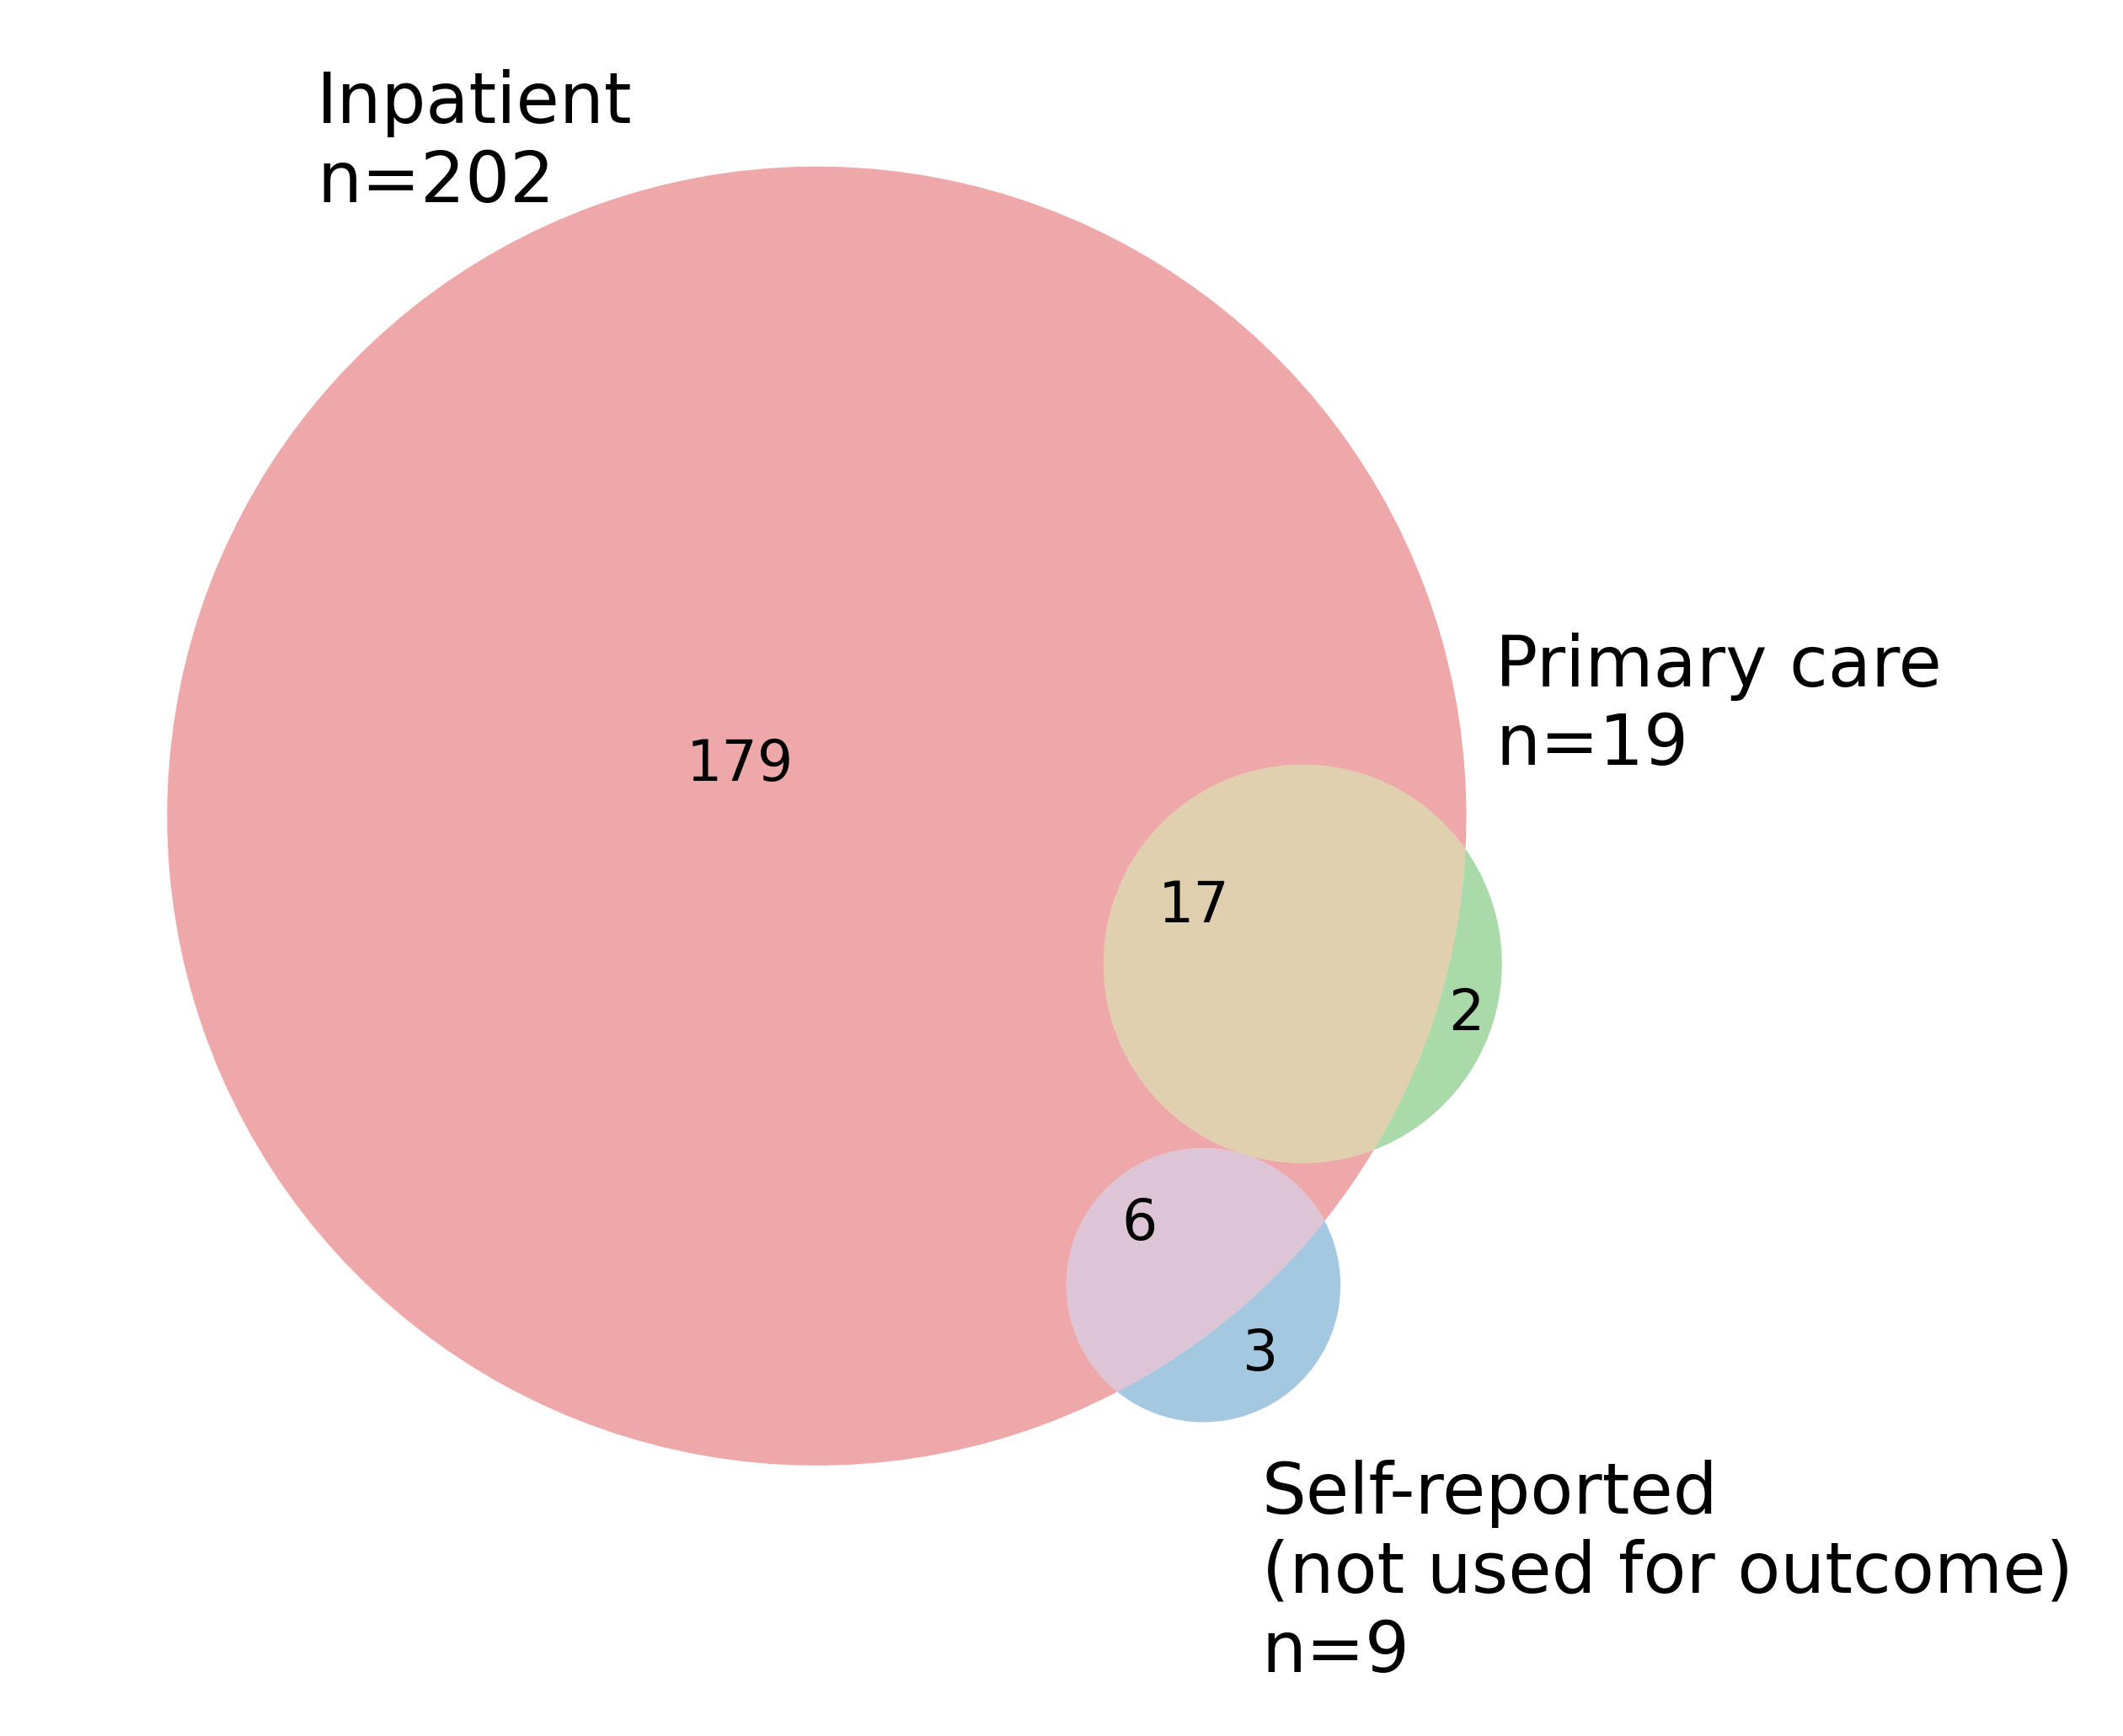

In [527]:
### Source of surgery events venn diagram (IOP subcohort)
# Self-report shown as sensitivity analysis only, not actually used for outcome

iop_cohort_progressed = diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'] == 1
iop_cohort_valid = diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'].notna()

inpatient_ids = set(diagnosis_df.loc[iop_cohort_progressed & diagnosis_df['progression_outcome_glaucoma_surg_ip'].eq('Incident')].index)
gp_ids = set(diagnosis_df.loc[iop_cohort_progressed & diagnosis_df['progression_outcome_glaucoma_surg_gp'].eq('Incident')].index)
sp_ids = set(diagnosis_df.loc[iop_cohort_valid & diagnosis_df['progression_outcome_glaucoma_surg_selfrep'].eq('Incident')].index) # can be non-progressed as not used for definition

fig, ax = plt.subplots(figsize=(15.9/2.54, 10/2.54), dpi=600)

v = venn3(
    [inpatient_ids, gp_ids, sp_ids], 
    set_labels=('Inpatient', 'Primary care', 'Self-reported\n(not used for outcome)'),
    ax = ax,
    layout_algorithm=cost_based.LayoutAlgorithm(cost_fn=cost_based.pairwise_cost),
    alpha=0.4,
    set_colors=('tab:red', 'tab:green', 'tab:blue')
)
ax.set_aspect('equal', adjustable='box')
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
ax.axis('off')

totals = [len(inpatient_ids), len(gp_ids), len(sp_ids)]
for lbl, n in zip(v.set_labels, totals):
    if lbl is not None:
        lbl.set_text(f"{lbl.get_text()}\nn={n:,}")

def nudge_set_label(v, i, dx=0.0, dy=0.0):
    # i = 0,1,2 for A,B,C
    lbl = v.set_labels[i]
    if lbl is None:
        return
    x, y = lbl.get_position()
    lbl.set_position((x + dx, y + dy))

nudge_set_label(v, 0, dx=-0.15, dy=-0.03)
nudge_set_label(v, 1, dx=0.08,  dy=0)
nudge_set_label(v, 2, dx=0.05,  dy=-0.02)


for t in v.set_labels:
    if t is not None:
        t.set_fontsize(10)
        t.set_horizontalalignment('left')

for t in v.subset_labels:
    if t is not None:
        t.set_fontsize(8)

#plt.tight_layout()
plt.savefig('./output/plots/venn_diagram_glaucoma_surgery_IOP_subcohort.png', dpi=600)
plt.show()

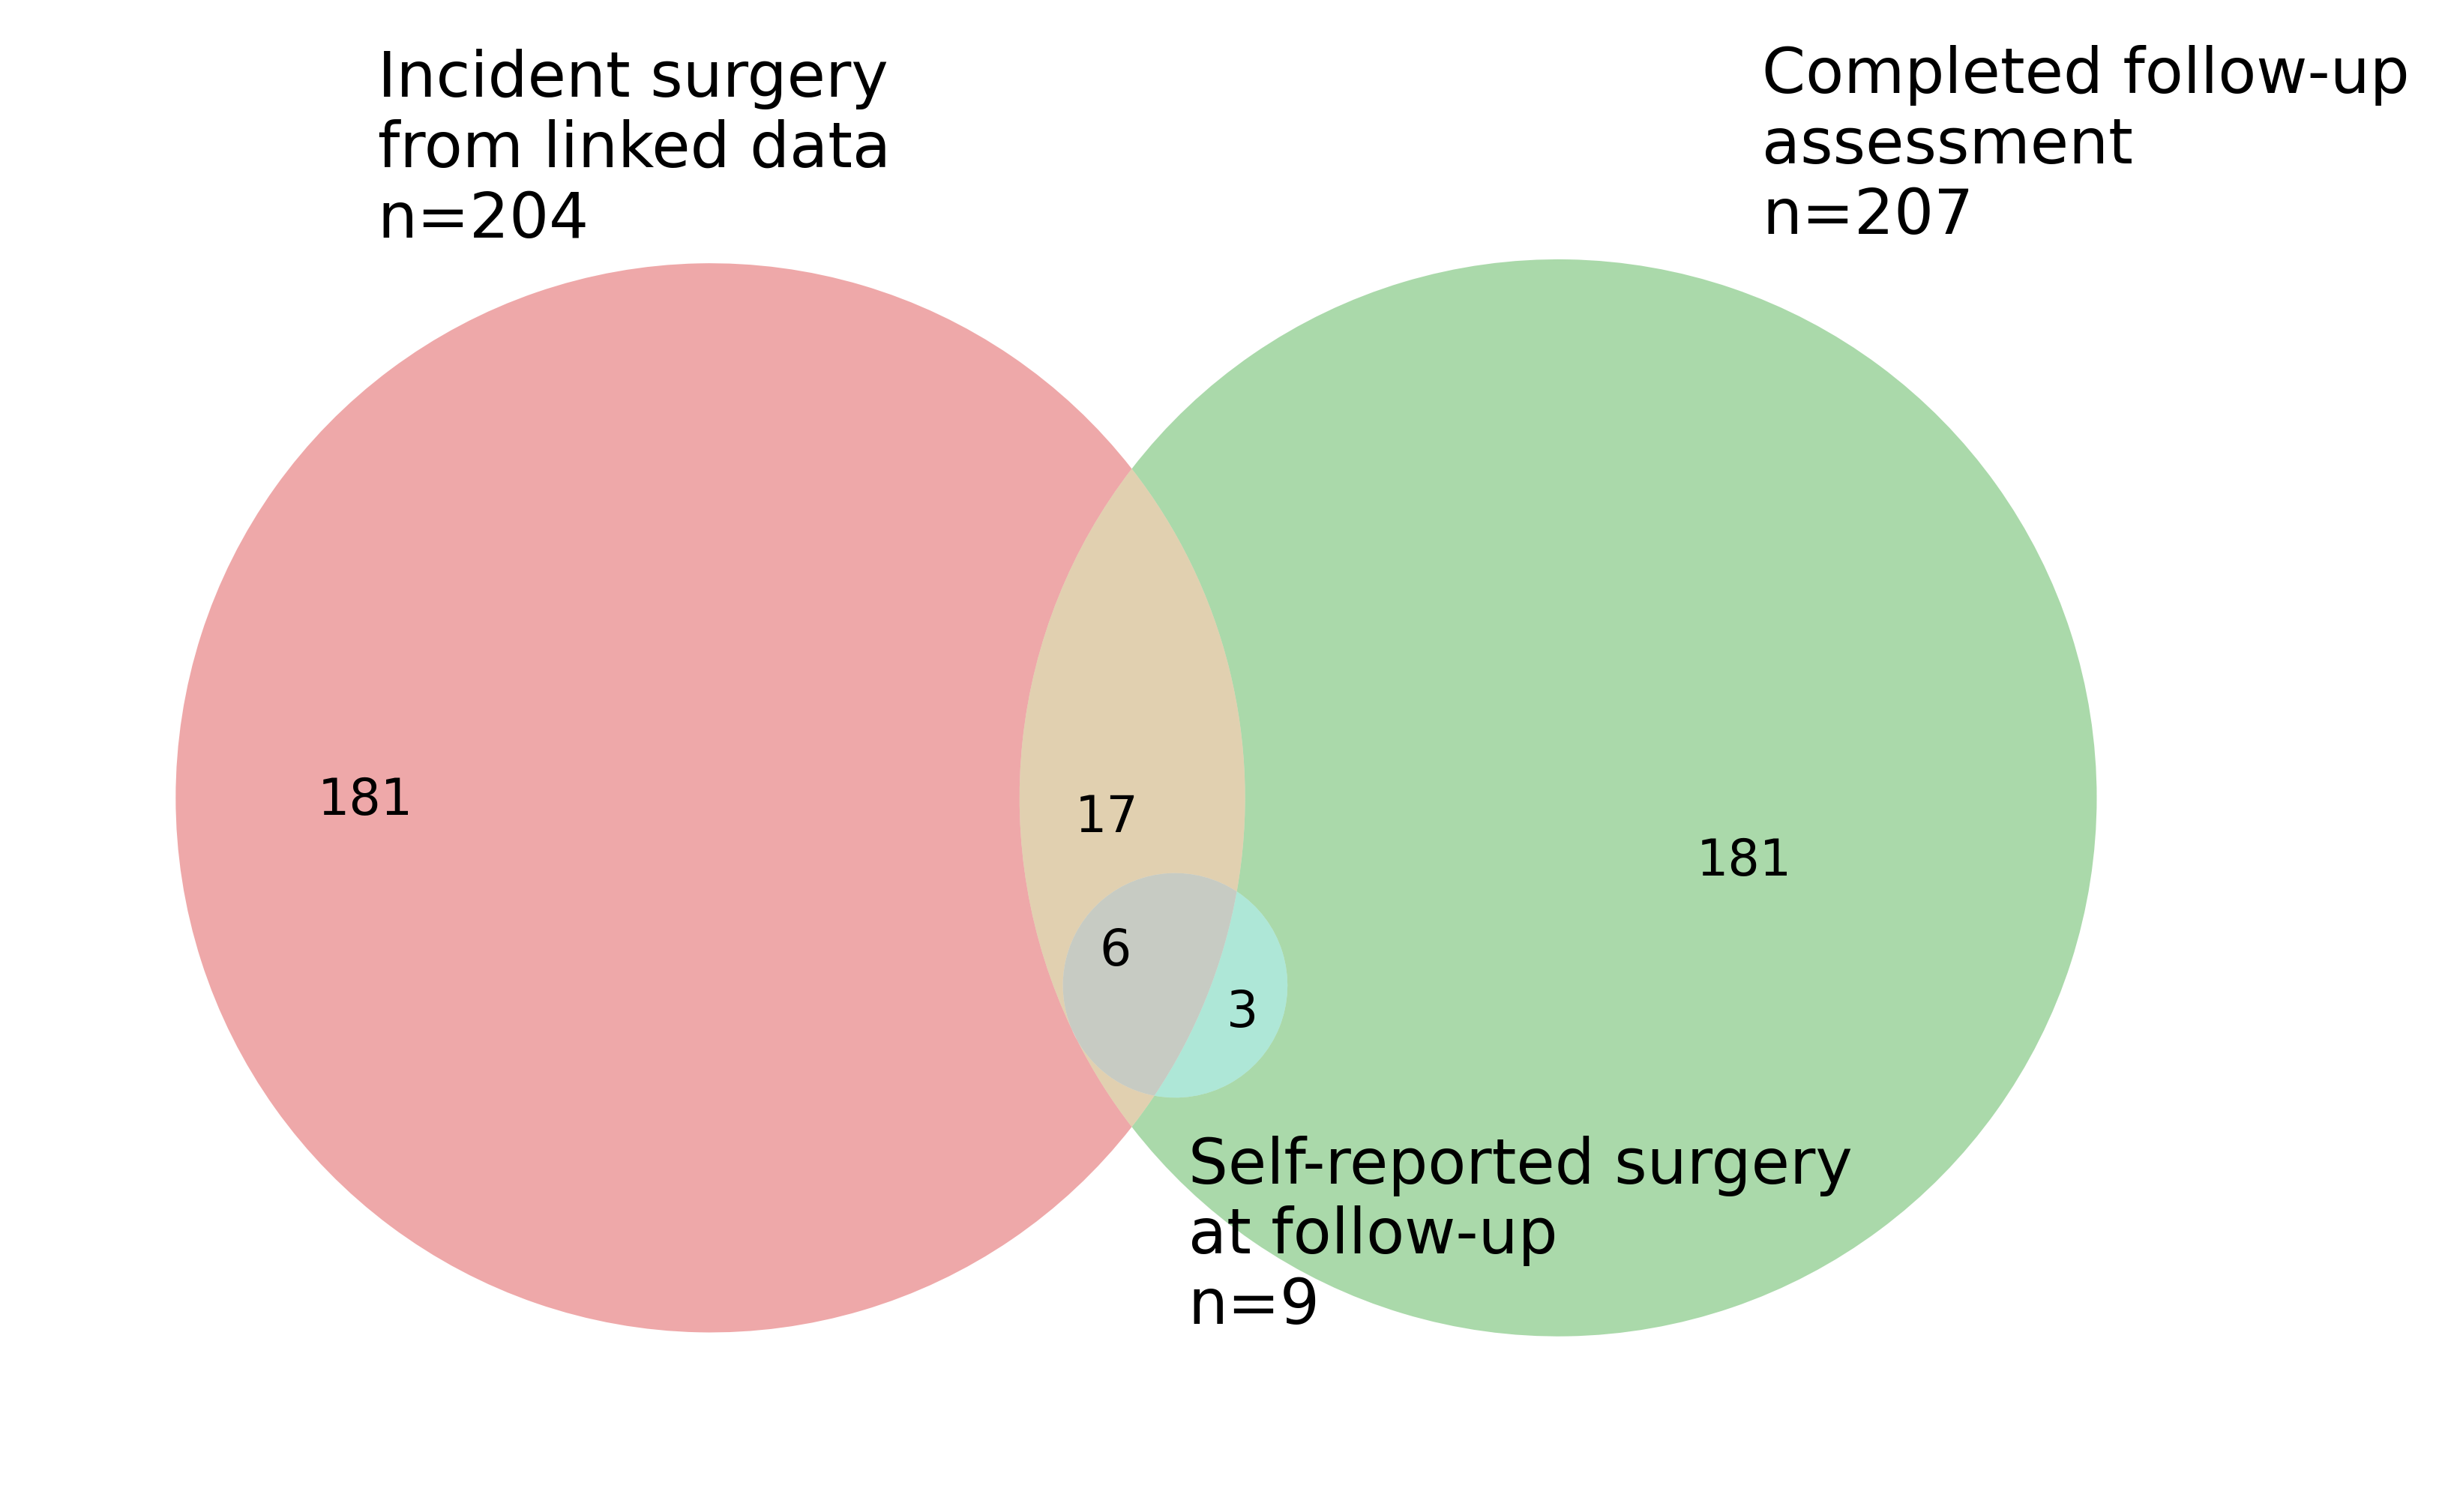

In [528]:
### Source of surgery events venn diagram (IOP subcohort)
# Self-report shown as sensitivity analysis only, not actually used for outcome

iop_cohort_valid = diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'].notna()
iop_cohort_progressed = diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'] == 1
follow_up_sp = ukb49508_df[['f.53.1.0', 'f.53.2.0', 'f.53.3.0']].notna().any(axis=1)

progressed_ids = set(diagnosis_df.loc[iop_cohort_valid & iop_cohort_progressed].index)
follow_up_ids = set(diagnosis_df.loc[iop_cohort_valid & follow_up_sp].index)
sp_ids = set(diagnosis_df.loc[iop_cohort_valid & diagnosis_df['progression_outcome_glaucoma_surg_selfrep'].eq('Incident')].index) # can be non-progressed as not used for definition

# inpatient_ids = set(diagnosis_df.loc[iop_cohort_progressed & diagnosis_df['progression_outcome_glaucoma_surg_ip'].eq('Incident')].index)
# gp_ids = set(diagnosis_df.loc[iop_cohort_progressed & diagnosis_df['progression_outcome_glaucoma_surg_gp'].eq('Incident')].index)
# sp_ids = set(diagnosis_df.loc[iop_cohort_valid & diagnosis_df['progression_outcome_glaucoma_surg_selfrep'].eq('Incident')].index) # can be non-progressed as not used for definition

fig, ax = plt.subplots(figsize=(15.9/2.54, 10/2.54), dpi=600)

v = venn3(
    [progressed_ids, follow_up_ids, sp_ids], 
    set_labels=('Incident surgery\nfrom linked data', 'Completed follow-up\nassessment', 'Self-reported surgery\nat follow-up'),
    ax = ax,
    #layout_algorithm=cost_based.LayoutAlgorithm(cost_fn=cost_based.pairwise_cost),
    alpha=0.4,
    set_colors=('tab:red', 'tab:green', 'tab:blue')
)
ax.set_aspect('equal', adjustable='box')
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
ax.axis('off')

totals = [len(progressed_ids), len(follow_up_ids), len(sp_ids)]
for lbl, n in zip(v.set_labels, totals):
    if lbl is not None:
        lbl.set_text(f"{lbl.get_text()}\nn={n:,}")

def nudge_set_label(v, i, dx=0.0, dy=0.0):
    # i = 0,1,2 for A,B,C
    lbl = v.set_labels[i]
    if lbl is None:
        return
    x, y = lbl.get_position()
    lbl.set_position((x + dx, y + dy))

nudge_set_label(v, 0, dx=-0.05, dy=0.02)
nudge_set_label(v, 1, dx=-0.05,  dy=0.02)
nudge_set_label(v, 2, dx=0.01,  dy=-0.02)

for t in v.set_labels:
    if t is not None:
        t.set_fontsize(10)
        t.set_horizontalalignment('left')
     

for t in v.subset_labels:
    if t is not None:
        t.set_fontsize(8)

plt.savefig('./output/plots/venn_diagram_selfrepsurgery_IOP_subcohort.png', dpi=600)

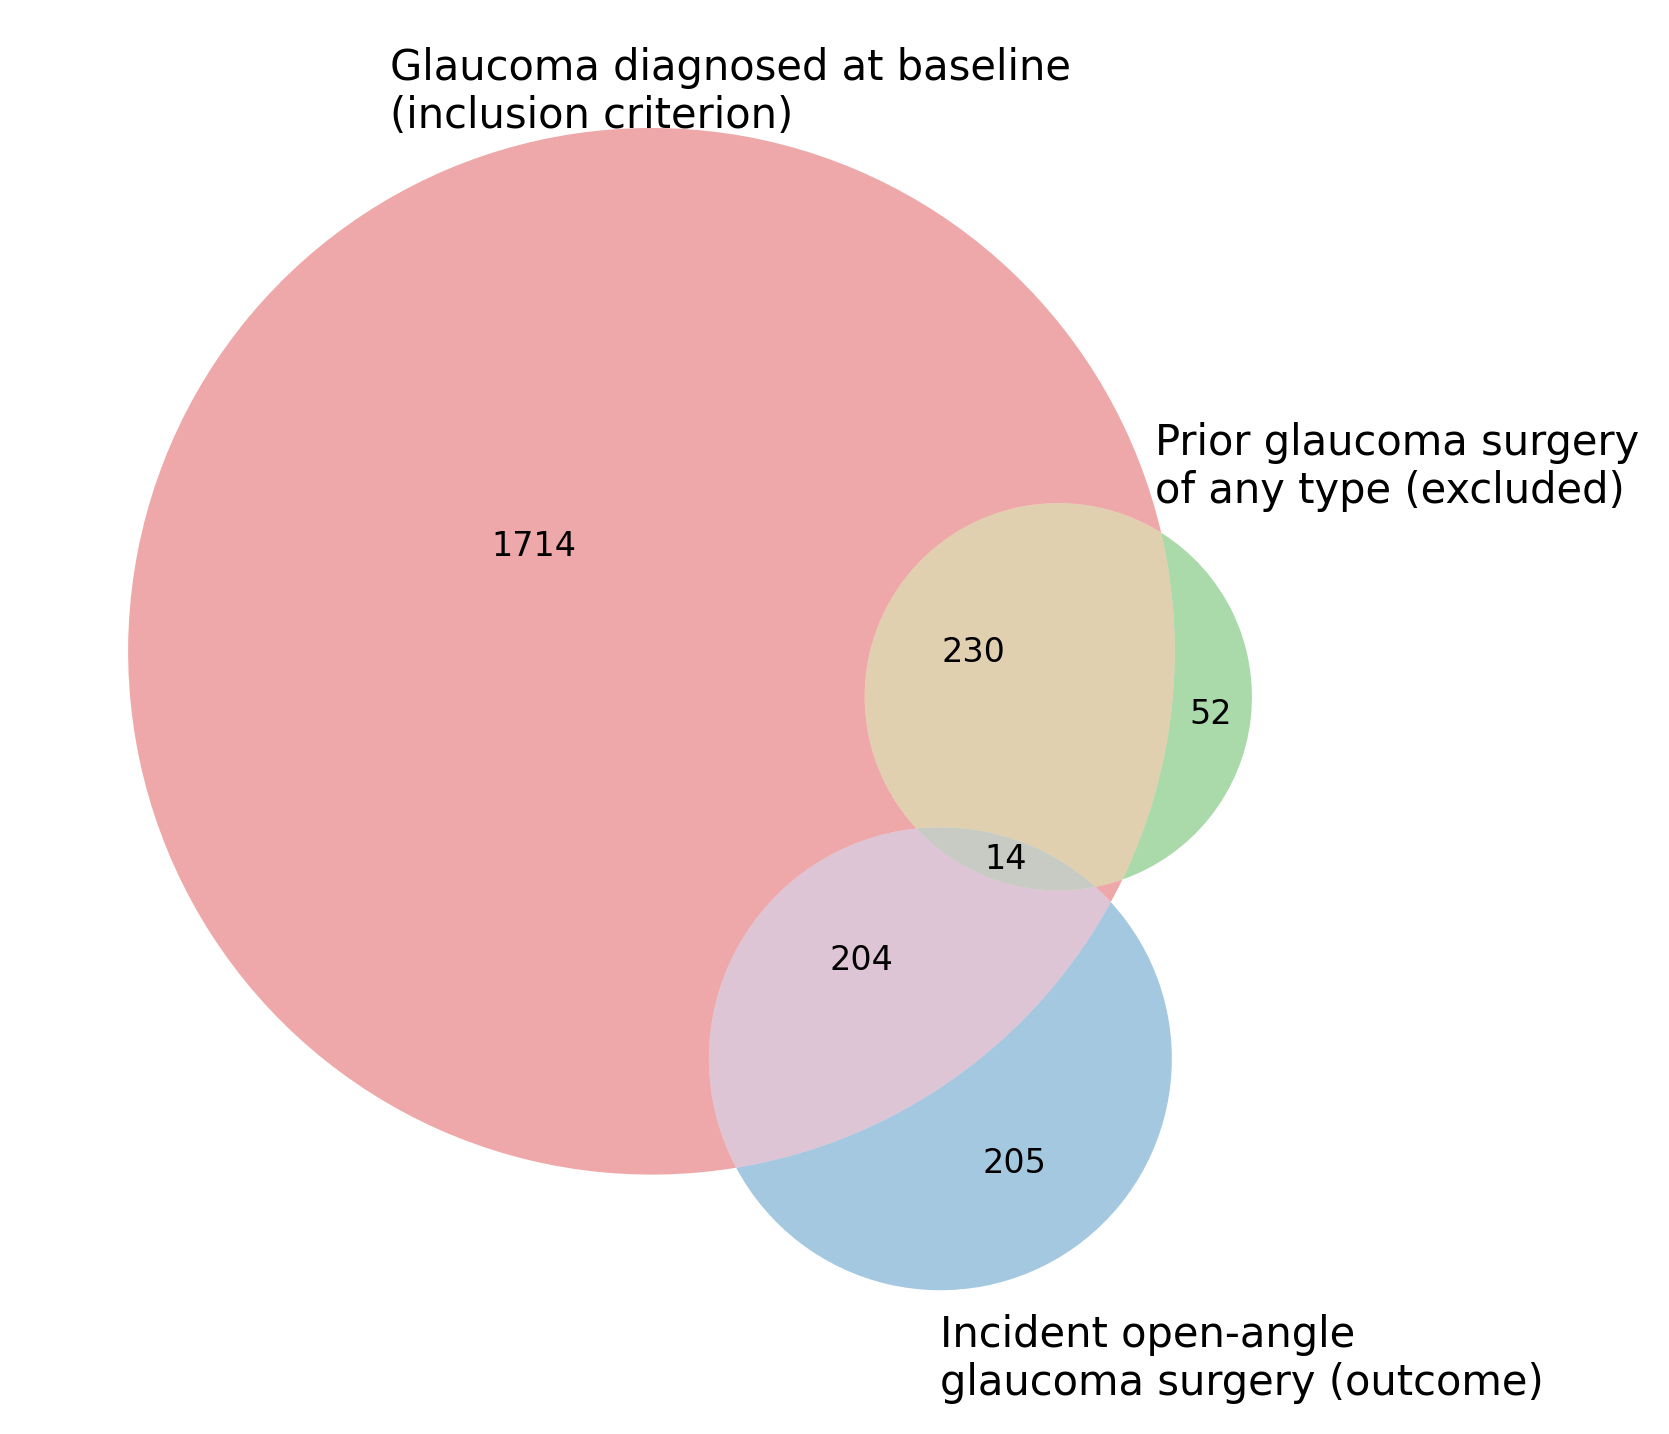

In [455]:
### Venn: glaucoma at baseline, surgery exclusion, surgery outcome
# IOP subcohort

IOP_available_mask = ~ukb51745_df[['f.5262.0.0', 'f.5254.0.0']].isna().all(axis=1)
glaucoma_dx_baseline = diagnosis_df['Baseline Glaucoma minor exclusions'] == 1
prior_surg = (diagnosis_df['progression_exclusion_glaucoma_surg_pooled'] == 'Baseline') | (diagnosis_df['progression_exclusion_glaucoma_surg_pooled'] == 'Invalid')
progressed = diagnosis_df['progression_outcome_glaucoma_surg_pooled'] == 'Incident' # some excluded

glaucoma_ids = set(diagnosis_df.loc[IOP_available_mask & glaucoma_dx_baseline].index)
prior_surg_ids = set(diagnosis_df.loc[IOP_available_mask & prior_surg].index)
progressed_ids = set(diagnosis_df.loc[IOP_available_mask & progressed].index) #\

fig, ax = plt.subplots(figsize=(15/2.54, 12.5/2.54), dpi=300)

v = venn3(
    [glaucoma_ids, prior_surg_ids, progressed_ids], 
    set_labels=('Glaucoma diagnosed at baseline\n(inclusion criterion)', 'Prior glaucoma surgery\nof any type (excluded)', 'Incident open-angle\nglaucoma surgery (outcome)'),
    ax = ax,
    layout_algorithm=cost_based.LayoutAlgorithm(cost_fn=cost_based.pairwise_cost),
    alpha=0.4,
    set_colors=('tab:red', 'tab:green', 'tab:blue')
)

for t in v.set_labels:
    if t is not None:
        t.set_fontsize(10)
        t.set_horizontalalignment('left')
     

for t in v.subset_labels:
    if t is not None:
        t.set_fontsize(8)


# def nudge_set_label(v, i, dx=0.0, dy=0.0):
#     # i = 0,1,2 for A,B,C
#     lbl = v.set_labels[i]
#     if lbl is None:
#         return
#     x, y = lbl.get_position()
#     lbl.set_position((x + dx, y + dy))

# nudge_set_label(v, 0, dx=-0.15, dy=-0.03)
# nudge_set_label(v, 1, dx=0.08,  dy=0)
# nudge_set_label(v, 2, dx=0.05,  dy=-0.02)


plt.tight_layout()
plt.show()

### N by outcome code (among included participants)
N may be greater than total number of incident surgeries, as one individual can have multiple procedures (only the first is counted as the outcome)

Incident events

In [ ]:
cohort = diagnosis_df['Progression to glaucoma surgery'].notna()

opcs4_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='opcs4_inpatient')
opcs3_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='opcs3_inpatient')
opcs4_codes = opcs4_codes_df['Code'].astype(str).values.tolist()
opcs3_codes = opcs3_codes_df['Code'].astype(str).values.tolist()

read_v3_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='read_v3')
read_v2_codes_df = pd.read_excel('./codes/progression_surgery_codes_outcomes.xlsx', sheet_name='read_v2')
read_v3_codes = read_v3_codes_df['Code'].astype(str).values.tolist()
read_v2_codes = read_v2_codes_df['Code'].astype(str).values.tolist()

invalid_gp_dates = [
    pd.to_datetime('01/01/1901', format='%d/%m/%Y'), # precedes DOB
    pd.to_datetime('02/02/1902', format='%d/%m/%Y'), # matches DOB
    pd.to_datetime('03/03/1903', format='%d/%m/%Y'), # follows DOB, but is in year of birth
    pd.to_datetime('07/07/2037', format='%d/%m/%Y') # dated in the future meaning system default / placeholder
]


In [105]:
#### N by code, for OPCS4

counts_df = (
    pd.DataFrame({"Code": opcs4_codes_df['Code'].astype(str).values, 'Description': opcs4_codes_df['Description'].values, "N individuals": 0, 'N reports': 0, 'N invalid date': 0})
    .set_index("Code")
)

for c in opcs4_codes:
    feid_set = set()
    for dx_col, date_col in zip(OPCS4_inpatient_operation_cols, OPCS4_inpatient_operation_date_cols):
        dx_mask = ukb49508_df[dx_col] == c
        incident_mask = ukb49508_df[date_col] > ukb49508_df['f.53.0.0']

        feid_set.update(ukb49508_df[cohort & dx_mask & incident_mask]['f.eid'])

        counts_df.loc[c, 'N reports'] += (cohort & dx_mask & incident_mask).sum()
        counts_df.loc[c, 'N invalid date'] += (cohort & dx_mask & (ukb49508_df[date_col].isnull())).sum()

    counts_df.loc[c, 'N individuals'] = len(feid_set)

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                     
C601                               C60.1 Trabeculectomy            645   
C605  C60.5 Insertion of tube into anterior chamber ...            194   
C522              C52.2 Deep sclerectomy without spacer             43   
C618  C61.8 Other specified other operations on trab...             35   
C606                             C60.6 Viscocanulostomy             34   
C521                 C52.1 Deep sclerectomy with spacer              8   
C619  C61.9 Unspecified other operations on trabecul...              0   

      N reports  N invalid date  
Code                             
C601        645               0  
C605        194               0  
C522         43               0  
C618         35               0  
C606         34               0  
C521          8               0  
C619          0               0

In [106]:
#### N by code, for OPCS3
counts_df = (
    pd.DataFrame({"Code": opcs3_codes_df['Code'].astype(str).values, 'Description': opcs3_codes_df['Description'].values, "N individuals": 0, 'N reports': 0})
    .set_index("Code")
)

for c in opcs3_codes:
    feid_set = set()
    for dx_col, date_col in zip(OPCS3_inpatient_operation_cols, OPCS3_inpatient_operation_date_cols):
        dx_mask = ukb49508_df[dx_col] == c
        incident_mask = ukb49508_df[date_col] > ukb49508_df['f.53.0.0']

        feid_set.update(ukb49508_df[cohort & dx_mask & incident_mask]['f.eid'])

        counts_df.loc[c, 'N reports'] += (cohort & dx_mask & incident_mask).sum()

    counts_df.loc[c, 'N individuals'] = len(feid_set)

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                     
1574  157.4 Destruction of ciliary body : trabeculec...              0   
161           161 Sclerectomy, not elsewhere classified              0   
162         162 Corneo-scleral trephine and  sclerotomy              0   

      N reports  
Code             
1574          0  
161           0  
162           0

In [107]:
#### N by code, for Readv3

counts_df = (
    pd.DataFrame({"Code": read_v3_codes_df['Code'].astype(str).values, 'Description': read_v3_codes_df['Description'].values, "N individuals": 0, 'N reports': 0, 'N invalid date': 0})
    .set_index("Code")
)

gp_cohort_mask = merged_gp_events_df['f.eid'].isin(diagnosis_df.loc[cohort, 'f.eid'])
incident = merged_gp_events_df['event_dt'] > merged_gp_events_df['f.53.0.0']
invalid =  merged_gp_events_df['event_dt'].isnull() | merged_gp_events_df['event_dt'].isin(invalid_gp_dates)
valid_mask = gp_cohort_mask & incident & ~invalid

feid = merged_gp_events_df["f.eid"].to_numpy(copy=False)

for c in read_v3_codes:
    any_dx = merged_gp_events_df['read_3'].eq(c) 
    dx = any_dx & valid_mask
    n_reports = dx.sum()
    n_individuals = merged_gp_events_df.loc[dx, 'f.eid'].drop_duplicates().shape[0]

    counts_df.loc[c, 'N reports'] = n_reports
    counts_df.loc[c, 'N individuals'] = n_individuals

    invalid_mask = any_dx & gp_cohort_mask &incident & invalid
    counts_df.loc[c, 'N invalid date'] = invalid_mask.sum()

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                      
72550  Creation of guarded fistula to sclera (OPCS4 C...             81   
XSAON                                        Sclerectomy              2   
XaE6n                                  Stegman procedure              2   
X00XI  Cataract extraction, insertion of intraocular ...              2   
XaKb1  Trabeculectomy with intraoperative application...              2   
XaE6n                                   Viscocanulostomy              2   
XaL4t                       Deep sclerectomy with spacer              1   
Xa3mu                         Intraocular tension relief              1   
Xa3mu                          Glaucoma drainage surgery              1   
724A0                       Deep sclerectomy with spacer              0   
X00Wp                        Scheie's cautery sclerotomy              0   
XaL4u                    Deep sclerectomy without spacer              0   
724A1                    Deep sclerectomy without spacer              0   
724A.                                        Sclerectomy              0   
XaKb3               Trabeculectomy with beta-irradiation              0   
XE0Km                  (Iridectomy) or (trabeculectomy)               0   
XE0Ko                     (Iridotomy) or (trabeculotomy)              0   
72551                                      Iridencleisis              0   
XE0BJ                Trephining of sclera and iridectomy              0   
72523         Elliot trephining of sclera and iridectomy              0   
XaKaz  Trabeculectomy with intraoperative application...              0   
72521                             Corneoscleral trephine              0   
72554  Insertion of Molteno implantation tube into an...              0   
72554  Insertion of tube into anterior chamber of eye...              0   
72554  Insertion anterior chamber drainage tube (& Mo...              0   
Xa9R5                     Anterior chamber drainage tube              0   
X00Ws   Insertion of Schocket tube into anterior chamber              0   
XE0BN   Insertion of drainage tube into anterior chamber              0   
X00Wr    Insertion of Molteno tube into anterior chamber              0   
XaJdX  Insertion of Baerveldt tube into anterior chamber              0   
72557                                  Stegman procedure              0   
72555                                  Stegman procedure              0   
Xa3mt                 Intraocular circulation operations              0   
XE0Kk                          Glaucoma relief operation              0   
X00X4                      Trabecular meshwork operation              0   
7256z  Other operation on trabecular meshwork of eye NOS              0   
7256y  Other specified other operation on trabecular ...              0   
7256.     Other operations on trabecular meshwork of eye              0   

       N reports  N invalid date  
Code                              
72550        107               0  
XSAON          3               0  
XaE6n          2               0  
X00XI          2               0  
XaKb1          2               0  
XaE6n          2               0  
XaL4t          1               0  
Xa3mu          1               0  
Xa3mu          1               0  
724A0          0               0  
X00Wp          0               0  
XaL4u          0               0  
724A1          0               0  
724A.          0               0  
XaKb3          0               0  
XE0Km          0               0  
XE0Ko          0               0  
72551          0               0  
XE0BJ          0               0  
72523          0               0  
XaKaz          0               0  
72521          0               0  
72554          0               0  
72554          0               0  
72554          0               0  
Xa9R5          0               0  
X00Ws          0               0  
XE0BN          0             

In [108]:
#### N by code, for Readv2

counts_df = (
    pd.DataFrame({"Code": read_v2_codes_df['Code'].astype(str).values, 'Description': read_v2_codes_df['Description'].values, "N individuals": 0, 'N reports': 0, 'N invalid date': 0})
    .set_index("Code")
)

gp_cohort_mask = merged_gp_events_df['f.eid'].isin(diagnosis_df.loc[cohort, 'f.eid'])
incident = merged_gp_events_df['event_dt'] > merged_gp_events_df['f.53.0.0']
invalid =  merged_gp_events_df['event_dt'].isnull() | merged_gp_events_df['event_dt'].isin(invalid_gp_dates)
valid_mask = gp_cohort_mask & incident & ~invalid

feid = merged_gp_events_df["f.eid"].to_numpy(copy=False)

for c in read_v2_codes:
    any_dx = merged_gp_events_df['read_2'].eq(c) 
    dx = any_dx & valid_mask
    n_reports = dx.sum()
    n_individuals = merged_gp_events_df.loc[dx, 'f.eid'].drop_duplicates().shape[0]

    counts_df.loc[c, 'N reports'] = n_reports
    counts_df.loc[c, 'N individuals'] = n_individuals

    invalid_mask = any_dx & gp_cohort_mask &incident & invalid
    counts_df.loc[c, 'N invalid date'] = invalid_mask.sum()

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                      
72550                                     Trabeculectomy             48   
72555                                   Viscocanulostomy              1   
724A0                       Deep sclerectomy with spacer              0   
72521                             Corneoscleral trephine              0   
724A1                    Deep sclerectomy without spacer              0   
72523                Trephining of sclera and iridectomy              0   
72554  Insertion of tube into anterior chamber of eye...              0   
72557                                   Viscocanalostomy              0   
7256y  Other specified other operation on trabecular ...              0   
7256z  Other operation on trabecular meshwork of eye NOS              0   
7256.     Other operations on trabecular meshwork of eye              0   

       N reports  N invalid date  
Code                              
72550         73               0  
72555          1               0  
724A0          0               0  
72521          0               0  
724A1          0               0  
72523          0               0  
72554          0               0  
72557          0               0  
7256y          0               0  
7256z          0               0  
7256.          0               0

### N by exclusion code (among excluded participants)
N may be greater than total number of incident surgeries, as one individual can have multiple procedures (only the first is counted as the outcome)

Baseline events only

In [109]:
glaucoma_dx_baseline = diagnosis_df['Baseline Glaucoma minor exclusions'] == 1
cohort = diagnosis_df['Progression to glaucoma surgery'].isna() & glaucoma_dx_baseline

opcs4_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='opcs4_inpatient')
opcs3_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='opcs3_inpatient')
opcs4_codes = opcs4_codes_df['Code'].astype(str).values.tolist()
opcs3_codes = opcs3_codes_df['Code'].astype(str).values.tolist()

read_v3_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='read_v3')
read_v2_codes_df = pd.read_excel('./codes/progression_surgery_codes_exclusions.xlsx', sheet_name='read_v2')
read_v3_codes = read_v3_codes_df['Code'].astype(str).values.tolist()
read_v2_codes = read_v2_codes_df['Code'].astype(str).values.tolist()

invalid_gp_dates = [
    pd.to_datetime('01/01/1901', format='%d/%m/%Y'), # precedes DOB
    pd.to_datetime('02/02/1902', format='%d/%m/%Y'), # matches DOB
    pd.to_datetime('03/03/1903', format='%d/%m/%Y'), # follows DOB, but is in year of birth
    pd.to_datetime('07/07/2037', format='%d/%m/%Y') # dated in the future meaning system default / placeholder
]


In [110]:
#### N by code, for OPCS4

counts_df = (
    pd.DataFrame({"Code": opcs4_codes_df['Code'].astype(str).values, 'Description': opcs4_codes_df['Description'].values, "N individuals": 0, 'N reports': 0, 'N invalid date': 0})
    .set_index("Code")
)

for c in opcs4_codes:
    feid_set = set()
    for dx_col, date_col in zip(OPCS4_inpatient_operation_cols, OPCS4_inpatient_operation_date_cols):
        dx_mask = ukb49508_df[dx_col] == c
        incident_mask = ukb49508_df[date_col] <= ukb49508_df['f.53.0.0']

        feid_set.update(ukb49508_df[cohort & dx_mask & incident_mask]['f.eid'])

        counts_df.loc[c, 'N reports'] += (cohort & dx_mask & incident_mask).sum()
        counts_df.loc[c, 'N invalid date'] += (cohort & dx_mask & (ukb49508_df[date_col].isnull())).sum()

    counts_df.loc[c, 'N individuals'] = len(feid_set)

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                     
C601                               C60.1 Trabeculectomy            431   
C623                              C62.3 Laser iridotomy            209   
C608  C60.8 Other specified filtering operations on ...             71   
C664       C66.4 Laser photocoagulation of ciliary body             59   
C651                             C65.1 Needling of bleb             29   
C618  C61.8 Other specified other operations on trab...             28   
C605  C60.5 Insertion of tube into anterior chamber ...             26   
C619  C61.9 Unspecified other operations on trabecul...             25   
C612                                C61.2 Trabeculotomy             14   
C663                  C66.3 Cryotherapy to ciliary body             11   
C652                            C65.2 Injection of bleb              8   
C522              C52.2 Deep sclerectomy without spacer              8   
C658  C65.8 Other specified operations following gla...              7   
C653                         C65.3 Revision of bleb NEC              6   
C671                   C67.1 Separation of ciliary body              6   
C609     C60.9 Unspecified filtering operations on iris              5   
C521                 C52.1 Deep sclerectomy with spacer              4   
C604                              C60.4 Iridoplasty NEC              3   
C662                C66.2 Cauterisation of ciliary body              3   
C606                             C60.6 Viscocanulostomy              3   
C654  C65.4 Removal of releasable suture following g...              3   
C622                           C62.2 Surgical iridotomy              2   
C668  C66.8 Other specified extirpation of ciliary body              1   
C603                             C60.3 Fixation of iris              0   
C602                            C60.2 Inclusion of iris              0   
C613                                    C61.3 Goniotomy              0   
C614                                C61.4 Goniopuncture              0   
C659  C65.9 Unspecified operations following glaucom...              0   
C655  C65.5 Laser suture lysis following glaucoma su...              0   
C615                             C61.5 Viscogonioplasty              0   
C621                              C62.1 Iridosclerotomy              0   
C678  C67.8 Other specified other operations on cili...              0   
C669      C66.9 Unspecified extirpation of ciliary body              0   
C665              C66.5 Destruction of ciliary body NEC              0   
C679  C67.9 Unspecified other operations on ciliary ...              0   

      N reports  N invalid date  
Code                             
C601        431               0  
C623        209               0  
C608         71               0  
C664         59               0  
C651         29               0  
C618         28               0  
C605         26               0  
C619         25               0  
C612         14               0  
C663         11               0  
C652          8               0  
C522          8               0  
C658          7               0  
C653          6               0  
C671          6               0  
C609          5               0  
C521          4               0  
C604          3               0  
C662          3               0  
C606          3               0  
C654          3               0  
C622          2               0  
C668          1               0  
C603          0               0  
C602          0               0  
C613          0               0  
C614          0               0  
C659          0               0  
C655          0               0  
C615          0               0  
C621          0               0  
C678          0               0  
C669          0               0  
C665          0               0  
C679          0               0

In [111]:
#### N by code, for OPCS3
counts_df = (
    pd.DataFrame({"Code": opcs3_codes_df['Code'].astype(str).values, 'Description': opcs3_codes_df['Description'].values, "N individuals": 0, 'N reports': 0})
    .set_index("Code")
)

for c in opcs3_codes:
    feid_set = set()
    for dx_col, date_col in zip(OPCS3_inpatient_operation_cols, OPCS3_inpatient_operation_date_cols):
        dx_mask = ukb49508_df[dx_col] == c
        incident_mask = ukb49508_df[date_col] <= ukb49508_df['f.53.0.0']

        feid_set.update(ukb49508_df[cohort & dx_mask & incident_mask]['f.eid'])

        counts_df.loc[c, 'N reports'] += (cohort & dx_mask & incident_mask).sum()

    counts_df.loc[c, 'N individuals'] = len(feid_set)

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                     
1574  157.4 Destruction of ciliary body : trabeculec...              4   
1512                    151.2 Iridectomy : for glaucoma              1   
156                                   156 Cyclodialysis              1   
1517                             Iridectomy : bilateral              1   
1502                  150.2 Iridotomy : iridosclerotomy              0   
150                                       150 Irodotomy              0   
153            153 Iridoplasty and filtering operations              0   
1573      157.3 Destruction of ciliary body : goniotomy              0   
161           161 Sclerectomy, not elsewhere classified              0   
162          162 Corneo-scleral trephine and sclerotomy              0   

      N reports  
Code             
1574          4  
1512          1  
156           1  
1517          1  
1502          0  
150           0  
153           0  
1573          0  
161           0  
162           0

In [112]:
#### N by code, for Readv3

counts_df = (
    pd.DataFrame({"Code": read_v3_codes_df['Code'].astype(str).values, 'Description': read_v3_codes_df['Description'].values, "N individuals": 0, 'N reports': 0, 'N invalid date': 0})
    .set_index("Code")
)

gp_cohort_mask = merged_gp_events_df['f.eid'].isin(diagnosis_df.loc[cohort, 'f.eid'])
incident = merged_gp_events_df['event_dt'] <= merged_gp_events_df['f.53.0.0']
invalid =  merged_gp_events_df['event_dt'].isnull() | merged_gp_events_df['event_dt'].isin(invalid_gp_dates)
valid_mask = gp_cohort_mask & incident & ~invalid

feid = merged_gp_events_df["f.eid"].to_numpy(copy=False)

for c in read_v3_codes:
    any_dx = merged_gp_events_df['read_3'].eq(c) 
    dx = any_dx & valid_mask
    n_reports = dx.sum()
    n_individuals = merged_gp_events_df.loc[dx, 'f.eid'].drop_duplicates().shape[0]

    counts_df.loc[c, 'N reports'] = n_reports
    counts_df.loc[c, 'N individuals'] = n_individuals

    invalid_mask = any_dx & gp_cohort_mask &incident & invalid
    counts_df.loc[c, 'N invalid date'] = invalid_mask.sum()

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                      
72550  Creation of guarded fistula to sclera (OPCS4 C...            165   
72572                         YAG laser iridotomy (C623)             76   
72572                             Laser iridotomy (C623)             76   
72561                                      Trabeculotomy              8   
X00Wu                   Iridotomy NEC (C621, C622, C623)              7   
...                                                  ...            ...   
XE0Kk                          Glaucoma relief operation              0   
Xa3mu                          Glaucoma drainage surgery              0   
Xa3mu                         Intraocular tension relief              0   
Xa3mt                 Intraocular circulation operations              0   
X00X4                      Trabecular meshwork operation              0   

       N reports  N invalid date  
Code                              
72550        297               1  
72572         96               0  
72572         96               0  
72561          8               0  
X00Wu          7               0  
...          ...             ...  
XE0Kk          0               0  
Xa3mu          0               0  
Xa3mu          0               0  
Xa3mt          0               0  
X00X4          0               0  

[111 rows x 4 columns]

In [113]:
#### N by code, for Readv2

counts_df = (
    pd.DataFrame({"Code": read_v2_codes_df['Code'].astype(str).values, 'Description': read_v2_codes_df['Description'].values, "N individuals": 0, 'N reports': 0, 'N invalid date': 0})
    .set_index("Code")
)

gp_cohort_mask = merged_gp_events_df['f.eid'].isin(diagnosis_df.loc[cohort, 'f.eid'])
incident = merged_gp_events_df['event_dt'] <= merged_gp_events_df['f.53.0.0']
invalid =  merged_gp_events_df['event_dt'].isnull() | merged_gp_events_df['event_dt'].isin(invalid_gp_dates)
valid_mask = gp_cohort_mask & incident & ~invalid

feid = merged_gp_events_df["f.eid"].to_numpy(copy=False)

for c in read_v2_codes:
    any_dx = merged_gp_events_df['read_2'].eq(c) 
    dx = any_dx & valid_mask
    n_reports = dx.sum()
    n_individuals = merged_gp_events_df.loc[dx, 'f.eid'].drop_duplicates().shape[0]

    counts_df.loc[c, 'N reports'] = n_reports
    counts_df.loc[c, 'N individuals'] = n_individuals

    invalid_mask = any_dx & gp_cohort_mask &incident & invalid
    counts_df.loc[c, 'N invalid date'] = invalid_mask.sum()

counts_df = counts_df.sort_values("N individuals", ascending=False)
counts_df

Description  N individuals  \
Code                                                                      
72550                                     Trabeculectomy             56   
72572                             Laser iridotomy (C623)             27   
72571                               Iridotomy NEC (C622)              8   
72571                          Surgical iridotomy (C622)              8   
72561                                      Trabeculotomy              3   
72551                                  Inclusion of iris              1   
72553                             Iridoplasty NEC (C604)              1   
72610                               Cyclodialysis (C671)              1   
72610                  Separation of ciliary body (C671)              1   
7257.                            Incision of iris (C622)              1   
72603      Laser photocoagulation of ciliary body (C664)              1   
72570                             Iridosclerotomy (C621)              0   
72564                            Viscogonioplasty (C615)              0   
72563                        Barkan goniopuncture (C614)              0   
72552                            Fixation of iris (C603)              0   
72563                               Goniopuncture (C614)              0   
7255y  Other specified filtering operation on iris (C...              0   
7255z             Filtering operation on iris NOS (C609)              0   
7255.                Filtering operations on iris (C609)              0   
72591  Injection of bleb following glaucoma surgery (...              0   
72590  Needling of bleb following glaucoma surgery (C...              0   
7259.              Operations following glaucoma surgery              0   
7257y                   Other specified incision of iris              0   
7257z                               Incision of iris NOS              0   
72593  Removal of releasable suture following glaucom...              0   
7259z   Operations following glaucoma surgery NOS (C659)              0   
72592  Revision of bleb NEC following glaucoma surger...              0   
72601                 Cryotherapy to ciliary body (C663)              0   
72600               Cauterisation of ciliary body (C662)              0   
7260.                        Extirpation of ciliary body              0   
72604             Destruction of ciliary body NEC (C665)              0   
7260y  Other specified extirpation of ciliary body (C...              0   
72605       Transcleral diode laser cycloablation (C664)              0   
72594  Laser suture lysis following glaucoma surgery ...              0   
7259y  Other specified operations following glaucoma ...              0   
7261y  Other specified other operation on ciliary bod...              0   
7260z             Extirpation of ciliary body NOS (C669)              0   
72562                                          Goniotomy              0   
7261z         Other operation on ciliary body NOS (C679)              0   
724A0                       Deep sclerectomy with spacer              0   
724A1                    Deep sclerectomy without spacer              0   
72521                             Corneoscleral trephine              0   
72556                         Revision of trabeculectomy              0   
72523                Trephining of sclera and iridectomy              0   
72554  Insertion of tube into anterior chamber of eye...              0   
72555                                   Viscocanulostomy              0   
72557                                   Viscocanalostomy              0   
7256.     Other operations on trabecular meshwork of eye              0   
7256y  Other specified other operation on trabecular ...              0   
7256z  Other operation on trabecular meshwork of eye NOS              0   
7256.     Other operations on trabecular meshwork of eye              0   

       N reports  N invalid date  
Code                              

### Overlap between incident surgery self-report vs linked

In [114]:
# Denominator: included in study, may or may not have incident surgery
cohort_mask = diagnosis_df['Progression to glaucoma surgery'].notna() & glaucoma_dx_baseline

# Excluded mask
cohort_excluded_mask = diagnosis_df['Progression to glaucoma surgery'].isna() & glaucoma_dx_baseline

# Outcome (incident surgery from inpatient or GP; self report NOT used to define outcome)
incident_surgery_mask = cohort_mask & diagnosis_df['Progression to glaucoma surgery'].eq(1)

# Self-reported follow-up data available
follow_up_mask = cohort_mask & (ukb49508_df[['f.53.1.0', 'f.53.2.0', 'f.53.3.0']].notna().any(axis=1))

# Incident self-reported surgery at follow-up (not included in outocme)
incident_surgery_fu_mask = diagnosis_df['progression_outcome_glaucoma_surg_selfrep'].eq('Incident') & cohort_mask & follow_up_mask

In [115]:
# N with incident surgery
incident_surgery_mask.sum()

np.int64(873)

In [116]:
# N with self-report FU data
follow_up_mask.sum()

np.int64(714)

In [117]:
# N with incident surgery who had self-report FU data
(incident_surgery_mask & follow_up_mask).sum()

np.int64(106)

In [118]:
# N with incident surgery, who also self-reported surgery at follow-up
(incident_surgery_mask & incident_surgery_fu_mask).sum()

np.int64(34)

In [119]:
# N with incident surgery, who DID NOT self-report surgery at follow-up
# (May be because the FU timepoint before surgery date)
(incident_surgery_mask & follow_up_mask & ~incident_surgery_fu_mask).sum()

np.int64(72)

In [120]:
# N with NO incident surgery, who DID self-report surgery at follow-up
# Implies not captured by inpatient/GP data
(~incident_surgery_mask & incident_surgery_fu_mask).sum()

np.int64(15)

In [121]:
# Of the N above, did any develop incident "exclusion" surgery (suggesting the self-report may be for PACG surgery etc?)
display((~incident_surgery_mask & incident_surgery_fu_mask & diagnosis_df['progression_exclusion_glaucoma_surg_ip'].eq('Incident')).sum())
display((~incident_surgery_mask & incident_surgery_fu_mask & diagnosis_df['progression_exclusion_glaucoma_surg_gp'].eq('Incident')).sum())

np.int64(3)

np.int64(0)

# Cataract

In [78]:
# Cataract

f6148_codes = [4]
f20002_codes = [1278]
age_diagnosed_self_report_field = '4700'
read_v2_codes = ["F462.","F4620","F4621","F4622","F4623","F462z","F464.","F4643","F4644","F4645","F4646","F4647","F464z","F465.","F4650","F4651","F4652","F4653","F4655","F465z","F466.","F46y.","F46y0","F46yz","F46z.","F46..","F460.","F4600","F4601","F4602","F4603","F4604","F4605","F4606","F4607","F460x","F460y","F460z","F4610","F4611","F4613","F4614","F4615","F4616","F4617","F4618","F4619","F461A","F461B","F461x","F461y","F461z","F462.","F463.","F4630","F4631","F4632","F4633","F4634","F463z","F4641","F46z0","F4K34","FyuE0","FyuE1"]
read_v3_codes = ["22E5.","F46..","F4605","F4607","F462.","F4620","F4622","F4623","F462z","F464.","F4643","F4644","F4645","F4646","F4647","F464z","F465.","F4650","F4651","F4652","F4653","F465z","F46y.","F46y0","F46yz","F46z.","X00c7","X00cA","X00cB","X00cC","X00cE","X00cG","X00cH","X00cI","X00cJ","X77sb","XE2QA","XM00J","Xa0lP","22EE.","F460.","F4600","F4601","F4602","F4603","F4604","F4606","F460x","F460y","F460z","F461.","F4610","F4611","F4613","F4614","F4615","F4616","F4617","F4618","F4619","F461A","F461B","F461x","F461y","F461z","F463.","F4630","F4631","F4632","F4633","F4634","F463z","F4641","F466.","F4K34","FyuE0","FyuE1","P3311","X75kX","X75kb","X75kc","X75kd","X75kh","X75ki","X75kj","X75kk","X75kl","X75km","X75kn","X75ko","X75kp","X75l1","XE16G","XaBLO","XaBLP","XaD2a","XaEVU","XaFTm","XaG28","XaG29"]
inpatient_icd10_codes = ["H250","H251","H252","H258","H259","H260","H261","H262","H263","H264","H268","H269","H280","H281","H282","H288"]
inpatient_icd9_codes  = ["3662","3664","3665","3668","3669"]

pooled_dx_col, pooled_age_col, sr_dx_col, sr_age_col, gp_dx_col, gp_date_col, gp_age_col, ip_dx_col, ip_date_col, ip_age_col = extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'Cataract',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
    skip_final_definitions = True,
)


Self-report
Baseline, participants with invalid age in f20009.0: 105
Incident, participants with invalid age in f20009.0: 57
Participants with incident age <= assessment age: 840
Cataract_self_reported
Undiagnosed    478067
Baseline        16998
Incident         7354
Name: count, dtype: int64
count    15981.000000
mean        60.371447
std         11.618200
min          0.000000
25%         57.000000
50%         63.000000
75%         67.000000
max         82.000000
Name: Cataract_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 40
Cataract_GP_diagnosis
Undiagnosed    493099
Incident         5818
Baseline         3482
Invalid            20
Name: count, dtype: int64
count                             9300
mean     2009-07-19 03:20:49.548387072
min                1950-01-01 00:00:00
25%                2006-09-20 18:00:00
50%                2011-03-10 12:00:00
75%                2014-05-16 00:00:00
max                2017-09-18 00:0

In [79]:
# Self-reported surgery

positive_vals = [2, 3, 4]
baseline_cataract_surgery = ukb49508_df['f.5324.0.0'].isin(positive_vals)
incident_cataract_surgery = ukb49508_df[['f.5324.1.0']].isin(positive_vals).any(axis=1)

diagnosis_df['baseline_cataract_surgery'] = baseline_cataract_surgery.astype(int)
diagnosis_df['incident_cataract_surgery'] = incident_cataract_surgery.astype(int)
diagnosis_df['prevalent_cataract_surgery'] = diagnosis_df[['baseline_cataract_surgery', 'incident_cataract_surgery']].any(axis=1).astype(int)

In [80]:
#### Final definitions, incorporating cataract surgery too
# DO NOT USE AGE COLUMN - does not curently incorporate surgery
###################################

# using code from func
output_df = diagnosis_df
col_name = 'Cataract'

# Diagnosis
incident_self_report = output_df[sr_dx_col].eq('Incident')
incident_GP          = output_df[gp_dx_col].eq('Incident')
incident_inpatient   = output_df[ip_dx_col].eq('Incident')
any_incident_dx      = incident_self_report | incident_GP | incident_inpatient | incident_cataract_surgery

baseline_self_report = output_df[sr_dx_col].eq('Baseline')
baseline_GP          = output_df[gp_dx_col].eq('Baseline')
baseline_inpatient   = output_df[ip_dx_col].eq('Baseline')
any_baseline_dx      = baseline_self_report | baseline_GP | baseline_inpatient | baseline_cataract_surgery

# Baseline overrides incident if both
any_dx = any_baseline_dx | any_incident_dx
baseline_mask = any_baseline_dx
incident_mask = any_incident_dx & ~baseline_mask

labels = np.full(len(output_df), 'Control', dtype=object)
labels[incident_mask] = 'Incident'
labels[baseline_mask] = 'Baseline'

pooled_dx_col = f'{col_name}_diagnosis_type'
output_df[pooled_dx_col] = labels


#### Definitions with exclusions
###################################
# Exclusions for all
ever_pregnant = output_df['Ever pregnant'] == 1
discord_sex = output_df['Sex_nondisc'].isna()

# invalid GP date with no other dx source
# Include as prevalent case, but exclude from study baseline/incident
invalid_gp_mask = output_df[gp_dx_col] == 'Invalid'
invalid_gp_no_other_dx = invalid_gp_mask & (output_df[pooled_dx_col] == 'Control')

#### Prevalence
prevalence_col = f'Prevalent {col_name} minor exclusions'
output_df[prevalence_col] = output_df[pooled_dx_col].isin(['Baseline', 'Incident']).astype(int)
output_df.loc[invalid_gp_no_other_dx, prevalence_col] = 1 # GP invalid date issue
output_df.loc[ever_pregnant | discord_sex, prevalence_col] = np.nan # minor exclusions
print(f'\n{prevalence_col}')
print(f'{output_df[prevalence_col].value_counts()}')
print(f'NA: {output_df[prevalence_col].isna().sum()}')

### Incident
incident_col = f'Incident {col_name} minor exclusions'
output_df[incident_col] = output_df[pooled_dx_col].eq('Incident').astype(int)
output_df.loc[invalid_gp_no_other_dx, incident_col] = np.nan # GP invalid date issue
output_df.loc[ever_pregnant | discord_sex, incident_col] = np.nan # minor exclusions
output_df.loc[output_df[pooled_dx_col] == 'Baseline', incident_col] = np.nan # exclude baseline dx
print(f'\n{incident_col}')
print(f'{output_df[incident_col].value_counts()}')
print(f'NA: {output_df[incident_col].isna().sum()}')


### Baseline
baseline_col = f'Baseline {col_name} minor exclusions'
output_df[baseline_col] = output_df[pooled_dx_col].eq('Baseline').astype(int)
output_df.loc[invalid_gp_no_other_dx, baseline_col] = np.nan # GP invalid date issue
output_df.loc[ever_pregnant | discord_sex, baseline_col] = np.nan # minor exclusions
output_df.loc[output_df[pooled_dx_col] == 'Incident', baseline_col] = np.nan # exclude incident dx
print(f'\n{baseline_col}')
print(f'{output_df[baseline_col].value_counts()}')
print(f'NA: {output_df[baseline_col].isna().sum()}')


Prevalent Cataract minor exclusions
Prevalent Cataract minor exclusions
0.0    432660
1.0     69234
Name: count, dtype: int64
NA: 525

Incident Cataract minor exclusions
Incident Cataract minor exclusions
0.0    432660
1.0     47772
Name: count, dtype: int64
NA: 21987

Baseline Cataract minor exclusions
Baseline Cataract minor exclusions
0.0    432660
1.0     21458
Name: count, dtype: int64
NA: 48301


# AMD

In [81]:
# AMD

f6148_codes = [5]
f20002_codes = [1528]
age_diagnosed_self_report_field = '5923'
read_v2_codes = ["F425.","F4250","F4251","F4252","F4253","F4254","F4255","F4256","F4257","F425z","F4258","F4259","F427G","F4343"]
read_v3_codes = ["F4251","F4252","F4253","F4256","F4257","F425z","F427G","X002t","X00cx","X00d1","X00dX","X00eJ","X00eK","X75nI","X75nS","XE15x","XE15y","Xa9BN","F425.","F4250","F4254","F4255","F4343","X00eF","X00eL","X75mb","X75mc","X75md","X75mg","X75mk","X75mp","X75mr","X75n2","X75o7","XE18j","Xa9BO","XaE0Y","XaE0Z","XaE0a","XaE0b","XaE5J","XaE5R","XaE5d","XaE5t","XaF41"]
inpatient_icd10_codes = ['H353']
inpatient_icd9_codes  = ['3625']

extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'AMD',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
)


Self-report
Baseline, participants with invalid age in f20009.0: 0
Incident, participants with invalid age in f20009.0: 1
Participants with incident age <= assessment age: 186
AMD_self_reported
Undiagnosed    497262
Baseline         3917
Incident         1240
Name: count, dtype: int64
count    2329.000000
mean       60.354830
std        10.480055
min         0.000000
25%        56.000000
50%        62.000000
75%        67.000000
max        81.000000
Name: AMD_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 19
AMD_GP_diagnosis
Undiagnosed    499149
Incident         2105
Baseline         1157
Invalid             8
Name: count, dtype: int64
count                             3262
mean     2009-12-13 08:15:44.696505088
min                1961-03-07 00:00:00
25%                2007-04-05 00:00:00
50%                2011-04-14 12:00:00
75%                2014-06-02 12:00:00
max                2017-09-18 00:00:00
Name: AMD_earliest_GP

/tmp/ipykernel_1792852/2681664118.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_dx_col] = labels
/tmp/ipykernel_1792852/2681664118.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_age_col] = np.nan
/tmp/ipykernel_1792852/2681664118.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 


Final definitions

Prevalent AMD minor exclusions
Prevalent AMD minor exclusions
0.0    487548
1.0     14346
Name: count, dtype: int64
NA: 525

Incident AMD minor exclusions
Incident AMD minor exclusions
0.0    487548
1.0      9204
Name: count, dtype: int64
NA: 5667

Baseline AMD minor exclusions
Baseline AMD minor exclusions
0.0    487548
1.0      5138
Name: count, dtype: int64
NA: 9733


/tmp/ipykernel_1792852/2681664118.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[baseline_col] = output_df[pooled_dx_col].eq('Baseline').astype(int)


('AMD_diagnosis_type',
 'AMD_earliest_age_diagnosed',
 'AMD_self_reported',
 'AMD_earliest_age_diagnosed_self_report',
 'AMD_GP_diagnosis',
 'AMD_earliest_GP_date',
 'AMD_earliest_age_diagnosed_GP',
 'AMD_inpatient_diagnosis',
 'AMD_earliest_inpatient_date',
 'AMD_earliest_age_diagnosed_inpatient')

# Diabetes

In [82]:
# T1DM and T2DM

f6148_codes = None
f20002_codes = [1222, 1223]
age_diagnosed_self_report_field = None
read_v2_codes = ["C10..","C1000","C1010","C1020","C1030","C1040","C1050","C1060","C1070","C1073","C108.","C1080","C1081","C1082","C1083","C1084","C1085","C1086","C1087","C1088","C1089","C108A","C108B","C108C","C108D","C108E","C108F","C108G","C108H","C108J","C10E.","C10E0","C10E1","C10E2","C10E3","C10E4","C10E5","C10E6","C10E7","C10E8","C10E9","C10EA","C10EB","C10EC","C10ED","C10EE","C10EF","C10EG","C10EH","C10EJ","C10EK","C10EL","C10EM","C10EN","C10EP","C10EQ","C10ER","C10P.","C10P0","C10y0","C10z0","Cyu2.", "C1001","C1011","C1021","C1031","C1041","C1051","C1061","C1071","C1072","C1074","C109.","C1090","C1091","C1092","C1093","C1094","C1095","C1096","C1097","C1099","C109A","C109B","C109C","C109D","C109E","C109F","C109G","C109H","C109J","C109K","C10F.","C10F0","C10F1","C10F2","C10F3","C10F4","C10F5","C10F6","C10F7","C10F8","C10F9","C10FA","C10FB","C10FC","C10FD","C10FE","C10FF","C10FG","C10FH","C10FJ","C10FK","C10FL","C10FM","C10FN","C10FP","C10FQ","C10FR","C10FS","C10P1","C10Q.","C10y1","C10z1"] 
read_v3_codes = ["C10..","C10..","C1010","C1010","C1010","C1020","C1030","C1030","C1030","C1040","C1050","C1060","C1070","C1073","C1080","C1080","C1080","C1080","C1080","C1080","C1081","C1081","C1081","C1081","C1081","C1081","C1082","C1082","C1082","C1082","C1082","C1082","C1083","C1083","C1083","C1083","C1083","C1083","C1083","C1083","C1085","C1085","C1085","C1085","C1085","C1085","C1085","C1085","C1086","C1086","C1086","C1086","C1086","C1086","C1086","C1086","C1087","C1087","C1087","C1087","C1087","C1087","C1087","C1087","C1088","C1088","C1088","C1088","C1088","C1088","C1088","C1088","C1089","C1089","C1089","C1089","C1089","C1089","C1089","C1089","C10y0","C10z0","X40J4","X40J4","X40J4","X40J4","X40J4","X40J4","X40J4","X40J4","X40J4","X40J4","X40J4","X40J4","Xa4g7","Xa4g7","Xa4g7","Xa4g7","Xa4g7","Xa4g7","Xaagd","Xaage","Xaage","XaELP","XaELP","XaELP","XaELP","XaELP","XaELP","XaEnn","XaEnn","XaEnn","XaEnn","XaEnn","XaEnn","XaEno","XaEno","XaEno","XaEno","XaEno","XaEno","XaF04","XaF04","XaF04","XaF04","XaF04","XaF04","XaFm8","XaFm8","XaFm8","XaFm8","XaFm8","XaFm8","XaFmK","XaFmK","XaFmK","XaFmK","XaFmK","XaFmK","XaFmL","XaFmL","XaFmL","XaFmL","XaFmL","XaFmL","XaFmM","XaFmM","XaFmM","XaFmM","XaFmM","XaFmM","XaFWG","XaFWG","XaFWG","XaFWG","XaFWG","XaFWG","XaIzM","XaIzM","XaIzN","XaIzN","XaJSr","XaJSr","XaKyW","XaKyW","XaOPu","XE10E", "C1011","C1011","C1011","C1021","C1031","C1031","C1031","C1031","C1041","C1051","C1061","C1071","C1072","C1074","C1090","C1090","C1090","C1090","C1090","C1091","C1091","C1091","C1091","C1091","C1092","C1092","C1092","C1092","C1092","C1093","C1093","C1093","C1093","C1093","C1094","C1094","C1094","C1094","C1094","C1094","C1095","C1095","C1095","C1095","C1095","C1095","C1096","C1096","C1096","C1096","C1096","C1097","C1097","C1097","C1097","C1097","C1097","C10y1","C10z1","X40J5","X40J5","X40J5","X40J5","X40J5","X40J5","X40J5","X40J5","X40J5","X40J5","X40J5","X40J6","X40J6","X40J6","X40J6","X40J6","X40JE","X40JE","Xaagf","Xaagf","XacoB","XaELQ","XaELQ","XaELQ","XaELQ","XaELQ","XaEnp","XaEnp","XaEnp","XaEnp","XaEnp","XaEnq","XaEnq","XaEnq","XaEnq","XaEnq","XaF05","XaF05","XaF05","XaF05","XaF05","XaFmA","XaFmA","XaFmA","XaFmA","XaFmA","XaFn7","XaFn7","XaFn7","XaFn7","XaFn7","XaFn8","XaFn8","XaFn8","XaFn8","XaFn8","XaFn9","XaFn9","XaFn9","XaFn9","XaFn9","XaFWI","XaFWI","XaFWI","XaFWI","XaFWI","XaIrf","XaIrf","XaIrf","XaIzQ","XaIzQ","XaIzQ","XaIzR","XaIzR","XaIzR","XaJQp","XaJQp","XaJQp","XaKyX","XaKyX","XaOPt","XE10F"] 
inpatient_icd10_codes = ["E10","E100","E101","E102","E103","E104","E105","E106","E107","E108","E109","E11","E110","E111","E112","E113","E114","E115","E116","E117","E118","E119"]
inpatient_icd9_codes = []

extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'T1orT2DM',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
)


Self-report


/tmp/ipykernel_1792852/4156355752.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_col] = np.nan
/tmp/ipykernel_1792852/4156355752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_age_col] = np.nan


Baseline, participants with invalid age in f20009.0: 16
Incident, participants with invalid age in f20009.0: 4
Participants with incident age <= assessment age: 528
T1orT2DM_self_reported
Undiagnosed    497455
Baseline         3803
Incident         1161
Name: count, dtype: int64
count    4416.000000
mean       52.848392
std        12.004142
min         0.500000
25%        47.500000
50%        55.500000
75%        60.500000
max        80.100000
Name: T1orT2DM_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 317
T1orT2DM_GP_diagnosis
Undiagnosed    483301
Baseline        10446
Incident         8650
Invalid            22
Name: count, dtype: int64
count                         19096
mean     2006-09-12 22:05:18.223712
min             1944-01-01 00:00:00
25%             2003-01-15 00:00:00
50%             2008-04-10 00:00:00
75%             2012-09-05 06:00:00
max             2017-09-15 00:00:00
Name: T1orT2DM_earliest_GP_date, dtype

/tmp/ipykernel_1792852/2681664118.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_dx_col] = 'Undiagnosed'
/tmp/ipykernel_1792852/2681664118.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_date_col] = pd.to_datetime(output_df["f.eid"].map(earliest_date_gp), errors="coerce")
/tmp/ipykernel_1792852/2681664118.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

T1orT2DM_inpatient_diagnosis
Undiagnosed    461743
Incident        30101
Baseline        10575
Name: count, dtype: int64
count                            40676
mean     2012-07-30 06:18:30.905693440
min                1995-03-29 00:00:00
25%                2008-11-03 18:00:00
50%                2013-06-24 00:00:00
75%                2017-04-10 00:00:00
max                2021-03-31 00:00:00
Name: T1orT2DM_earliest_inpatient_date, dtype: object
count    40676.000000
mean        63.094995
std          8.883139
min         25.000000
25%         57.000000
50%         64.000000
75%         70.000000
max         83.000000
Name: T1orT2DM_earliest_age_diagnosed_inpatient, dtype: float64

Pooled


/tmp/ipykernel_1792852/2681664118.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_dx_col] = labels
/tmp/ipykernel_1792852/2681664118.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_age_col] = np.nan
/tmp/ipykernel_1792852/2681664118.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 


Final definitions

Prevalent T1orT2DM minor exclusions
Prevalent T1orT2DM minor exclusions
0.0    455802
1.0     46092
Name: count, dtype: int64
NA: 525

Incident T1orT2DM minor exclusions
Incident T1orT2DM minor exclusions
0.0    455802
1.0     27821
Name: count, dtype: int64
NA: 18796

Baseline T1orT2DM minor exclusions
Baseline T1orT2DM minor exclusions
0.0    455802
1.0     18268
Name: count, dtype: int64
NA: 28349


('T1orT2DM_diagnosis_type',
 'T1orT2DM_earliest_age_diagnosed',
 'T1orT2DM_self_reported',
 'T1orT2DM_earliest_age_diagnosed_self_report',
 'T1orT2DM_GP_diagnosis',
 'T1orT2DM_earliest_GP_date',
 'T1orT2DM_earliest_age_diagnosed_GP',
 'T1orT2DM_inpatient_diagnosis',
 'T1orT2DM_earliest_inpatient_date',
 'T1orT2DM_earliest_age_diagnosed_inpatient')

# DR 

In [83]:
# DR

f6148_codes = [1]
f20002_codes = [1276]
age_diagnosed_self_report_field = '5901'
read_v2_codes = ["F420.","F4200","F4201","F4202","F4203","F420z","F420.","F4204","F4205","F4206","F4207","F4208"]
read_v3_codes = ["C1087","C1096","F420.","F4200","F4201","F4202","F4203","F420z","X00dF","X00dG","X00dH","X00dI","X00dJ","XaBul","XaD2T","XaE5T","XaE5U","XaE5V","XaE5W","XaE5X","XaE5Y","XaE5Z","XaE5c","XaEVO","XaEVP","XaEVS","XaEVT","XaIP5","XaIPk","XaIW8","XaJOg","XaJOh","XaJOi","XaJOj","XaJOk","XaJOl","XaJOn","XaJOo","XaJQp","XaJSr","XaKDG","XaKDH","XaKDI","XaKDJ","XaKcS","XaPen","XaXfs"]
inpatient_icd10_codes = ["H360"]
inpatient_icd9_codes  = ["3620"]

extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'DR',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
)


Self-report


/tmp/ipykernel_1792852/4156355752.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_col] = np.nan
/tmp/ipykernel_1792852/4156355752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_age_col] = np.nan


Baseline, participants with invalid age in f20009.0: 59
Incident, participants with invalid age in f20009.0: 11
Participants with incident age <= assessment age: 150
DR_self_reported
Undiagnosed    498215
Baseline         3725
Incident          479
Name: count, dtype: int64
count    2064.000000
mean       52.525484
std        13.402979
min         0.000000
25%        47.000000
50%        55.000000
75%        61.000000
max        81.000000
Name: DR_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 24
DR_GP_diagnosis
Undiagnosed    496069
Incident         3917
Baseline         2429
Invalid             4
Name: count, dtype: int64
count                             6346
mean     2009-09-08 06:38:00.491648512
min                1966-10-25 00:00:00
25%                2007-07-26 00:00:00
50%                2010-07-23 00:00:00
75%                2013-02-27 18:00:00
max                2017-09-20 00:00:00
Name: DR_earliest_GP_date, dtype: o

/tmp/ipykernel_1792852/2681664118.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_dx_col] = 'Undiagnosed'
/tmp/ipykernel_1792852/2681664118.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_date_col] = pd.to_datetime(output_df["f.eid"].map(earliest_date_gp), errors="coerce")
/tmp/ipykernel_1792852/2681664118.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

DR_inpatient_diagnosis
Undiagnosed    498693
Incident         2929
Baseline          797
Name: count, dtype: int64
count                             3726
mean     2013-09-01 15:02:48.115941888
min                1981-03-28 00:00:00
25%                2010-03-09 06:00:00
50%                2015-06-07 00:00:00
75%                2018-09-03 18:00:00
max                2021-03-30 00:00:00
Name: DR_earliest_inpatient_date, dtype: object
count    3726.00000
mean       64.71256
std         9.54966
min        24.00000
25%        59.00000
50%        66.00000
75%        72.00000
max        83.00000
Name: DR_earliest_age_diagnosed_inpatient, dtype: float64

Pooled

Final definitions

Prevalent DR minor exclusions
Prevalent DR minor exclusions
0.0    490805
1.0     11089
Name: count, dtype: int64
NA: 525

Incident DR minor exclusions
Incident DR minor exclusions
0.0    490805
1.0      5601
Name: count, dtype: int64
NA: 6013

Baseline DR minor exclusions
Baseline DR minor exclusions
0.0    490805
1

/tmp/ipykernel_1792852/2681664118.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_age_col] = np.nan
/tmp/ipykernel_1792852/2681664118.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[prevalence_col] = output_df[pooled_dx_col].isin(['Baseline', 'Incident']).astype(int)
/tmp/ipykernel_1792852/2681664118.py:189: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

('DR_diagnosis_type',
 'DR_earliest_age_diagnosed',
 'DR_self_reported',
 'DR_earliest_age_diagnosed_self_report',
 'DR_GP_diagnosis',
 'DR_earliest_GP_date',
 'DR_earliest_age_diagnosed_GP',
 'DR_inpatient_diagnosis',
 'DR_earliest_inpatient_date',
 'DR_earliest_age_diagnosed_inpatient')

# Alzheimer's

In [84]:
# ALZD

## !!! NO GP CODES

f6148_codes = []
f20002_codes = [1263]
age_diagnosed_self_report_field = None
read_v2_codes = []
read_v3_codes = []
inpatient_icd10_codes = ["F000","F001","F002","F009","G300","G301","G308","G309"]
inpatient_icd9_codes  = []

extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'ALZD',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
)


Self-report


/tmp/ipykernel_1792852/4156355752.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_col] = np.nan
/tmp/ipykernel_1792852/4156355752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_age_col] = np.nan


Baseline, participants with invalid age in f20009.0: 5
Incident, participants with invalid age in f20009.0: 1
Participants with incident age <= assessment age: 4
ALZD_self_reported
Undiagnosed    502267
Baseline          124
Incident           28
Name: count, dtype: int64
count    142.000000
mean      59.498592
std       12.046823
min        0.000000
25%       56.825000
50%       61.550000
75%       65.300000
max       78.300000
Name: ALZD_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 0
ALZD_GP_diagnosis
Undiagnosed    502419
Name: count, dtype: int64
count      0
mean     NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: ALZD_earliest_GP_date, dtype: object
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ALZD_earliest_age_diagnosed_GP, dtype: float64

Inpatient


/tmp/ipykernel_1792852/2681664118.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_dx_col] = 'Undiagnosed'
/tmp/ipykernel_1792852/2681664118.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_date_col] = pd.to_datetime(output_df["f.eid"].map(earliest_date_gp), errors="coerce")
/tmp/ipykernel_1792852/2681664118.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

ALZD_inpatient_diagnosis
Undiagnosed    499654
Incident         2747
Baseline           18
Name: count, dtype: int64
count                             2765
mean     2017-10-09 10:10:22.350813696
min                2003-11-24 00:00:00
25%                2016-03-14 00:00:00
50%                2018-05-27 00:00:00
75%                2019-11-23 00:00:00
max                2021-03-30 00:00:00
Name: ALZD_earliest_inpatient_date, dtype: object
count    2765.000000
mean       73.542857
std         5.138113
min        49.000000
25%        71.000000
50%        74.000000
75%        77.000000
max        83.000000
Name: ALZD_earliest_age_diagnosed_inpatient, dtype: float64

Pooled

Final definitions

Prevalent ALZD minor exclusions
Prevalent ALZD minor exclusions
0.0    499052
1.0      2842
Name: count, dtype: int64
NA: 525

Incident ALZD minor exclusions
Incident ALZD minor exclusions
0.0    499052
1.0      2706
Name: count, dtype: int64
NA: 661

Baseline ALZD minor exclusions
Baseline ALZD minor e

/tmp/ipykernel_1792852/2681664118.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_age_col] = np.nan
/tmp/ipykernel_1792852/2681664118.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[prevalence_col] = output_df[pooled_dx_col].isin(['Baseline', 'Incident']).astype(int)
/tmp/ipykernel_1792852/2681664118.py:189: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

('ALZD_diagnosis_type',
 'ALZD_earliest_age_diagnosed',
 'ALZD_self_reported',
 'ALZD_earliest_age_diagnosed_self_report',
 'ALZD_GP_diagnosis',
 'ALZD_earliest_GP_date',
 'ALZD_earliest_age_diagnosed_GP',
 'ALZD_inpatient_diagnosis',
 'ALZD_earliest_inpatient_date',
 'ALZD_earliest_age_diagnosed_inpatient')

# Parkinson's disease

In [85]:
# PKD

## !!! NO GP CODES

f6148_codes = []
f20002_codes = [1262]
age_diagnosed_self_report_field = None
read_v2_codes = []
read_v3_codes = []
inpatient_icd10_codes = ["G20","G22","G259","G903"]
inpatient_icd9_codes  = ["3320","3321"]

extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'PD',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
)


Self-report


/tmp/ipykernel_1792852/4156355752.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_col] = np.nan
/tmp/ipykernel_1792852/4156355752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_age_col] = np.nan


Baseline, participants with invalid age in f20009.0: 0
Incident, participants with invalid age in f20009.0: 0
Participants with incident age <= assessment age: 1
PD_self_reported
Undiagnosed    501471
Baseline          857
Incident           91
Name: count, dtype: int64
count    947.000000
mean      58.195143
std        7.467211
min       25.400000
25%       54.200000
50%       59.400000
75%       63.200000
max       77.900000
Name: PD_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 0
PD_GP_diagnosis
Undiagnosed    502419
Name: count, dtype: int64
count      0
mean     NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: PD_earliest_GP_date, dtype: object
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: PD_earliest_age_diagnosed_GP, dtype: float64

Inpatient


/tmp/ipykernel_1792852/2681664118.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_dx_col] = 'Undiagnosed'
/tmp/ipykernel_1792852/2681664118.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_date_col] = pd.to_datetime(output_df["f.eid"].map(earliest_date_gp), errors="coerce")
/tmp/ipykernel_1792852/2681664118.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

PD_inpatient_diagnosis
Undiagnosed    498881
Incident         3143
Baseline          395
Name: count, dtype: int64
count                             3538
mean     2015-04-05 02:22:51.622384896
min                1986-01-29 00:00:00
25%                2012-08-21 00:00:00
50%                2016-05-30 12:00:00
75%                2019-01-15 18:00:00
max                2021-03-30 00:00:00
Name: PD_earliest_inpatient_date, dtype: object
count    3538.000000
mean       69.093556
std         7.468491
min        31.000000
25%        65.000000
50%        70.000000
75%        75.000000
max        83.000000
Name: PD_earliest_age_diagnosed_inpatient, dtype: float64

Pooled

Final definitions

Prevalent PD minor exclusions
Prevalent PD minor exclusions
0.0    498247
1.0      3647
Name: count, dtype: int64
NA: 525

Incident PD minor exclusions
Incident PD minor exclusions
0.0    498247
1.0      2717
Name: count, dtype: int64
NA: 1455

Baseline PD minor exclusions
Baseline PD minor exclusions
0.0    

/tmp/ipykernel_1792852/2681664118.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_age_col] = np.nan
/tmp/ipykernel_1792852/2681664118.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[prevalence_col] = output_df[pooled_dx_col].isin(['Baseline', 'Incident']).astype(int)
/tmp/ipykernel_1792852/2681664118.py:189: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

('PD_diagnosis_type',
 'PD_earliest_age_diagnosed',
 'PD_self_reported',
 'PD_earliest_age_diagnosed_self_report',
 'PD_GP_diagnosis',
 'PD_earliest_GP_date',
 'PD_earliest_age_diagnosed_GP',
 'PD_inpatient_diagnosis',
 'PD_earliest_inpatient_date',
 'PD_earliest_age_diagnosed_inpatient')

# Multiple sclerosis

In [86]:
# MS

## !!! NO GP CODES

f6148_codes = []
f20002_codes = [1261]
age_diagnosed_self_report_field = None
read_v2_codes = []
read_v3_codes = []
inpatient_icd10_codes = ["G35","G379"]
inpatient_icd9_codes  = ["3409"]

extract_disease_outcomes(
    input_df = ukb49508_df,
    output_df = diagnosis_df,
    col_name = 'MS',
    self_report_data={'positive_vals_f6148': f6148_codes, 'age_diagnosed_field': age_diagnosed_self_report_field, 'positive_vals_f20002': f20002_codes},
    gp_data={'read_v2_codes': read_v2_codes, 'read_v3_codes': read_v3_codes},
    inpatient_data={'icd10_codes': inpatient_icd10_codes, 'icd9_codes': inpatient_icd9_codes},
)


Self-report


/tmp/ipykernel_1792852/4156355752.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_col] = np.nan
/tmp/ipykernel_1792852/4156355752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[outcome_age_col] = np.nan


Baseline, participants with invalid age in f20009.0: 4
Incident, participants with invalid age in f20009.0: 0
Participants with incident age <= assessment age: 13
MS_self_reported
Undiagnosed    500588
Baseline         1777
Incident           54
Name: count, dtype: int64
count    1814.000000
mean       40.946196
std         9.962784
min         0.500000
25%        33.600000
50%        41.100000
75%        47.900000
max        69.300000
Name: MS_earliest_age_diagnosed_self_report, dtype: float64

GP
Participants with invalid age for Dx in GP records: 0
MS_GP_diagnosis
Undiagnosed    502419
Name: count, dtype: int64
count      0
mean     NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: MS_earliest_GP_date, dtype: object
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: MS_earliest_age_diagnosed_GP, dtype: float64

Inpatient


/tmp/ipykernel_1792852/2681664118.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_dx_col] = 'Undiagnosed'
/tmp/ipykernel_1792852/2681664118.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[gp_date_col] = pd.to_datetime(output_df["f.eid"].map(earliest_date_gp), errors="coerce")
/tmp/ipykernel_1792852/2681664118.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

MS_inpatient_diagnosis
Undiagnosed    500178
Baseline         1183
Incident         1058
Name: count, dtype: int64
count                             2241
mean     2008-04-18 21:40:33.734940416
min                1982-01-27 00:00:00
25%                2002-02-27 00:00:00
50%                2008-05-19 00:00:00
75%                2014-05-02 00:00:00
max                2021-03-26 00:00:00
Name: MS_earliest_inpatient_date, dtype: object
count    2241.000000
mean       54.352075
std        10.264433
min        25.000000
25%        47.000000
50%        54.000000
75%        62.000000
max        80.000000
Name: MS_earliest_age_diagnosed_inpatient, dtype: float64

Pooled


/tmp/ipykernel_1792852/2681664118.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_dx_col] = labels



Final definitions

Prevalent MS minor exclusions
Prevalent MS minor exclusions
0.0    499356
1.0      2538
Name: count, dtype: int64
NA: 525

Incident MS minor exclusions
Incident MS minor exclusions
0.0    499356
1.0       561
Name: count, dtype: int64
NA: 2502

Baseline MS minor exclusions
Baseline MS minor exclusions
0.0    499356
1.0      1977
Name: count, dtype: int64
NA: 1086


/tmp/ipykernel_1792852/2681664118.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[pooled_age_col] = np.nan
/tmp/ipykernel_1792852/2681664118.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[prevalence_col] = output_df[pooled_dx_col].isin(['Baseline', 'Incident']).astype(int)
/tmp/ipykernel_1792852/2681664118.py:189: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

('MS_diagnosis_type',
 'MS_earliest_age_diagnosed',
 'MS_self_reported',
 'MS_earliest_age_diagnosed_self_report',
 'MS_GP_diagnosis',
 'MS_earliest_GP_date',
 'MS_earliest_age_diagnosed_GP',
 'MS_inpatient_diagnosis',
 'MS_earliest_inpatient_date',
 'MS_earliest_age_diagnosed_inpatient')

# First occurrence codes in bulk

In [90]:
invalid_occurrences_dates = [
    pd.to_datetime('01/01/1900', format='%d/%m/%Y'), # no event date
    pd.to_datetime('01/01/1901', format='%d/%m/%Y'), # precedes DOB
    pd.to_datetime('02/02/1902', format='%d/%m/%Y'), # matches DOB
    pd.to_datetime('03/03/1903', format='%d/%m/%Y'), # follows DOB, but is in year of birth
    pd.to_datetime('09/09/1909', format='%d/%m/%Y'), # dated in the future meaning system default / placeholder
    pd.to_datetime('07/07/2037', format='%d/%m/%Y') # dated in the future meaning system default / placeholder
]

In [91]:
# Lookup dict, Match occurrence fields to column names using html file (no scraping)

lookup_dict = {}
tables = pd.read_html('./ukbb_coding/ukb675501.html')
df = tables[1]

for col in occurence_date_cols_used:
    prefix = col[2:8]  # first 6 characters of the column name
    # rows where first 6 chars of UDI match this prefix
    mask = df['UDI'].str[:6] == prefix
    extracted = (
        df.loc[mask, 'Description']
        .astype(str)
        .str.extract(r"\(((?:[^()]|\([^()]*\))*)\)", expand=False)   
        .str.replace(r"\[.*?\]", "", regex=True)                     
        .str.replace(r"[^A-Za-z0-9\s\-\(\)]", "", regex=True)
        .str.strip()
        .str.lower()
  )
    # Extract the 3-character code (e.g. B00, A15)
    icd10_code = df.loc[mask, 'Description'].str.extract(r"\b([A-Za-z]\d{2})\b", expand=False)
    lookup_dict[col] = f'{icd10_code.iloc[0]} {extracted.iloc[0]}'

In [92]:
occurrences_df = pd.DataFrame()
occurrences_df['f.eid'] = diagnosis_df['f.eid']

n_display_df = pd.DataFrame(columns=['Diagnosis', 'N invalid', 'N prevalent', 'N baseline', 'N incident']).set_index('Diagnosis')

for occurrence_col in occurence_date_cols_used:
    data = ukb675501_df[occurrence_col]
    dx_name = lookup_dict[occurrence_col]
    dx_invalid = data.isin(invalid_occurrences_dates)

    # Prevalent
    prevalent_dx_valid = data.notna() & ~dx_invalid
    occurrences_df[f'Prevalent Focc {dx_name}'] = prevalent_dx_valid.astype(int)

    # Baseline
    baseline_dx_valid = prevalent_dx_valid & (data <= ukb49508_df['f.53.0.0'])
    occurrences_df[f'Baseline Focc {dx_name}'] = baseline_dx_valid.astype(int)

    # Incident
    incident_dx_valid = prevalent_dx_valid & (data > ukb49508_df['f.53.0.0'])
    occurrences_df[f'Incident Focc {dx_name}'] = incident_dx_valid.astype(int)

    # Years to/from Dx in years
    date_diff = data[prevalent_dx_valid] - ukb49508_df.loc[prevalent_dx_valid, 'f.53.0.0']
    date_diff_years = date_diff.dt.days / 365.25
    occurrences_df[f'Years to_from Focc {dx_name}'] = np.nan
    occurrences_df.loc[prevalent_dx_valid, f'Years to_from Focc {dx_name}'] = date_diff_years

    # print(f'\n{dx_name} N invalid: {dx_invalid.sum()}; N prevalent: {prevalent_dx_valid.sum()}; N baseline: {baseline_dx_valid.sum()}; N incident: {incident_dx_valid.sum()}')
    # print(occurrences_df[f'Years to_from Focc {dx_name}'].describe())

    n_display_df.loc[dx_name, ['N invalid', 'N prevalent', 'N baseline', 'N incident']] = [dx_invalid.sum(), prevalent_dx_valid.sum(), baseline_dx_valid.sum(), incident_dx_valid.sum()]

/tmp/ipykernel_1792852/2647782820.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occurrences_df[f'Years to_from Focc {dx_name}'] = np.nan
/tmp/ipykernel_1792852/2647782820.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occurrences_df[f'Prevalent Focc {dx_name}'] = prevalent_dx_valid.astype(int)
/tmp/ipykernel_1792852/2647782820.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

In [93]:
n_display_df

N invalid N prevalent  \
Diagnosis                                                                  
A00 cholera                                                0          26   
A01 typhoid and paratyphoid fevers                        13         164   
A02 other salmonella infections                            2         804   
A03 shigellosis                                            1         211   
A04 other bacterial intestinal infections                  3        8865   
...                                                      ...         ...   
Q95 balanced rearrangements and structural mark...         0           6   
Q96 turners syndrome                                       3          56   
Q97 other sex chromosome abnormalities female p...         0           9   
Q98 other sex chromosome abnormalities male phe...         1          71   
Q99 other chromosome abnormalities not elsewher...         0          87   

                                                   N baseline N incident  
Diagnosis                                                                 
A00 cholera                                                20          6  
A01 typhoid and paratyphoid fevers                        150         14  
A02 other salmonella infections                           645        159  
A03 shigellosis                                           190         21  
A04 other bacterial intestinal infections                3917       4948  
...                                                       ...        ...  
Q95 balanced rearrangements and structural mark...          5          1  
Q96 turners syndrome                                       31         25  
Q97 other sex chromosome abnormalities female p...          3          6  
Q98 other sex chromosome abnormalities male phe...         41         30  
Q99 other chromosome abnormalities not elsewher...         31         56  

[1056 rows x 4 columns]

In [156]:
# Save all cols
cols = [c for c in occurrences_df.columns if c!='f.eid']
with open("output/occurrence_columns.txt", "w") as f:
    for col in cols:
        f.write(f"'{col}',\n")

In [155]:
# Save baseline cols
cols = [c for c in occurrences_df.columns if (c!='f.eid' and c[0:8]=='Baseline')]
with open("output/baseline_occurrence_columns.txt", "w") as f:
    for col in cols:
        f.write(f"'{col}',\n")

In [96]:
# Update main df with columns
c = [c for c in occurrences_df.columns if c!='f.eid']
diagnosis_df[c] = occurrences_df[c]

/tmp/ipykernel_1792852/3848503808.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[c] = occurrences_df[c]
/tmp/ipykernel_1792852/3848503808.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[c] = occurrences_df[c]
/tmp/ipykernel_1792852/3848503808.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

In [97]:
occurrences_df.to_parquet('./output/extracted_occurrences.parquet', compression='zstd')

# Self-reported ophthalmic comorbidities and surgeries
For use as features in progression to surgery ML models

## Self-reported eye disease

In [206]:
#### Diabetic eye disease
########################################

process_self_reported_eye_disease(
    input_df = ukb49508_df,
    output_df = diagnosis_df,

    outcome_col = 'diabetic_eye_disease_self_report',
    outcome_age_col = 'diabetic_eye_disease_earliest_age_diagnosed_self_report',
    positive_vals_f6148 = [1],
    age_diagnosed_field = '5901',
    positive_vals_f20002 = [1276],
)

diagnosis_df['Diabetic eye disease (self-reported)'] = diagnosis_df['diabetic_eye_disease_self_report'].eq('Baseline').astype(int)

Baseline, participants with invalid age in f20009.0: 59
Incident, participants with invalid age in f20009.0: 11
Participants with incident age <= assessment age: 150


In [207]:
#### Traumatic eye disease
########################################

process_self_reported_eye_disease(
    input_df = ukb49508_df,
    output_df = diagnosis_df,

    outcome_col = 'eye_trauma_self_report',
    outcome_age_col = 'eye_trauma_earliest_age_diagnosed_self_report',
    positive_vals_f6148 = [3],
    age_diagnosed_field = '5430',
    positive_vals_f20002 = [1279],
)

diagnosis_df['Traumatic eye injury (self-reported)'] = diagnosis_df['eye_trauma_self_report'].eq('Baseline').astype(int)

Baseline, participants with invalid age in f20009.0: 2
Incident, participants with invalid age in f20009.0: 0
Participants with incident age <= assessment age: 197


In [208]:
### Cataract
# from earlier coding
########################################

diagnosis_df['Cataract (self-reported)'] = diagnosis_df['Cataract_self_reported'].eq('Baseline').astype(int)

In [209]:
### AMD
# from earlier coding
########################################

diagnosis_df['Macular degeneration (self-reported)'] = diagnosis_df['AMD_self_reported'].eq('Baseline').astype(int)

In [210]:
#### Retinal problem NOS
########################################

process_self_reported_eye_disease(
    input_df = ukb49508_df,
    output_df = diagnosis_df,

    outcome_col = 'retinal_problem_NOS_self_report',
    outcome_age_col = 'retinal_problem_NOS_earliest_age_diagnosed_self_report',
    positive_vals_f6148 = None,
    age_diagnosed_field = None,
    positive_vals_f20002 = [1275],
)

diagnosis_df['Retinal problem NOS (self-reported)'] = diagnosis_df['retinal_problem_NOS_self_report'].eq('Baseline').astype(int)

Baseline, participants with invalid age in f20009.0: 3
Incident, participants with invalid age in f20009.0: 2
Participants with incident age <= assessment age: 37


In [211]:
#### Retinal detachment
########################################

process_self_reported_eye_disease(
    input_df = ukb49508_df,
    output_df = diagnosis_df,

    outcome_col = 'retinal_detachment_self_report',
    outcome_age_col = 'retinal_detachment_earliest_age_diagnosed_self_report',
    positive_vals_f6148 = None,
    age_diagnosed_field = None,
    positive_vals_f20002 = [1281],
)

diagnosis_df['Retinal detachment (self-reported)'] = diagnosis_df['retinal_detachment_self_report'].eq('Baseline').astype(int)

Baseline, participants with invalid age in f20009.0: 4
Incident, participants with invalid age in f20009.0: 1
Participants with incident age <= assessment age: 90


In [212]:
#### Retinal artery/vein occlusion
########################################

process_self_reported_eye_disease(
    input_df = ukb49508_df,
    output_df = diagnosis_df,

    outcome_col = 'retinal_artery_vein_occlusion_self_report',
    outcome_age_col = 'retinal_artery_vein_occlusion_earliest_age_diagnosed_self_report',
    positive_vals_f6148 = None,
    age_diagnosed_field = None,
    positive_vals_f20002 = [1282],
)

diagnosis_df['Retinal artery or vein occlusion (self-reported)'] = diagnosis_df['retinal_artery_vein_occlusion_self_report'].eq('Baseline').astype(int)

Baseline, participants with invalid age in f20009.0: 1
Incident, participants with invalid age in f20009.0: 0
Participants with incident age <= assessment age: 28


In [213]:
#### Dry eyes
########################################

process_self_reported_eye_disease(
    input_df = ukb49508_df,
    output_df = diagnosis_df,

    outcome_col = 'dry_eyes_self_report',
    outcome_age_col = 'dry_eyes_earliest_age_diagnosed_self_report',
    positive_vals_f6148 = None,
    age_diagnosed_field = None,
    positive_vals_f20002 = [1529],
)

diagnosis_df['Dry eyes (self-reported)'] = diagnosis_df['dry_eyes_self_report'].eq('Baseline').astype(int)

Baseline, participants with invalid age in f20009.0: 15
Incident, participants with invalid age in f20009.0: 3
Participants with incident age <= assessment age: 197


In [214]:
#### Blepharitis
########################################

process_self_reported_eye_disease(
    input_df = ukb49508_df,
    output_df = diagnosis_df,

    outcome_col = 'blepharitis_self_report',
    outcome_age_col = 'blepharitis_earliest_age_diagnosed_self_report',
    positive_vals_f6148 = None,
    age_diagnosed_field = None,
    positive_vals_f20002 = [1613],
)

diagnosis_df['Blepharitis or eyelid infection (self-reported)'] = diagnosis_df['blepharitis_self_report'].eq('Baseline').astype(int)

Baseline, participants with invalid age in f20009.0: 2
Incident, participants with invalid age in f20009.0: 3
Participants with incident age <= assessment age: 47


## Self-reported eye surgery

In [215]:
cols_20004 = ukb49508_df.columns[ukb49508_df.columns.str.startswith('f.20004.0')]

In [216]:
### Cataract
########################################

cataract_surg_in_f20004 = ukb49508_df[cols_20004].eq(1435).any(axis=1)
cataract_surg_in_f5324 = ukb49508_df['f.5324.0.0'].isin([2, 3, 4])

diagnosis_df['Cataract surgery (self-reported)'] = (cataract_surg_in_f20004 | cataract_surg_in_f5324).astype(int)

In [217]:
### Refractive laser surgery
########################################

refractivesurg_in_f5325 = ukb49508_df['f.5325.0.0'].isin([2, 3, 4])

diagnosis_df['Refractive laser surgery (self-reported)'] = refractivesurg_in_f5325.astype(int)

/tmp/ipykernel_1792852/193602996.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df['Refractive laser surgery (self-reported)'] = refractivesurg_in_f5325.astype(int)


In [218]:
### Retinal operation or vitrectomy
########################################

retinal_surg_in_f20004 = ukb49508_df[cols_20004].eq(1437).any(axis=1)

diagnosis_df['Retinal operation or vitrectomy (self-reported)'] = retinal_surg_in_f20004.astype(int)

In [219]:
### Strabismus surgery
########################################

strabismus_surg_in_f20004 = ukb49508_df[cols_20004].eq(1491).any(axis=1)

diagnosis_df['Strabismus surgery (self-reported)'] = strabismus_surg_in_f20004.astype(int)

In [220]:
### Eyelid surgery
########################################

eyelid_surg_in_f20004 = ukb49508_df[cols_20004].eq(1591).any(axis=1)

diagnosis_df['Eyelid surgery (self-reported)'] = eyelid_surg_in_f20004.astype(int)

In [221]:
### Nasolacrimal surgery
########################################

nasolacrimal_surg_in_f20004 = ukb49508_df[cols_20004].eq(1592).any(axis=1)

diagnosis_df['Nasolacrimal surgery (self-reported)'] = nasolacrimal_surg_in_f20004.astype(int)

In [222]:
### Corneal graft surgery
########################################

corneal_graft_surg_in_f5328 = ukb49508_df['f.5328.0.0'].isin([2, 3, 4])

diagnosis_df['Corneal graft surgery (self-reported)'] = corneal_graft_surg_in_f5328.astype(int)

/tmp/ipykernel_1792852/3859828008.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df['Corneal graft surgery (self-reported)'] = corneal_graft_surg_in_f5328.astype(int)


In [228]:
mask.sum()

np.int64(1918)

# Subcohort definitions

## IOP

In [87]:
# IOP available subcohort = IOP data available & no minor exclusions
# Plus ethnicity and TDI avialable
# Within this ---> glaucoma analysis (exclude controls with exclusion codes), AMD analysis, DR analysis, Cat analysis

IOP_available_mask = ukb51745_df[['f.5262.0.0', 'f.5254.0.0']].isna().all(axis=1) == False
diagnosis_df['IOP_available'] = IOP_available_mask.astype(int)
excluded_mask = diagnosis_df['Prevalent Glaucoma minor exclusions'].isna()

# Exclude individuals with no ethnicity data
missing_ethnicity_mask = ukb49508_df['f.21000.0.0'].isna() | ukb49508_df['f.21000.0.0'].isin([-1, -3])

# Exclude individuals with no TDI
missing_deprivation_mask = ukb675501_df['f.22189.0.0'].isna()

IOP_subcohort_mask = IOP_available_mask & ~excluded_mask & ~missing_ethnicity_mask & ~missing_deprivation_mask

diagnosis_df['IOP_subcohort'] = IOP_subcohort_mask.astype(int)

/tmp/ipykernel_1792852/4007526606.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df['IOP_available'] = IOP_available_mask.astype(int)
/tmp/ipykernel_1792852/4007526606.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df['IOP_subcohort'] = IOP_subcohort_mask.astype(int)


In [88]:
diagnosis_df['Glaucoma_ML_cohort_control_exclusions'] = ((diagnosis_df['IOP_subcohort'] == 1) & (diagnosis_df['Prevalent Glaucoma control exclusions'].notna())).astype(int)

/tmp/ipykernel_1792852/3555332730.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df['Glaucoma_ML_cohort_control_exclusions'] = ((diagnosis_df['IOP_subcohort'] == 1) & (diagnosis_df['Prevalent Glaucoma control exclusions'].notna())).astype(int)


## GP records available

In [89]:
GP_available = diagnosis_df['f.eid'].isin(merged_gp_events_df['f.eid'])
diagnosis_df['GP records available'] = GP_available.astype(int)

/tmp/ipykernel_1792852/3481808052.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df['GP records available'] = GP_available.astype(int)


# Training / test splits

In [130]:
def stratify_split(df, mask_dict, test_proportion, split_col_name, random_state=2024, skip_saving=False, save_out_dir=None):
    df[split_col_name] = np.nan  # reset
    
    covered = np.zeros(len(df), dtype=int)
    for m in mask_dict.values():
        covered += m.astype(int).to_numpy()
    assert covered.max() <= 1, "Masks overlap"

    for name, mask in mask_dict.items():
        subgroup_df = df[mask]
        subgroup_test = subgroup_df.sample(frac=test_proportion, replace=False, random_state=random_state)
        df.loc[subgroup_test.index.values, split_col_name] = 'test'
        df.loc[subgroup_df.index.difference(subgroup_test.index.values), split_col_name] = 'train'

    if not skip_saving:
        out_dir = save_out_dir or './output/training_test_splits'
        print(f'Saving info to {out_dir}')
        save_train_test_split(df, split_col_name, out_dir=out_dir, random_state=random_state, test_proportion=test_proportion)


def save_train_test_split(df, split_col_name, out_dir='./output/training_test_splits', **kwargs):
    timestamp = datetime.now(ZoneInfo("Pacific/Auckland")).strftime("%Y%m%d_%H%M%S")
    h_test, ids_test = split_fingerprint(df, split_col_name, split_name='test')
    h_train, ids_train = split_fingerprint(df, split_col_name, split_name='train')

    dir = f'{out_dir.rstrip("/")}/{split_col_name}_dt{timestamp}'
    os.makedirs(dir)

    json_path = f'{dir}/info_{split_col_name}_dt{timestamp}.json'
    test_ids_path = f'{dir}/test_set_ids_{split_col_name}_dt{timestamp}.csv'
    train_ids_path = f'{dir}/train_set_ids_{split_col_name}_dt{timestamp}.csv'

    payload = {
        'split_col_name': split_col_name,
        'timestamp': timestamp,
        'hash_fingerprint_test_set_eids': h_test,
        'hash_fingerprint_train_set_eids': h_train,
        'n_test_set_individuals': len(ids_test),
        'n_train_set_individuals': len(ids_train),
        **kwargs,
    }

    pd.Series(ids_test, name="f.eid").to_csv(test_ids_path, index=False)
    pd.Series(ids_train, name="f.eid").to_csv(train_ids_path, index=False)

    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2)


def split_fingerprint(df, split_col_name, split_name='test'):
    ids = df.loc[df[split_col_name] == split_name, 'f.eid']
    ids = np.sort(pd.to_numeric(ids, errors="coerce").dropna().astype("int64").to_numpy())
    h = hashlib.sha256(ids.astype("<i8", copy=False).tobytes()).hexdigest()
    return h, ids

In [131]:
def qc_split(df, mask_dict, split_col_name, eligible_mask=None, y=None):
    print(f'\n{split_col_name}')

    # Split hash fingerprint for test set, by eid (ensure reproducibility)
    hash, ids = split_fingerprint(df, split_col_name)
    print(f'Hash fingerprint for test set eids: {hash}')

    if eligible_mask is not None:
        print(f'Total rows eligible: {eligible_mask.sum()} of {len(df)}')
    
    covered = np.zeros(len(df), dtype=int)
    for m in mask_dict.values():
        covered += m.astype(int).to_numpy()
    print("Covered rows:", (covered > 0).sum(), "of", len(df))
    print('Max masks of any row: ', covered.max())

    assert (covered > 0).sum() >= eligible_mask.sum(), 'Not all eligible rows assigned'
    assert covered.max() <= 1, 'Masks overlap'

    split_not_na = df[split_col_name].notna()

    test_proportion = (df[split_col_name] == 'test').sum() / split_not_na.sum()
    print(f'\nSplit col NA: {df[split_col_name].isna().sum()}')
    print(f'Test set proportion (of not NA): {test_proportion}')
    print(df[split_col_name].value_counts())
    print(df[split_col_name].value_counts(normalize=True)*100)

    # Split balance with mask
    for name, mask in mask_dict.items():
        test_proportion = (df[mask][split_col_name] == 'test').sum() / len(df[mask])
        print(f'\nMask={name}')
        print(f'Test set proportion: {test_proportion}')
        print(df[mask][split_col_name].value_counts())
        print(df[mask][split_col_name].value_counts(normalize=True)*100)

    # Outcome balance within split
    if y is not None:
        for split in ["train", "test"]:
            sub = df[df[split_col_name] == split]
            vc = sub[y].value_counts(dropna=False, normalize=True)*100
            print(f"\nOutcome percentages in {split}\n{vc}")

    # Test split balance within outcome
    if y is not None:
        for val in df[y].unique():
            sub = df[df[y] == val]
            vc = sub[split_col_name].value_counts(dropna=True, normalize=True)*100
            print(f"\n{y}={val} split percentages (excluding split NaN)\n{vc}")

    # Check no feid overlap in train and test sets
    train_eids = set(df[df[split_col_name] == 'train']['f.eid'])
    test_eids = set(df[df[split_col_name] == 'test']['f.eid'])
    overlap = train_eids.intersection(test_eids)
    print(f'\nNumber of overlapping eids in train and test sets: {len(overlap)}')

    # Check for duplicated data
    for split in ["train", "test"]:
        sub = df[df[split_col_name] == split]
        dup = sub["f.eid"].duplicated().sum()
        print(f"Duplicated eids within {split}: {dup}")


### Main outcomes

In [132]:
#### Glaucoma
### 80/20 split

split_col = 'training_test_split_glaucoma_80_20_dec2025'
diagnosis_df[split_col] = np.nan

glaucoma_mask = diagnosis_df['Prevalent Glaucoma control exclusions'] == 1
control_mask = diagnosis_df['Prevalent Glaucoma control exclusions'] == 0

# IOP subcohort only
mask_dict = {
    'Glaucoma': IOP_subcohort_mask & glaucoma_mask,
    'Control': IOP_subcohort_mask & control_mask,
}
stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=(IOP_subcohort_mask & (glaucoma_mask | control_mask)), y='Prevalent Glaucoma control exclusions')

/tmp/ipykernel_1792852/973015441.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_glaucoma_80_20_dec2025
Hash fingerprint for test set eids: 287dbd749b6eeef5ba4bd33099e1374928b3eaa121ec6cff6ca0505a34c08fba
Total rows eligible: 111167 of 502419
Covered rows: 111167 of 502419
Max masks of any row:  1

Split col NA: 391252
Test set proportion (of not NA): 0.19999640180988962
training_test_split_glaucoma_80_20_dec2025
train    88934
test     22233
Name: count, dtype: int64
training_test_split_glaucoma_80_20_dec2025
train    80.00036
test     19.99964
Name: proportion, dtype: float64

Mask=Glaucoma
Test set proportion: 0.2
training_test_split_glaucoma_80_20_dec2025
train    2956
test      739
Name: count, dtype: int64
training_test_split_glaucoma_80_20_dec2025
train    80.0
test     20.0
Name: proportion, dtype: float64

Mask=Control
Test set proportion: 0.19999627810034243
training_test_split_glaucoma_80_20_dec2025
train    85978
test     21494
Name: count, dtype: int64
training_test_split_glaucoma_80_20_

In [133]:
#### AMD
### 80/20 split

split_col = 'training_test_split_amd_80_20_dec2025'
diagnosis_df[split_col] = np.nan

case_mask = diagnosis_df['Prevalent AMD minor exclusions'] == 1
control_mask = diagnosis_df['Prevalent AMD minor exclusions'] == 0

# IOP subcohort only
mask_dict = {
    'Case': IOP_subcohort_mask & case_mask,
    'Control': IOP_subcohort_mask & control_mask,
}
stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=(IOP_subcohort_mask & (case_mask | control_mask)), y='Prevalent AMD minor exclusions')

/tmp/ipykernel_1792852/230368654.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_amd_80_20_dec2025
Hash fingerprint for test set eids: d532fdd17a843da9db1757b251539e7a5ae9295fcdb8369493eb3c9cece8ed6d
Total rows eligible: 112153 of 502419
Covered rows: 112153 of 502419
Max masks of any row:  1

Split col NA: 390266
Test set proportion (of not NA): 0.20000356655640064
training_test_split_amd_80_20_dec2025
train    89722
test     22431
Name: count, dtype: int64
training_test_split_amd_80_20_dec2025
train    79.999643
test     20.000357
Name: proportion, dtype: float64

Mask=Case
Test set proportion: 0.2001196530062818
training_test_split_amd_80_20_dec2025
train    2674
test      669
Name: count, dtype: int64
training_test_split_amd_80_20_dec2025
train    79.988035
test     20.011965
Name: proportion, dtype: float64

Mask=Control
Test set proportion: 0.2
training_test_split_amd_80_20_dec2025
train    87048
test     21762
Name: count, dtype: int64
training_test_split_amd_80_20_dec2025
train    80.0
test  

In [134]:
#### Cataract
### 80/20 split

split_col = 'training_test_split_cataract_80_20_dec2025'
diagnosis_df[split_col] = np.nan

case_mask = diagnosis_df['Prevalent Cataract minor exclusions'] == 1
control_mask = diagnosis_df['Prevalent Cataract minor exclusions'] == 0

# IOP subcohort only
mask_dict = {
    'Case': IOP_subcohort_mask & case_mask,
    'Control': IOP_subcohort_mask & control_mask,
}
stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=(IOP_subcohort_mask & (case_mask | control_mask)), y='Prevalent Cataract minor exclusions')

/tmp/ipykernel_1792852/1646309337.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_cataract_80_20_dec2025
Hash fingerprint for test set eids: 36718f1d649cd8477f9700a39fd4bcf266ff148b25cb32adebdb76cc431dce9b
Total rows eligible: 112153 of 502419
Covered rows: 112153 of 502419
Max masks of any row:  1

Split col NA: 390266
Test set proportion (of not NA): 0.20000356655640064
training_test_split_cataract_80_20_dec2025
train    89722
test     22431
Name: count, dtype: int64
training_test_split_cataract_80_20_dec2025
train    79.999643
test     20.000357
Name: proportion, dtype: float64

Mask=Case
Test set proportion: 0.2000254161901131
training_test_split_cataract_80_20_dec2025
train    12590
test      3148
Name: count, dtype: int64
training_test_split_cataract_80_20_dec2025
train    79.997458
test     20.002542
Name: proportion, dtype: float64

Mask=Control
Test set proportion: 0.2
training_test_split_cataract_80_20_dec2025
train    77132
test     19283
Name: count, dtype: int64
training_test_split_catara

In [135]:
#### DR
### 80/20 split
# diabetes cohort only

diabetes_cohort_mask = diagnosis_df['Prevalent T1orT2DM minor exclusions'] == 1

split_col = 'training_test_split_dr_80_20_dec2025'
diagnosis_df[split_col] = np.nan

case_mask = diagnosis_df['Prevalent DR minor exclusions'] == 1
control_mask = diagnosis_df['Prevalent DR minor exclusions'] == 0

# IOP subcohort only
mask_dict = {
    'Case': IOP_subcohort_mask & diabetes_cohort_mask & case_mask,
    'Control': IOP_subcohort_mask & diabetes_cohort_mask & control_mask,
}
stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=(IOP_subcohort_mask & diabetes_cohort_mask & (case_mask | control_mask)), y='Prevalent DR minor exclusions')

/tmp/ipykernel_1792852/1388092908.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_dr_80_20_dec2025
Hash fingerprint for test set eids: 3cf9efad3a9c9d128825bf937578020ab9ef162f23dde62ebb6143dedea2cde7
Total rows eligible: 10351 of 502419
Covered rows: 10351 of 502419
Max masks of any row:  1

Split col NA: 492068
Test set proportion (of not NA): 0.20007728721862622
training_test_split_dr_80_20_dec2025
train    8280
test     2071
Name: count, dtype: int64
training_test_split_dr_80_20_dec2025
train    79.992271
test     20.007729
Name: proportion, dtype: float64

Mask=Case
Test set proportion: 0.20014609203798392
training_test_split_dr_80_20_dec2025
train    2190
test      548
Name: count, dtype: int64
training_test_split_dr_80_20_dec2025
train    79.985391
test     20.014609
Name: proportion, dtype: float64

Mask=Control
Test set proportion: 0.20005254170497833
training_test_split_dr_80_20_dec2025
train    6090
test     1523
Name: count, dtype: int64
training_test_split_dr_80_20_dec2025
train    79.9947

In [136]:
#### ALZD
### 80/20 split

split_col = 'training_test_split_alzd_80_20_dec2025'
diagnosis_df[split_col] = np.nan

case_mask = diagnosis_df['Prevalent ALZD minor exclusions'] == 1
control_mask = diagnosis_df['Prevalent ALZD minor exclusions'] == 0

# IOP subcohort only
mask_dict = {
    'Case': IOP_subcohort_mask & case_mask,
    'Control': IOP_subcohort_mask & control_mask,
}
stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=(IOP_subcohort_mask & (case_mask | control_mask)), y='Prevalent ALZD minor exclusions')

/tmp/ipykernel_1792852/3712549408.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_alzd_80_20_dec2025
Hash fingerprint for test set eids: ab5846bfb887b49e1e0ea98e25d9e211b1a7129091a6e13dd1798cbf3fa14575
Total rows eligible: 112153 of 502419
Covered rows: 112153 of 502419
Max masks of any row:  1

Split col NA: 390266
Test set proportion (of not NA): 0.20000356655640064
training_test_split_alzd_80_20_dec2025
train    89722
test     22431
Name: count, dtype: int64
training_test_split_alzd_80_20_dec2025
train    79.999643
test     20.000357
Name: proportion, dtype: float64

Mask=Case
Test set proportion: 0.20077972709551656
training_test_split_alzd_80_20_dec2025
train    410
test     103
Name: count, dtype: int64
training_test_split_alzd_80_20_dec2025
train    79.922027
test     20.077973
Name: proportion, dtype: float64

Mask=Control
Test set proportion: 0.2
training_test_split_alzd_80_20_dec2025
train    89312
test     22328
Name: count, dtype: int64
training_test_split_alzd_80_20_dec2025
train    80.0


In [137]:
#### PD
### 80/20 split

split_col = 'training_test_split_pd_80_20_dec2025'
diagnosis_df[split_col] = np.nan

case_mask = diagnosis_df['Prevalent PD minor exclusions'] == 1
control_mask = diagnosis_df['Prevalent PD minor exclusions'] == 0

# IOP subcohort only
mask_dict = {
    'Case': IOP_subcohort_mask & case_mask,
    'Control': IOP_subcohort_mask & control_mask,
}
stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=(IOP_subcohort_mask & (case_mask | control_mask)), y='Prevalent PD minor exclusions')

/tmp/ipykernel_1792852/433304641.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_pd_80_20_dec2025
Hash fingerprint for test set eids: af23c70963d2e2f1eb76f452e16836ef65085a97de79abcbce9e271614a10013
Total rows eligible: 112153 of 502419
Covered rows: 112153 of 502419
Max masks of any row:  1

Split col NA: 390266
Test set proportion (of not NA): 0.19999465016539905
training_test_split_pd_80_20_dec2025
train    89723
test     22430
Name: count, dtype: int64
training_test_split_pd_80_20_dec2025
train    80.000535
test     19.999465
Name: proportion, dtype: float64

Mask=Case
Test set proportion: 0.19973009446693657
training_test_split_pd_80_20_dec2025
train    593
test     148
Name: count, dtype: int64
training_test_split_pd_80_20_dec2025
train    80.026991
test     19.973009
Name: proportion, dtype: float64

Mask=Control
Test set proportion: 0.19999640972247154
training_test_split_pd_80_20_dec2025
train    89130
test     22282
Name: count, dtype: int64
training_test_split_pd_80_20_dec2025
train    80.

In [138]:
#### MS
### 80/20 split

split_col = 'training_test_split_ms_80_20_dec2025'
diagnosis_df[split_col] = np.nan

case_mask = diagnosis_df['Prevalent MS minor exclusions'] == 1
control_mask = diagnosis_df['Prevalent MS minor exclusions'] == 0

# IOP subcohort only
mask_dict = {
    'Case': IOP_subcohort_mask & case_mask,
    'Control': IOP_subcohort_mask & control_mask,
}
stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=(IOP_subcohort_mask & (case_mask | control_mask)), y='Prevalent MS minor exclusions')

/tmp/ipykernel_1792852/1173623638.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_ms_80_20_dec2025
Hash fingerprint for test set eids: 5fea3782be5f4863a4b3a42bb2cd2209c5ab70d1a7019caf41e253d7bf7fbbb1
Total rows eligible: 112153 of 502419
Covered rows: 112153 of 502419
Max masks of any row:  1

Split col NA: 390266
Test set proportion (of not NA): 0.20000356655640064
training_test_split_ms_80_20_dec2025
train    89722
test     22431
Name: count, dtype: int64
training_test_split_ms_80_20_dec2025
train    79.999643
test     20.000357
Name: proportion, dtype: float64

Mask=Case
Test set proportion: 0.20077972709551656
training_test_split_ms_80_20_dec2025
train    410
test     103
Name: count, dtype: int64
training_test_split_ms_80_20_dec2025
train    79.922027
test     20.077973
Name: proportion, dtype: float64

Mask=Control
Test set proportion: 0.2
training_test_split_ms_80_20_dec2025
train    89312
test     22328
Name: count, dtype: int64
training_test_split_ms_80_20_dec2025
train    80.0
test     20.0


### Progression to surgery analysis

In [146]:
#### Progression to surgery paper

whole_cohort_prog = diagnosis_df['Progression to glaucoma surgery'].notna()
IOP_cohort_prog = diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'].notna()

surg_outcome_mask = diagnosis_df['Progression to glaucoma surgery'].eq(1)
no_outcome_mask = diagnosis_df['Progression to glaucoma surgery'].eq(0)

mask_dict = {
    # IOP subcohort
    'IOP subcohort, incident surgery': IOP_cohort_prog & surg_outcome_mask,
    'IOP subcohort, no incident surgery': IOP_cohort_prog & no_outcome_mask,

    # All others
    'Whole cohort, incident surgery': whole_cohort_prog & surg_outcome_mask & ~IOP_cohort_prog,
    'Whole cohort, no incident surgery': whole_cohort_prog & no_outcome_mask & ~IOP_cohort_prog,
}

split_col = 'training_test_split_glaucoma_surgprogression_80_20_jan2025'
diagnosis_df[split_col] = np.nan

stratify_split(
    df=diagnosis_df,
    mask_dict=mask_dict,
    test_proportion=0.2,
    split_col_name=split_col,
    random_state=2024,
)
qc_split(diagnosis_df, mask_dict, split_col, eligible_mask=whole_cohort_prog, y='Progression to glaucoma surgery')

/tmp/ipykernel_1792852/3359082820.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnosis_df[split_col] = np.nan
/tmp/ipykernel_1792852/1800736149.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[subgroup_test.index.values, split_col_name] = 'test'


Saving info to ./output/training_test_splits

training_test_split_glaucoma_surgprogression_80_20_jan2025
Hash fingerprint for test set eids: b5d30155e1ae0ea969e4039e1180755f0ddf78738d5dc5a686efb50e4044c771
Total rows eligible: 7060 of 502419
Covered rows: 7060 of 502419
Max masks of any row:  1

Split col NA: 495359
Test set proportion (of not NA): 0.2001416430594901
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    5647
test     1413
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    79.985836
test     20.014164
Name: proportion, dtype: float64

Mask=IOP subcohort, incident surgery
Test set proportion: 0.20098039215686275
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    163
test      41
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    79.901961
test     20.098039
Name: proportion, dtype: float64

Mask=IOP subcohort, no incident surgery
Test set proportion: 0.200

In [148]:
# check train/test splits within RNFL subcohort specifically (nested within IOP subcohort)

RNFL_cohort_prog = diagnosis_df['Progression to glaucoma surgery (RNFL subcohort)'].notna()
surg_outcome_mask = diagnosis_df['Progression to glaucoma surgery'].eq(1)
no_outcome_mask = diagnosis_df['Progression to glaucoma surgery'].eq(0)

qc_split(diagnosis_df, {'surg': RNFL_cohort_prog & surg_outcome_mask, 'no_surg': RNFL_cohort_prog & ~surg_outcome_mask}, 'training_test_split_glaucoma_surgprogression_80_20_jan2025', eligible_mask=RNFL_cohort_prog, y='Progression to glaucoma surgery')


training_test_split_glaucoma_surgprogression_80_20_jan2025
Hash fingerprint for test set eids: b5d30155e1ae0ea969e4039e1180755f0ddf78738d5dc5a686efb50e4044c771
Total rows eligible: 1086 of 502419
Covered rows: 1086 of 502419
Max masks of any row:  1

Split col NA: 495359
Test set proportion (of not NA): 0.2001416430594901
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    5647
test     1413
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    79.985836
test     20.014164
Name: proportion, dtype: float64

Mask=surg
Test set proportion: 0.20588235294117646
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    81
test     21
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    79.411765
test     20.588235
Name: proportion, dtype: float64

Mask=no_surg
Test set proportion: 0.2032520325203252
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    784
test     200
Na

In [297]:
# check train/tesst splits per timeframe outcome for IOP subcohort

timeframe_cols = ['Progression to glaucoma surgery within 6 months (IOP subcohort)', 'Progression to glaucoma surgery within 1 year (IOP subcohort)', 'Progression to glaucoma surgery within 3 years (IOP subcohort)', 'Progression to glaucoma surgery within 5 years (IOP subcohort)', 'Progression to glaucoma surgery within 10 years (IOP subcohort)']
included_mask = diagnosis_df['Progression to glaucoma surgery (IOP subcohort)'].notna()

for col in timeframe_cols:
    print('\n', col)
    outcome_1 = diagnosis_df[col] == 1
    qc_split(diagnosis_df, {'surg': included_mask & outcome_1, 'no_surg': included_mask & ~outcome_1}, 'training_test_split_glaucoma_surgprogression_80_20_jan2025', eligible_mask=included_mask, y=col)


 Progression to glaucoma surgery within 6 months (IOP subcohort)

training_test_split_glaucoma_surgprogression_80_20_jan2025
Hash fingerprint for test set eids: b5d30155e1ae0ea969e4039e1180755f0ddf78738d5dc5a686efb50e4044c771
Total rows eligible: 1918 of 502419
Covered rows: 1918 of 502419
Max masks of any row:  1

Split col NA: 495359
Test set proportion (of not NA): 0.2001416430594901
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    5647
test     1413
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    79.985836
test     20.014164
Name: proportion, dtype: float64

Mask=surg
Test set proportion: 0.2
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    4
test     1
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    80.0
test     20.0
Name: proportion, dtype: float64

Mask=no_surg
Test set proportion: 0.20020909566126502
training_test_split_glaucoma_surgprogression_80_

In [298]:
# check train/tesst splits per timeframe outcome for RNFL subcohort

timeframe_cols = ['Progression to glaucoma surgery within 6 months (RNFL subcohort)', 'Progression to glaucoma surgery within 1 year (RNFL subcohort)', 'Progression to glaucoma surgery within 3 years (RNFL subcohort)', 'Progression to glaucoma surgery within 5 years (RNFL subcohort)', 'Progression to glaucoma surgery within 10 years (RNFL subcohort)']
included_mask = diagnosis_df['Progression to glaucoma surgery (RNFL subcohort)'].notna()

for col in timeframe_cols:
    print('\n', col)
    outcome_1 = diagnosis_df[col] == 1
    qc_split(diagnosis_df, {'surg': included_mask & outcome_1, 'no_surg': included_mask & ~outcome_1}, 'training_test_split_glaucoma_surgprogression_80_20_jan2025', eligible_mask=included_mask, y=col)


 Progression to glaucoma surgery within 6 months (RNFL subcohort)

training_test_split_glaucoma_surgprogression_80_20_jan2025
Hash fingerprint for test set eids: b5d30155e1ae0ea969e4039e1180755f0ddf78738d5dc5a686efb50e4044c771
Total rows eligible: 1086 of 502419
Covered rows: 1086 of 502419
Max masks of any row:  1

Split col NA: 495359
Test set proportion (of not NA): 0.2001416430594901
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    5647
test     1413
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    79.985836
test     20.014164
Name: proportion, dtype: float64

Mask=surg
Test set proportion: 0.0
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    2
Name: count, dtype: int64
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    100.0
Name: proportion, dtype: float64

Mask=no_surg
Test set proportion: 0.20387453874538744
training_test_split_glaucoma_surgprogression_80_20_jan2025
train    863

# Export

In [299]:
diagnosis_df.to_parquet('./output/extracted_outcome_definitions.parquet', compression='zstd')